In [1]:

import os,sys,glob
# Move two levels up work from project level, not location of analysis file
os.chdir('../..')
print(os.getcwd())
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
import pandas as pd
import Functions.globalFunctions.ExtracellularField as EcF
from matplotlib.colors import LinearSegmentedColormap
from typing import Literal
from scipy import integrate
import ipympl
import time
import seaborn as sns
from scipy import stats
from scipy import optimize
from scipy.interpolate import interpn
#import warnings
from Analyses.SDC_singlePulse_fixedIntensity.tools import *
from Analyses.SDC_singlePulse_fixedIntensity import loader

import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
#warnings.filterwarnings('error',category=UserWarning)

%matplotlib inline
recollect = False

# Figure for paper
font = {'family': 'helvetica',
        'size': 10}
mpl.rc('font', **font)
colors_crest = np.array(sns.color_palette("crest", n_colors=10))
colors_crest = colors_crest[[0,2,5,8],:]
cmap_tab20 = np.array(mpl.cm.get_cmap('tab20').colors)

def myfun(x, y): return list(mpl.colors.to_rgb(x))+[y]

colorkeyval = {'soma': myfun('tab:red', 1), 'axon': myfun('tomato', 1), 'apic': myfun('seagreen', 1),
                'basaldend': myfun('teal', 1), 'alldend': myfun('tab:cyan',1), 'allsec': myfun('tab:blue', 1),
                'pyr_1': list(cmap_tab20[2,:])+[1],'pyr_2': list(cmap_tab20[3,:])+[1],
                'bc_1': list(cmap_tab20[8,:])+[1],'bc_2': list(cmap_tab20[9,:])+[1], 'unclassified': [0, 0, 0]}
stylekeyval = {'pyr_1': '-', 'pyr_2': '--', 'bc_1': ':', 'bc_2': '-.'}


d:\Users\rschoete\Documents\Optogenetics\OptogeneticExcitability\Code


In [2]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    if not cbar_kw is False:
        cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
        cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=1)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

def heatmap2(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="",row_colors = None, column_colors = None, labelfs = 10, lw_grid=1, **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)
    if row_colors is not None:
        ax_row_cols = ax.inset_axes([-0.01, 0, 0.01, 1])
        ax_row_cols.spines[:].set_visible(False)
    if column_colors is not None:
        ax_column_cols = ax.inset_axes([0,1, 1, 0.01,])
        ax_column_cols.spines[:].set_visible(False)



    # Create colorbar
    if not cbar_kw is False:
        cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
        cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom", fontsize=labelfs)

    # Show all ticks and label them with the respective list entries.
    if column_colors is None:
        ax.set_xticks(np.arange(data.shape[1]), labels=col_labels,fontsize=labelfs)
        # Let the horizontal axes labeling appear on top.
        ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=-45, ha="right",
             rotation_mode="anchor")

    else:
        ax_column_cols.imshow(column_colors,aspect='auto')
        ax_column_cols.set_xticks(np.arange(data.shape[0]), labels=col_labels,fontsize=labelfs)
        ax_column_cols.set_xticks(np.arange(data.shape[0]+1)-.5, minor=True)
        ax_column_cols.set_yticks([])
        ax_column_cols.tick_params(which="minor", bottom=False, left=False)
        ax.set_xticks([])
        # Let the horizontal axes labeling appear on top.
        ax_column_cols.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
        # Rotate the tick labels and set their alignment.
        plt.setp(ax_column_cols.get_xticklabels(), rotation=-45, ha="right",
             rotation_mode="anchor")

    if row_colors is None:
        ax.set_yticks(np.arange(data.shape[0]), labels=row_labels,fontsize=labelfs)
        ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    else:
        ax_row_cols.imshow(row_colors,aspect='auto')
        ax_row_cols.set_yticks(np.arange(data.shape[0]), labels=row_labels,fontsize=labelfs)
        ax_row_cols.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
        ax_row_cols.set_xticks([])
        ax_row_cols.tick_params(which="minor", bottom=False, left=False)

        ax.set_yticks([])
    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.grid(which="minor", color="w", linestyle='-', linewidth=lw_grid)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

def linearReg(dataframe,features,axs,filteronthreshold,xdata_str='Gmax_log10',plot_flag = True,scatterplot=True):
    ress = []
    tinv = lambda p, df: abs(stats.t.ppf(p/2, df))
    for feat,ax in zip(features,axs):
        xdata = np.array(dataframe[xdata_str])
        ydata = np.array(dataframe[feat])
        idx = ~np.isnan(ydata)
        if filteronthreshold:
            idx = ~np.isnan(np.array(dataframe['amp_log10'])) & idx
        xdata = xdata[idx]
        xvals = np.unique(xdata)
        ydata = ydata[idx]
        res = stats.linregress(xdata, ydata)
        ts = tinv(0.05, len(xdata)-2)
        print(f"\n{feat}\nRsquared: {res.rvalue**2}\nslope (95%): {res.slope:.6f} +/- {ts*res.stderr:.6f}")
        print(f"intercept (95%): {res.intercept:.6f} +/- {ts*res.intercept_stderr:.6f}")


        # calculate MSE
        yestim = xdata*res.slope+res.intercept
        MSE = np.mean((ydata-yestim)**2)

        # calculate own estimate 95% confidence interval
        mymatrix = np.zeros((4,len(xvals)))
        i= -1
        for x in [-1,1]:
            for y in [-1,1]:
                i+=1
                mymatrix[i,:] = xvals*(res.slope+x*ts*res.stderr)+res.intercept+y*ts*res.intercept_stderr
        minslope = np.min(mymatrix,axis=0)
        maxslope = np.max(mymatrix,axis=0)

        #plot

        intm_df = dataframe[idx]
        if plot_flag:
            if scatterplot:
                sns.scatterplot(intm_df,x = xdata_str,y=feat,ax=ax,hue='opsinlocations',style='dur')
                sns.regplot(intm_df,x = xdata_str, y=feat,ax=ax,marker='')
            else:
                sns.regplot(intm_df,x = xdata_str, y=feat,ax=ax)
            ax.plot(xvals,xvals*res.slope+res.intercept)
            ax.plot(xvals,minslope,color='k')
            ax.plot(xvals,maxslope,color='k')
            ax.set_title(feat)
        res = res._asdict()
        res['MSE'] = MSE
        res['Rsquared'] = res['rvalue']**2
        ress.append(res)
    return ress

def sort_xy_based_x(x,y):
    x = np.array(x)
    y = np.array(y)
    sort_idx = np.argsort(x)
    x = x[sort_idx]
    y = y[sort_idx]
    return x,y

# loading raw data
stored in master_df

unique_values_columns_master contains all unique values for each column

SDC_contI_v2:
    contains more datapoints wrt dur and Gmax
    More important the axon is included in the model simulation (ie, not substituted for a stub axon)

In [3]:
#Load data
filepath = './Results/SDC/SDC_constI_v2'
drop_columns = ['opsinmech','distribution','distribution_method','theta_0','psi_0','phi_0','seed','celsius','dt','field']

# list parameters of interest
cell_init_options = ['phi_0', 'theta_0', 'psi_0', 'neurontemplate']
settings_options = ['seed', 'celsius', 'dt']
opsin_options = ['Gmax', 'distribution', 'opsinmech',
                    'distribution_method', 'opsinlocations']
field_options = ['field', 'nPulse']
result = ['amp', 'sR', 'ichr2', 'gchr2', 'dur']
all_columns = result+field_options+opsin_options+cell_init_options+settings_options

# opsinlocations to single word
opsinLocation_map = loader.opsinLocation_map
master_df = loader.load_data_df(filepath = filepath, filename = 'all_data.csv', recollect = recollect, result = result, all_columns = all_columns, cell_init_options  = cell_init_options, settings_options  = settings_options, opsin_options = opsin_options, field_options = field_options, fill_missing_xyzpositions = True, save_recollect = True, savename = None)
master_df['amp'] = master_df['amp']/1000 # convert W/m2 -> mW/mm2
master_df['TAC']=-master_df['ichr2']/master_df['dur']*1e-5 # convert to uA (ichr2: mA/cm2*um2)
master_df['Gmax'] = np.round(master_df['Gmax'],4)
master_df['dur'] = np.round(master_df['dur'],4)
for x in ['amp','Gmax','TAC','dur']:
    master_df[x+'_log10'] = np.round(np.log10(master_df[x]),4)
master_df = master_df.drop(drop_columns,axis=1)
master_df['neurontemplate'] = master_df['neurontemplate'].replace({'CA1_PC_cAC_sig5':'pyr_1', 'CA1_PC_cAC_sig6':'pyr_2', 'cNACnoljp1':'bc_1', 'cNACnoljp2':'bc_2'})
print('!!!!!!!!!!!!!!excluding Gmax <0.1!!!!!!!')
master_df = master_df[master_df['Gmax']>=0.099]

all_columns=master_df.columns
all_settings_columns = [x for x in all_columns if (not x in drop_columns) and (not any([y in x for y in result[:-1]+['TAC']]))]
unique_values_columns_master = {key: master_df[key].unique() for key in all_columns}
for x in ['amp','Gmax','TAC','dur']:
    unique_values_columns_master[x] = np.sort(unique_values_columns_master[x])
    unique_values_columns_master[x+'_log10'] = np.sort(unique_values_columns_master[x+'_log10'])

print('all coluumn names:\n\t',all_columns.to_numpy())
print('all settings:\n\t',all_settings_columns)
print('Total number of entries:\n\t',len(master_df))
for k in all_settings_columns:
    print(f'unique entries {k}:\n\t', len(unique_values_columns_master[k]),': ', unique_values_columns_master[k])
    if 'Gmax' in k:
        print('2 sets: ', np.unique(master_df.loc[master_df['opsinlocations']=='soma','Gmax']),'\n ', np.unique(master_df.loc[master_df['opsinlocations']=='allsec','Gmax']))

master_df.describe()


!!!!!!!!!!!!!!excluding Gmax <0.1!!!!!!!
all coluumn names:
	 ['amp' 'sR' 'ichr2' 'gchr2' 'dur' 'nPulse' 'Gmax' 'opsinlocations'
 'neurontemplate' 'TAC' 'amp_log10' 'Gmax_log10' 'TAC_log10' 'dur_log10']
all settings:
	 ['dur', 'nPulse', 'Gmax', 'opsinlocations', 'neurontemplate', 'Gmax_log10', 'dur_log10']
Total number of entries:
	 2844
unique entries dur:
	 9 :  [1.000000e-01 3.162000e-01 1.000000e+00 3.162300e+00 1.000000e+01
 3.162280e+01 1.000000e+02 3.162278e+02 1.000000e+03]
unique entries nPulse:
	 1 :  [1]
unique entries Gmax:
	 17 :  [  0.1      0.2154   0.2276   0.4642   0.5179   1.       1.1788   2.1544
   2.6827   4.6416   6.1054  10.      13.895   21.5443  31.6228  46.4159
 100.    ]
2 sets:  [ 0.1     0.2154  0.2276  0.4642  0.5179  1.      1.1788  2.1544  2.6827
  4.6416  6.1054 10.     13.895  31.6228] 
  [  0.1      0.2154   0.2276   0.4642   0.5179   1.       1.1788   2.1544
   2.6827   4.6416   6.1054  10.      13.895   21.5443  31.6228  46.4159
 100.    ]
unique en

amp      sR         ichr2        gchr2          dur  nPulse  \
count  2340.000000  2340.0  2.844000e+03  2844.000000  2844.000000  2844.0   
mean     15.062741     1.0 -1.200311e+04     5.050296   162.492122     1.0   
std     241.905714     0.0  5.763551e+04    32.244647   311.588255     0.0   
min       0.000034     1.0 -1.656716e+06  -822.663900     0.100000     1.0   
25%       0.005829     1.0 -6.675028e+03     0.249675     1.000000     1.0   
50%       0.046225     1.0 -1.789371e+03     0.562950    10.000000     1.0   
75%       0.360616     1.0 -1.096063e+03     2.540025   100.000000     1.0   
max    8523.437500     1.0 -7.907400e+01   779.016900  1000.000000     1.0   

              Gmax          TAC    amp_log10   Gmax_log10    TAC_log10  \
count  2844.000000  2844.000000  2340.000000  2844.000000  2844.000000   
mean     11.112780     0.038960    -1.311057     0.379741    -2.547467   
std      21.032107     0.290313     1.265881     0.827810     0.969821   
min       0.100000     0.000043    -4.473700    -1.000000    -4.367900   
25%       0.464200     0.000454    -2.234400    -0.333300    -3.342575   
50%       2.154400     0.001688    -1.335150     0.333300    -2.772550   
75%      10.000000     0.014740    -0.442950     1.000000    -1.831475   
max     100.000000    12.761321     3.930600     2.000000     1.105900   

         dur_log10  
count  2844.000000  
mean      1.000000  
std       1.291221  
min      -1.000000  
25%       0.000000  
50%       1.000000  
75%       2.000000  
max       3.000000

In [4]:
#test selector
myselection = {key:unique_values_columns_master[key][0] for key in all_settings_columns if not '_log10' in key}
myselection['dur'] = 100
myselection['Gmax'] = 1
intm_df = master_df[selection_generator(master_df,unique_values_columns_master,verbose=False,**myselection)].reset_index(drop=True)
intm_df.head(len(intm_df))


amp   sR      ichr2   gchr2    dur  nPulse  Gmax opsinlocations  \
0  0.074995  1.0 -4329.0184  1.3413  100.0       1   1.0        alldend   

  neurontemplate       TAC  amp_log10  Gmax_log10  TAC_log10  dur_log10  
0          pyr_1  0.000433     -1.125         0.0    -3.3636        2.0

# Surface plots representing all information in dataset
- 1 figure per neuron template
- each row is opsin location
- x is duration
- y is Gmax
- color is Intensity/TAC/g_chr2

Intensity: Both Gmax and dur dependence for Intensity\
TAC: Gmax dependance appears to dissapear for TAC except with long pulse durations \
g_chr2: To be analysed

[array(['alldend', 'allsec', 'apic', 'axon', 'basaldend', 'soma'],
      dtype=object), array(['pyr_1', 'pyr_2', 'bc_1', 'bc_2'], dtype=object)]






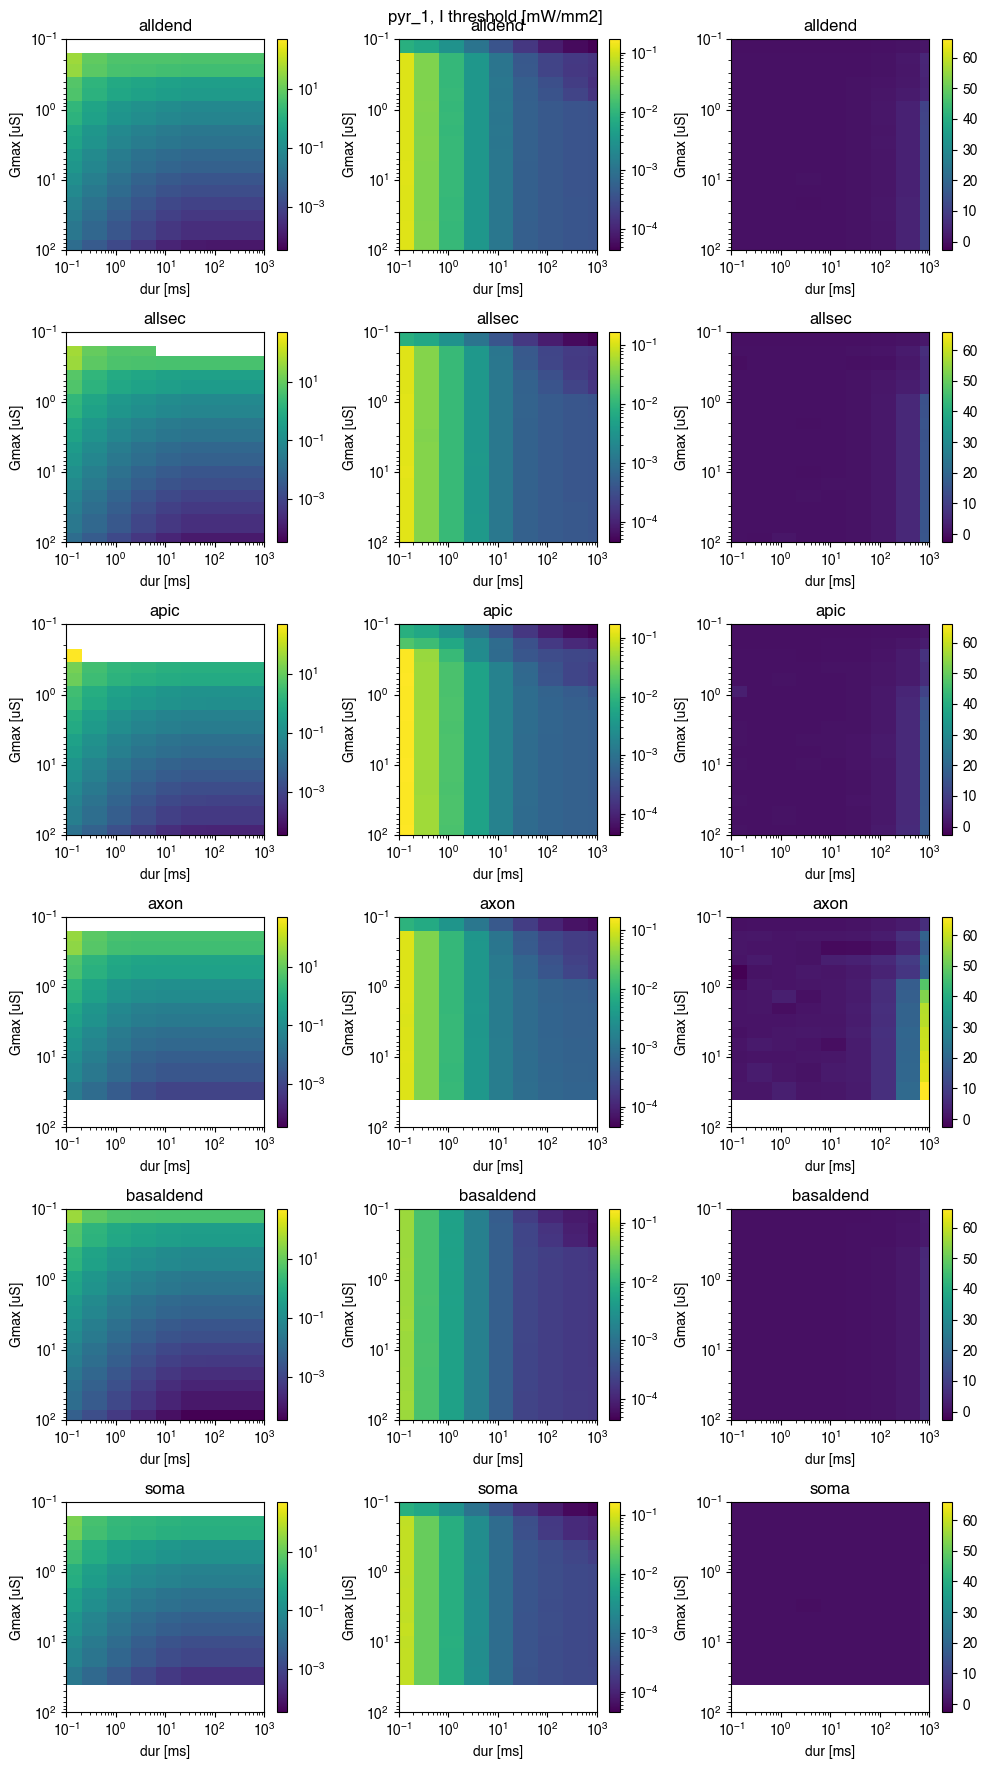

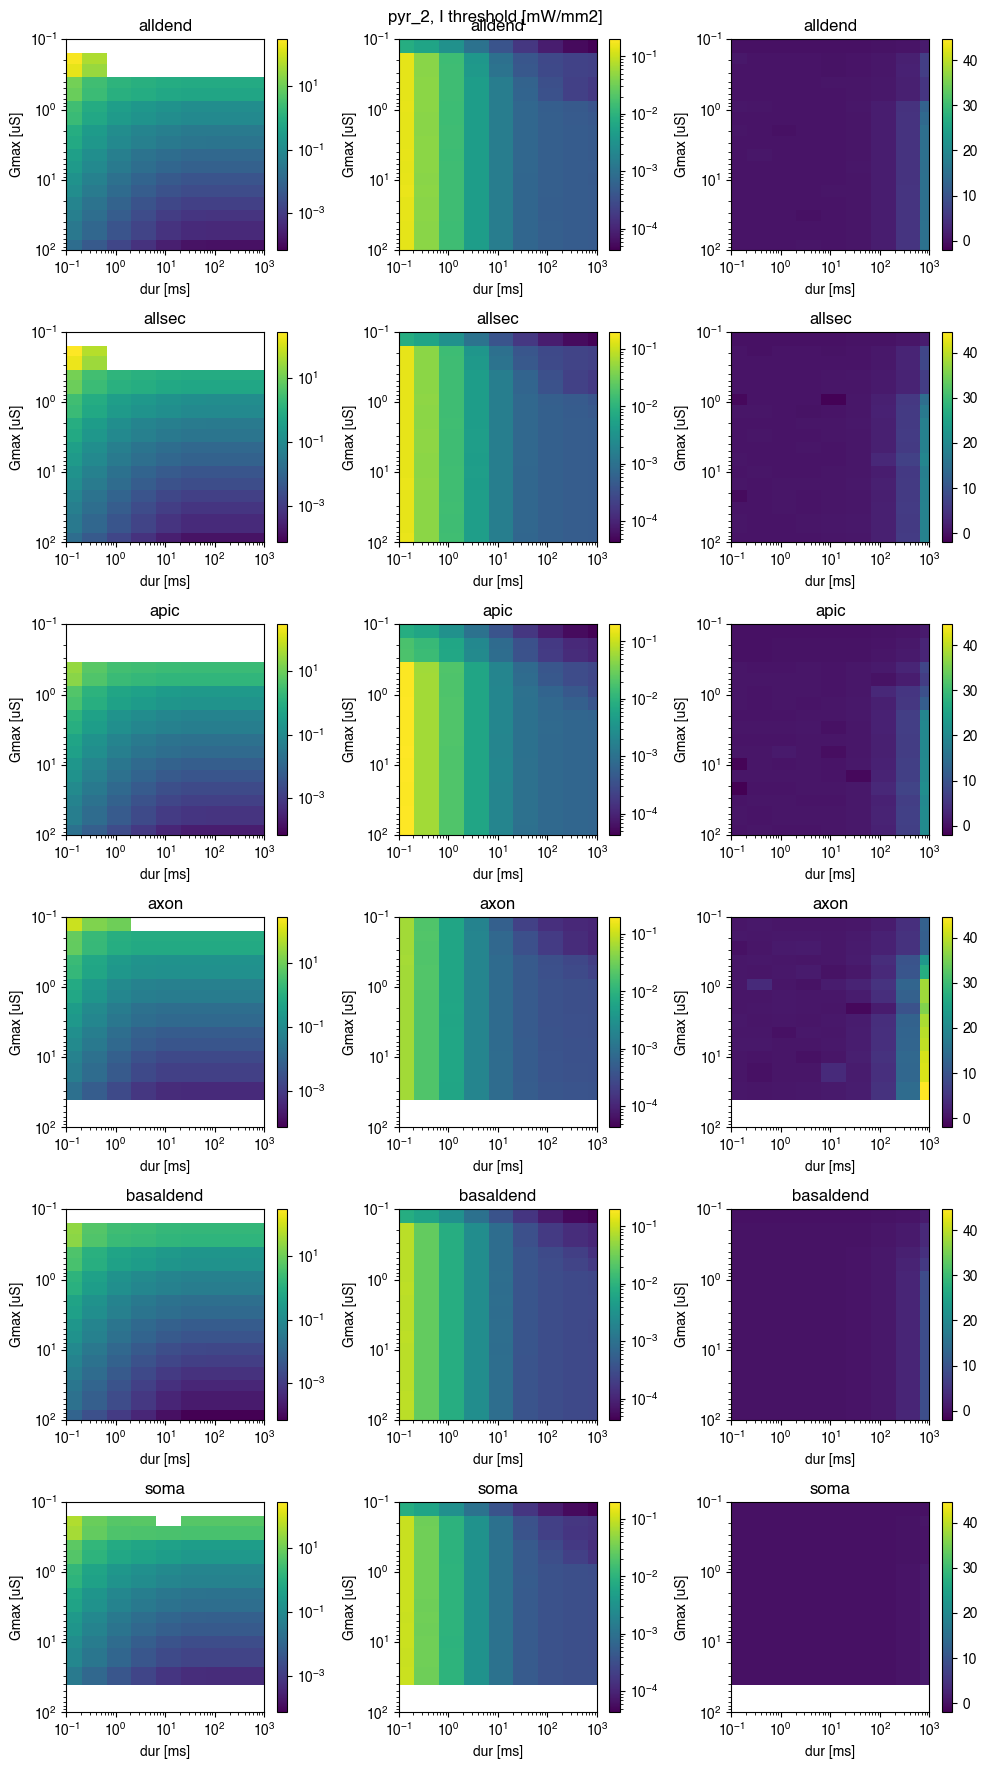

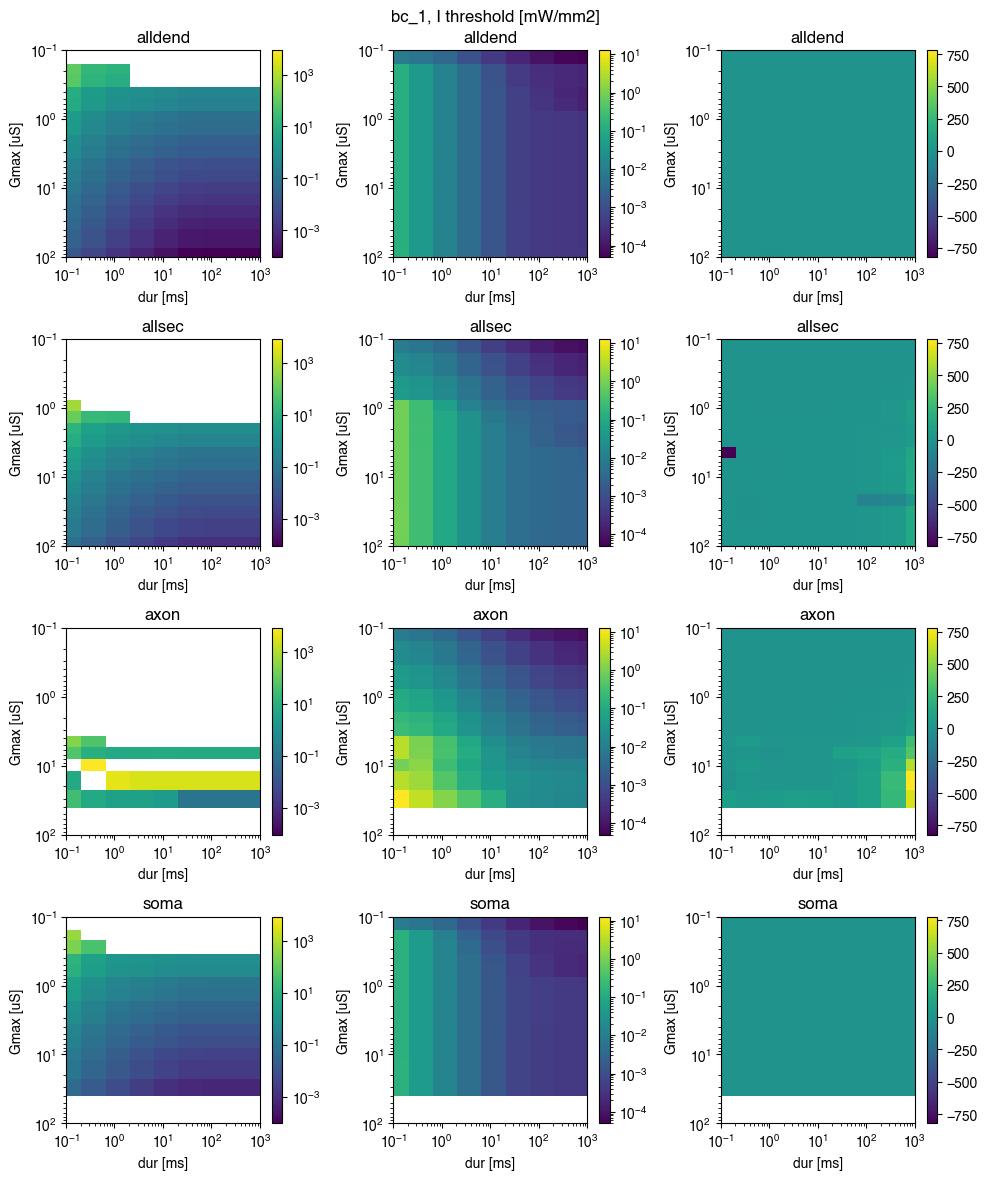

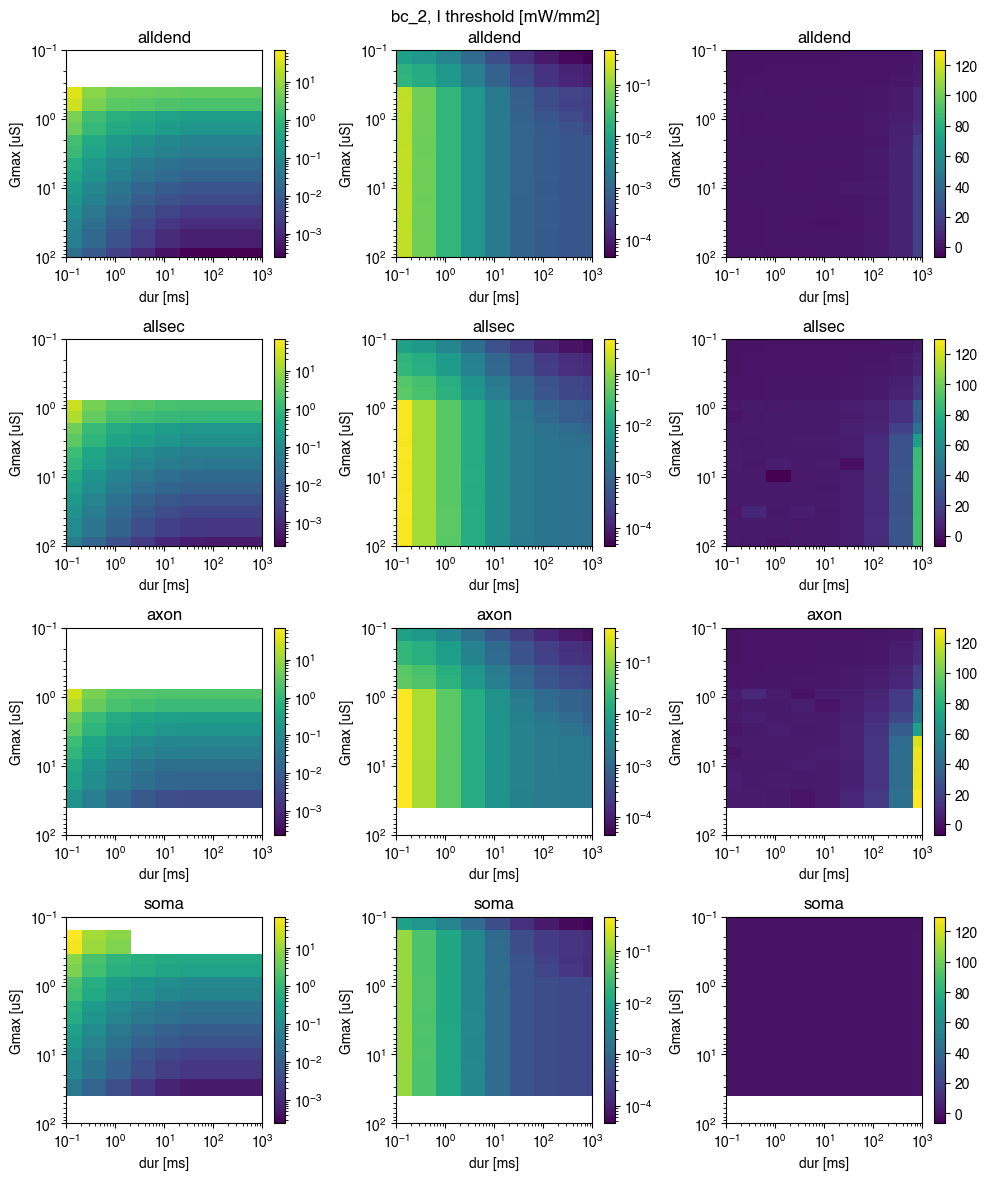

In [5]:
variables = ['opsinlocations','neurontemplate']
print([unique_values_columns_master[key] for key in variables])
levels = [0.1,1,10]
norm_log_cntr = mpl.cm.colors.LogNorm(vmax=levels[-1]*10, vmin=levels[0])
for neurontemplate in unique_values_columns_master['neurontemplate'][:]:
    fig_df = master_df[selection_generator(master_df,unique_values_columns=unique_values_columns_master,neurontemplate=neurontemplate)]
    uOpsinLocations = fig_df['opsinlocations'].unique()
    fig,axs = plt.subplots(len(uOpsinLocations),3,tight_layout = True,figsize = (10,3*len(uOpsinLocations)))
    for i,datalabel in enumerate(['amp','TAC', 'gchr2']):
        Imin = np.min(fig_df[datalabel])
        Imax = np.max(fig_df[datalabel])
        if Imin<0:
            norm = mpl.cm.colors.Normalize(vmax=Imax, vmin=Imin)
        else:
            norm = mpl.cm.colors.LogNorm(vmax=Imax, vmin=Imin)
        for oL,ax in zip(uOpsinLocations,axs[:,i]):
            intm_df = fig_df[fig_df['opsinlocations']==oL]
            udurs = np.unique(intm_df['dur'])
            uGmax = np.unique(intm_df['Gmax'])
            data_toplot = EcF.prepareDataforInterp(np.array((intm_df['dur'],intm_df['Gmax'],intm_df[datalabel])).T,'ninterp',sorted=False)
            yY, zZ = np.meshgrid(udurs,uGmax,indexing='ij')
            im,cb = EcF.slicePlot(data_toplot,ax,fig,plotGrid=(yY,zZ),structured=True, norm=norm)
            ax.set_xscale('log')
            ax.set_xlim((min(udurs),max(udurs)))
            ax.set_yscale('log')
            ax.set_ylim((1e-1,1e2))
            ax.invert_yaxis()
            ax.set_xlabel('dur [ms]')
            ax.set_ylabel('Gmax [uS]')
            ax.set_title(f'{oL}')
    fig.suptitle(f'{neurontemplate}, I threshold [mW/mm2]')
    print()

# Pyramidal cells
## Strength duration curve plots
- rows different Gmax
- colors different opsin position

Intensity: For long pulse durations seems to have converged to rheobase.\
TAC: at low Gmax no convergence, moroever curves of different opsin locations cross

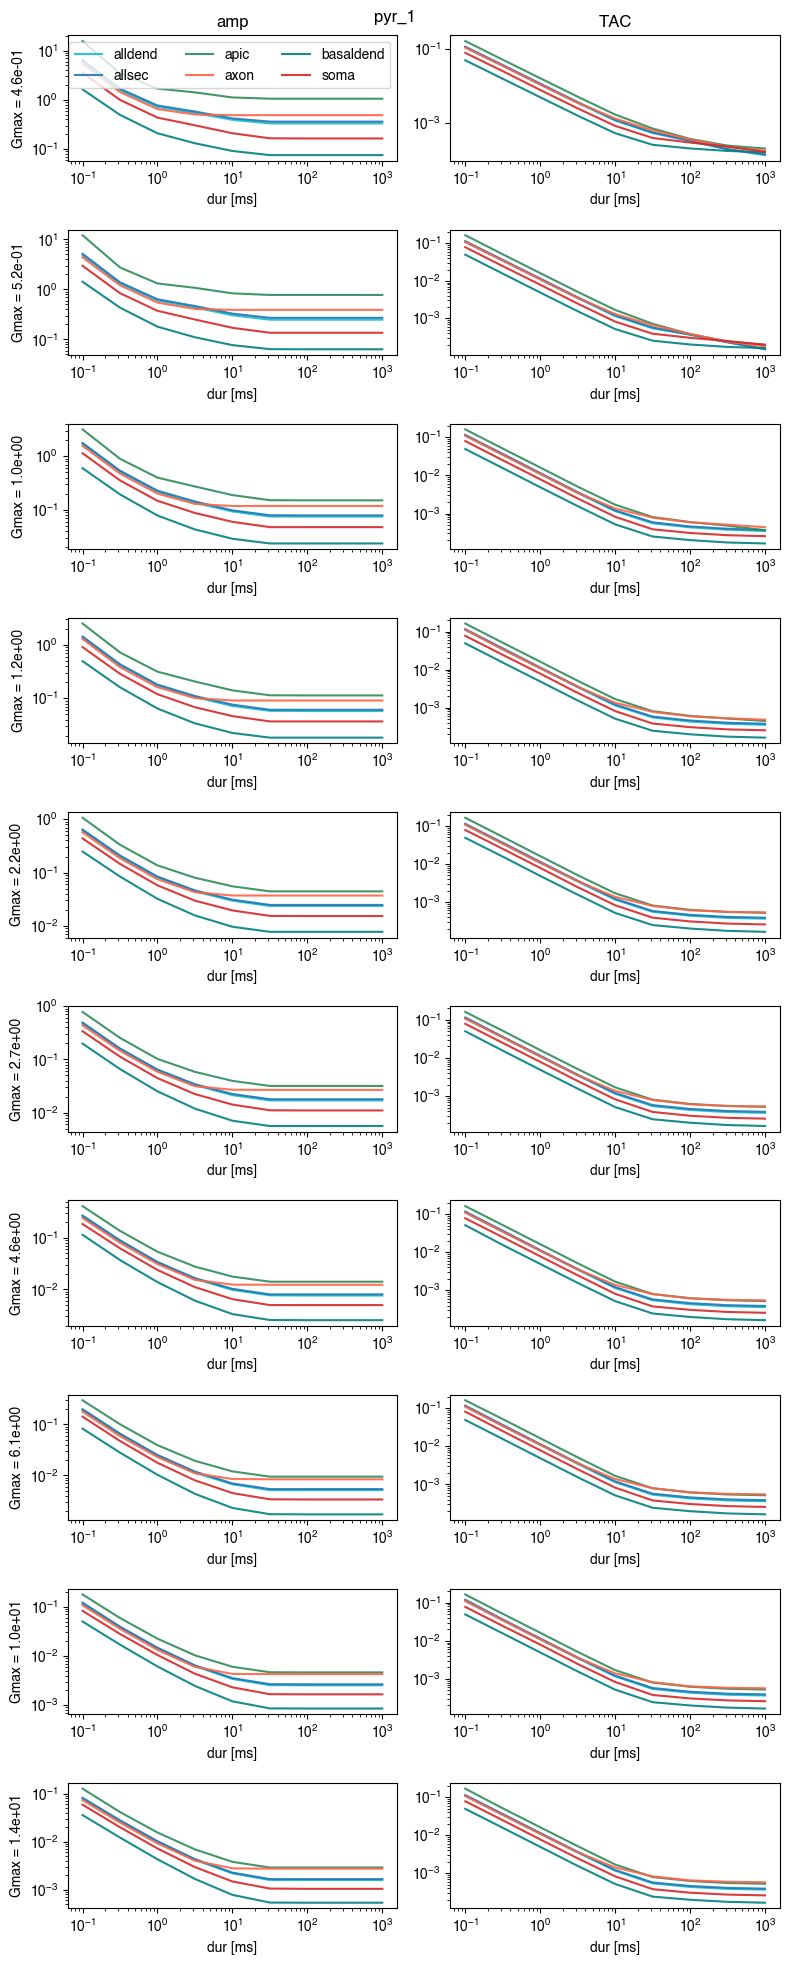

In [6]:

linestyle_str = ['solid', 'dotted', 'dashed', 'dashdot']
uGmax = np.sort(master_df['Gmax'].unique())[3:-4]

fig,axs = plt.subplots(len(uGmax),2,tight_layout = True,figsize = (8,2*len(uGmax)))
for neurontemplate,linestyle in zip(unique_values_columns_master['neurontemplate'][:1],linestyle_str):
    fig_df = master_df[selection_generator(master_df,unique_values_columns=unique_values_columns_master,neurontemplate=neurontemplate)]
    uGmax = np.sort(fig_df['Gmax'].unique())[3:-4]
    for i,datalabel in enumerate(['amp','TAC']):
        for uG,ax in zip(uGmax,axs[:,i]):
            logscale = False
            intm_df = fig_df[fig_df['Gmax']==uG]
            uOpsinLocations = [x for x in intm_df['opsinlocations'].unique()]
            for oL in uOpsinLocations:
                clr = colorkeyval[oL]
                plot_df = intm_df[intm_df['opsinlocations']==oL]
                xdata = plot_df['dur']
                ydata = plot_df[datalabel]
                ax.plot(xdata,ydata,color=clr,alpha=0.9,linestyle=linestyle,label=oL)
                if sum(~ np.isnan(ydata))>0:
                    logscale = True
            if logscale:
                ax.set_xscale('log')
                ax.set_yscale('log')
            ax.set_xlabel('dur [ms]')
            if i==0:
                ax.set_ylabel(f'Gmax = {uG:0.1e}')
            if uG == uGmax[0]:
                ax.set_title(datalabel)
                if i==0:
                    ax.legend(ncol=3)


    fig.suptitle(f'{neurontemplate}')
    print()

## Paperplots SDC and SGC

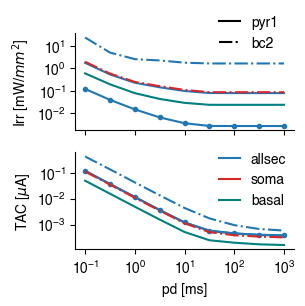

In [7]:

traces_toplot = [{'neurontemplate': 'pyr_1', 'Gmax':1, 'opsinlocations': 'allsec'},
                 {'neurontemplate': 'pyr_1', 'Gmax':10, 'opsinlocations': 'allsec'},
                 {'neurontemplate': 'pyr_1', 'Gmax':1, 'opsinlocations': 'basaldend'},
                 {'neurontemplate': 'bc_2', 'Gmax':1, 'opsinlocations': 'allsec'},
                 {'neurontemplate': 'bc_2', 'Gmax':1, 'opsinlocations': 'soma'}]

fig,axs = plt.subplots(2,1, sharex=True, figsize = (8/2.54,8/2.54), tight_layout=True)

for feat, ax in zip(['amp','TAC'],axs):
    for trace_info in traces_toplot[:]:
        mydata = master_df[selection_generator(master_df,unique_values_columns=unique_values_columns_master,**trace_info)]
        xdata = mydata['dur']
        ydata = mydata[feat]
        ax.plot(xdata, ydata, color = colorkeyval[trace_info['opsinlocations']],linestyle=stylekeyval[trace_info['neurontemplate']],marker='' if trace_info['Gmax']<10 else '.')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel('Irr [mW/$mm^2$]' if feat=='amp' else 'TAC [$\mu$A]')

for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

ax.set_xlabel('pd [ms]')
ax.set_xticks([0.1, 1, 10, 100, 1000])
axs[0].set_yticks([0.01,0.1, 1, 10])

axs[0].plot(np.nan,np.nan,label='pyr1',color = 'k',linestyle=stylekeyval['pyr_1'],marker='')
axs[0].plot(np.nan,np.nan,label='bc2',color = 'k',linestyle=stylekeyval['bc_2'],marker='')
axs[1].plot(np.nan,np.nan,label='allsec',color = colorkeyval['allsec'],linestyle=stylekeyval['pyr_1'],marker='')
axs[1].plot(np.nan,np.nan,label='soma',color = colorkeyval['soma'],linestyle=stylekeyval['pyr_1'],marker='')
axs[1].plot(np.nan,np.nan,label='basal',color = colorkeyval['basaldend'],linestyle=stylekeyval['pyr_1'],marker='')
axs[0].legend(frameon=False, bbox_to_anchor=(0.6,0.7), handlelength=1.5)
axs[1].legend(frameon=False, bbox_to_anchor=(0.6,0.3), handlelength=1.5)
axs[1].minorticks_off()
fig.savefig('SDC.svg')


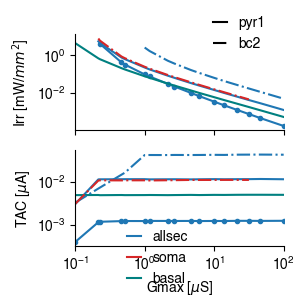

In [8]:
traces_toplot = [{'neurontemplate': 'pyr_1', 'dur':1, 'opsinlocations': 'allsec'},
                 {'neurontemplate': 'pyr_1', 'dur':10, 'opsinlocations': 'allsec'},
                 {'neurontemplate': 'pyr_1', 'dur':1, 'opsinlocations': 'basaldend'},
                 {'neurontemplate': 'bc_2', 'dur':1, 'opsinlocations': 'allsec'},
                 {'neurontemplate': 'bc_2', 'dur':1, 'opsinlocations': 'soma'}]

fig,axs = plt.subplots(2,1,sharex=True, figsize = (8/2.54,8/2.54), tight_layout=True)

for feat, ax in zip(['amp','TAC'],axs):
    for trace_info in traces_toplot[:]:
        mydata = master_df[selection_generator(master_df,unique_values_columns=unique_values_columns_master,**trace_info)]
        xdata,ydata = sort_xy_based_x(mydata['Gmax'],mydata[feat])
        ax.plot(xdata, ydata, color = colorkeyval[trace_info['opsinlocations']],linestyle=stylekeyval[trace_info['neurontemplate']],marker='' if trace_info['dur']<10 else '.')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel('Irr [mW/$mm^2$]' if feat=='amp' else 'TAC [$\mu$A]')

for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

ax.set_xlabel('Gmax [$\mu$S]')
ax.set_xticks(np.logspace(-2,2,5))
ax.set_xlim([0.1,100])
axs[0].plot(np.nan,np.nan,label='pyr1',color = 'k',linestyle=stylekeyval['pyr_1'],marker='')
axs[0].plot(np.nan,np.nan,label='bc2',color = 'k',linestyle=stylekeyval['bc_2'],marker='')
axs[1].plot(np.nan,np.nan,label='allsec',color = colorkeyval['allsec'],linestyle=stylekeyval['pyr_1'],marker='')
axs[1].plot(np.nan,np.nan,label='soma',color = colorkeyval['soma'],linestyle=stylekeyval['pyr_1'],marker='')
axs[1].plot(np.nan,np.nan,label='basal',color = colorkeyval['basaldend'],linestyle=stylekeyval['pyr_1'],marker='')
axs[0].legend(frameon=False, bbox_to_anchor=(0.6,0.7), handlelength=1)
axs[1].legend(frameon=False, bbox_to_anchor=(0.6,0.3), handlelength=1)
axs[0].minorticks_off()
axs[1].minorticks_off()
fig.savefig('SGC.svg')

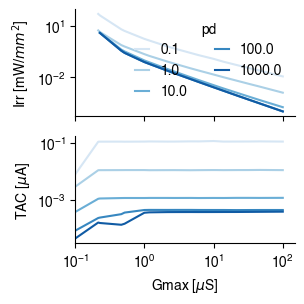

In [9]:

fig,axs = plt.subplots(2,1,sharex=True, figsize = (8/2.54,8/2.54), tight_layout=True)
fig_df = master_df[selection_generator(master_df,unique_values_columns=unique_values_columns_master,**{'neurontemplate': 'pyr_1', 'opsinlocations': 'allsec'})]
udurs = np.logspace(-1,3,5)
colors = np.array(sns.light_palette("tab:blue", n_colors=len(udurs)+1))
colors = np.array(sns.color_palette("Blues", n_colors=len(udurs)))
for feat, ax in zip(['amp','TAC'],axs):

    for dur,clr in zip(udurs,colors[:,:]):
        mydata = fig_df[selection_generator(fig_df,unique_values_columns=unique_values_columns_master,**{'dur':dur})]
        xdata,ydata = sort_xy_based_x(mydata['Gmax'],mydata[feat])
        ax.plot(xdata, ydata, color = clr,linestyle='-')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel('Irr [mW/$mm^2$]' if feat=='amp' else 'TAC [$\mu$A]')

for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
for dur,clr in zip(udurs,colors[:,:]):
    axs[0].plot(np.nan,np.nan,label=np.round(dur,2),color=clr)

ax.set_xlabel('Gmax [$\mu$S]')
ax.set_xticks(np.logspace(-2,2,5))
ax.set_xlim([0.1,150])
axs[0].legend(frameon=False, bbox_to_anchor=(1,1), handlelength=1, loc='upper right', title='pd',ncol=2)
axs[0].minorticks_off()
axs[1].minorticks_off()
fig.savefig('SGC2.svg')

## STATISTICS
Pooled all simulations together\
Check if categories (neurontemplate, opsinlocations, Gmax and dur) give different results\


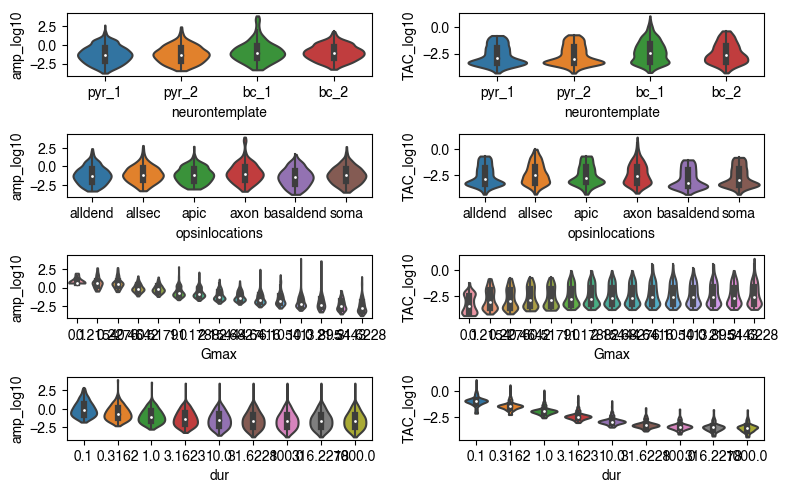

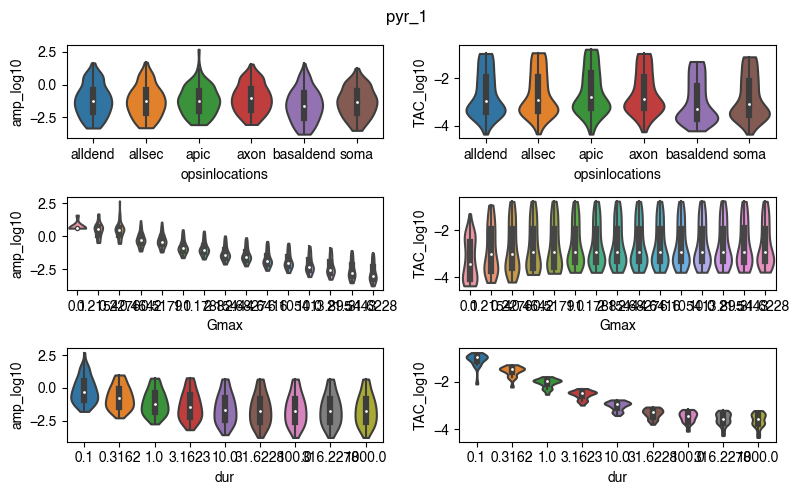

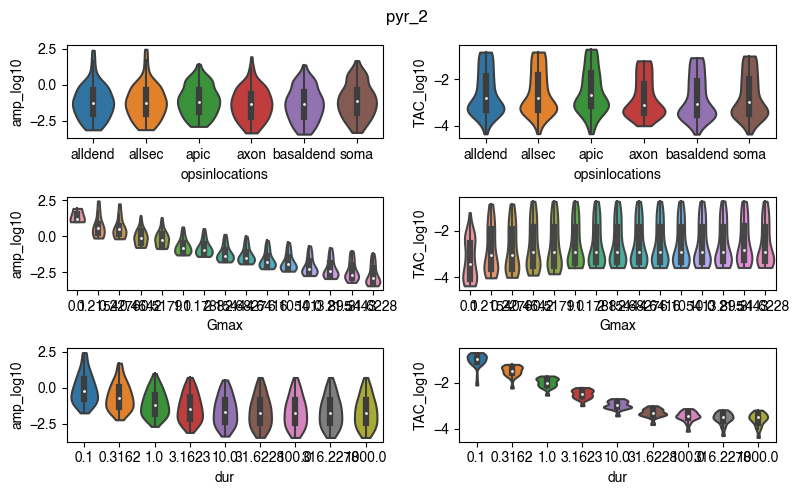

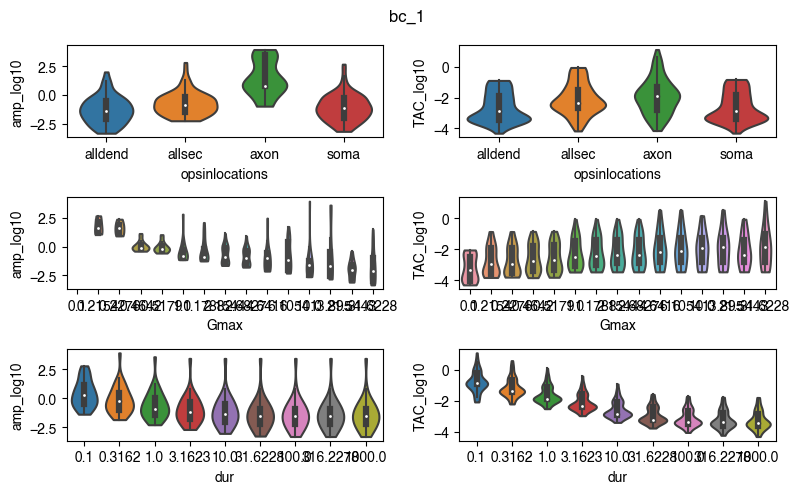

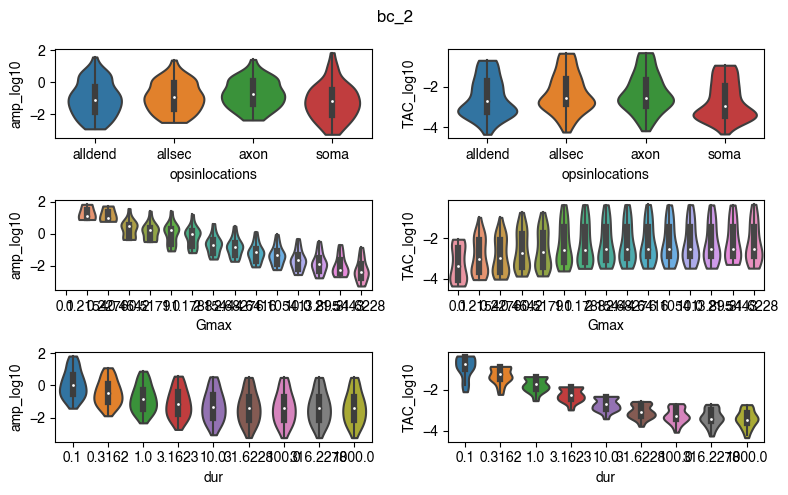

In [10]:
statistics_df = master_df[(master_df['Gmax']>=0.099) & (master_df['Gmax']<32)]
fig,axs = plt.subplots(4,2,tight_layout = True,figsize=(8,5))
for i,pool in enumerate(['neurontemplate','opsinlocations','Gmax','dur']):
    sns.violinplot(data=statistics_df,y='amp_log10',x=pool,ax=axs[i,0],cut=0)
    sns.violinplot(data=statistics_df,y='TAC_log10',x=pool,ax=axs[i,1],cut=0)
for nt in unique_values_columns_master['neurontemplate']:
    idx = statistics_df['neurontemplate']==nt
    fig,axs = plt.subplots(3,2,tight_layout = True,figsize=(8,5))
    for i,pool in enumerate(['opsinlocations','Gmax','dur']):
        sns.violinplot(data=statistics_df[idx],y='amp_log10',x=pool,ax=axs[i,0],cut=0)
        sns.violinplot(data=statistics_df[idx],y='TAC_log10',x=pool,ax=axs[i,1],cut=0)
    fig.suptitle(nt)

### Kruskal-Wallis H-test

{'amp_log10': {'all': {'neurontemplate': (25.212631618336662, 1.3937875068076586e-05), 'opsinlocations': (32.471551536483325, 4.7911572551647365e-06), 'Gmax': (1318.25367138746, 6.387033974825817e-273), 'dur': (433.39617868908005, 1.3324647700244672e-88)}}, 'TAC_log10': {'all': {'neurontemplate': (56.72244912758026, 2.9454916615583324e-12), 'opsinlocations': (84.32387879955648, 1.0432883561161508e-16), 'Gmax': (159.1092760192269, 1.0717854026595063e-26), 'dur': (2162.232655497033, 0.0)}}}


Text(0.5, 1.0, 'Kruskal Wallis')

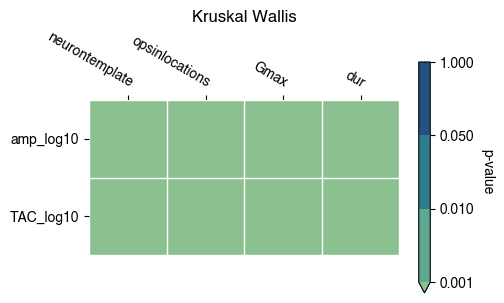

In [11]:
colors = np.array(sns.color_palette("crest", n_colors=10))
colors = colors[[0,2,5,8],:]
cmap = LinearSegmentedColormap.from_list('my_cmap', colors, N=colors.shape[0])
boundaries  = [0.001,0.01,0.05,1.0]
boundnorm = mpl.cm.colors.BoundaryNorm(boundaries,len(boundaries),extend='min')


KW_dict = {}
features = ['amp_log10','TAC_log10']
classes = [x for x in all_settings_columns[::-1] if not ('_log10' in x or x=='nPulse')]
for feat in features:
    KW_dict[feat] = {'all':{}}
    for pool in classes:
        ukeys = statistics_df[pool].unique()
        pooledData = [list(statistics_df[feat][statistics_df[pool]==ukey]) for ukey in ukeys]
        KW_dict[feat]['all'][pool] = stats.kruskal(*pooledData,nan_policy='omit')[:]
print(KW_dict)

heatmapdata = np.zeros((len(features),len(classes)))
for ifeat,feat in enumerate(features):
    for ipool,pool in enumerate(classes):
        heatmapdata[ifeat,ipool] = KW_dict[feat]['all'][pool][1]

fig,ax= plt.subplots(1,1,figsize = (5,3))
heatmap(heatmapdata,features,classes,ax=ax,norm=boundnorm,cmap=cmap,cbarlabel='p-value')
ax.set_title('Kruskal Wallis')

### Mann Whitney U Test and Wilcoxon signed-rank test
WSRT: hypothesis that two related paired samples come from the same distribution. In particular, it tests whether the distribution of the differences x - y is symmetric about zero.

Wilcoxon signed Rank test not equal


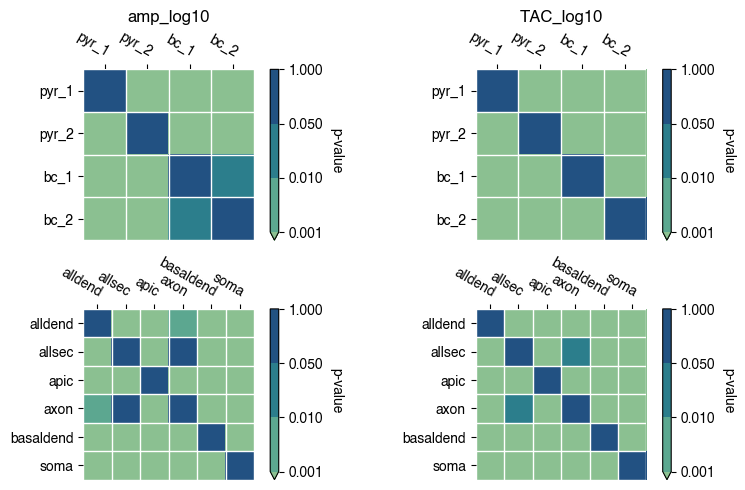

In [12]:
classes_toplot = ['neurontemplate','opsinlocations']
MWU_dict = {}
WSRT_dict = {}
for feat in features:
    MWU_dict[feat] = {'all':{}}
    WSRT_dict[feat] = {'all':{}}
    for pool in classes_toplot:
        ukeys =  unique_values_columns_master[pool]
        mytest_MWU = np.ones((len(ukeys),len(ukeys),2))
        mytest_WSRT = np.ones((len(ukeys),len(ukeys),2))
        for i in range(len(ukeys)):
            for j in range(len(ukeys)):
                x = np.array(statistics_df[feat][statistics_df[pool]==ukeys[i]])
                x = x[~np.isnan(x)]
                y = np.array(statistics_df[feat][statistics_df[pool]==ukeys[j]])
                y = y[~np.isnan(y)]
                if len(y)>0 and len(x)>0:
                    mytest_MWU[i,j,0] = stats.mannwhitneyu(x,y)[0]
                    mytest_MWU[i,j,1] = stats.mannwhitneyu(x,y)[1]

                df1 = statistics_df[statistics_df[pool]==ukeys[i]]
                df2 = statistics_df[statistics_df[pool]==ukeys[j]]
                df1 = df1.set_index([x for x in classes if not (pool in x or x in pool)])[feat]
                df2 = df2.set_index([x for x in classes if not (pool in x or x in pool)])[feat]
                diff_df = pd.merge(df1, df2, left_index=True, right_index = True, suffixes=('_0', '_1'),validate='one_to_many')
                diff_df = diff_df[feat+'_1']-diff_df[feat+'_0']
                xydiff = np.array(diff_df)
                xydiff = xydiff[~np.isnan(xydiff)]
                if  len(xydiff)>0 and i!=j:
                    mytest_WSRT[i,j,0] = stats.wilcoxon(xydiff)[0]
                    mytest_WSRT[i,j,1] = stats.wilcoxon(xydiff)[1]
        MWU_dict[feat]['all'][pool] = mytest_MWU
        WSRT_dict[feat]['all'][pool] = mytest_WSRT

print('Wilcoxon signed Rank test not equal')
fig,axs = plt.subplots(len(classes_toplot),2,tight_layout=True,figsize=(8,5))
for pool,ax in zip(classes_toplot,axs):
    ukeys =  unique_values_columns_master[pool]
    for ifeat,feat in enumerate(features):
        #im,_ = heatmap(MWU_dict[feat]['all'][pool][:,:,1], ukeys, ukeys, ax=ax[ifeat*2], norm=boundnorm,cmap=cmap,cbarlabel='p-value')
        im,_ = heatmap(WSRT_dict[feat]['all'][pool][:,:,1], ukeys, ukeys, ax=ax[ifeat], norm=boundnorm,cmap=cmap,cbarlabel='p-value')
        if pool==classes_toplot[0]:
            ax[ifeat].set_title(feat)

Wilcoxon signed Rank test not equal


Text(0.5, 0.98, 'row less than column')

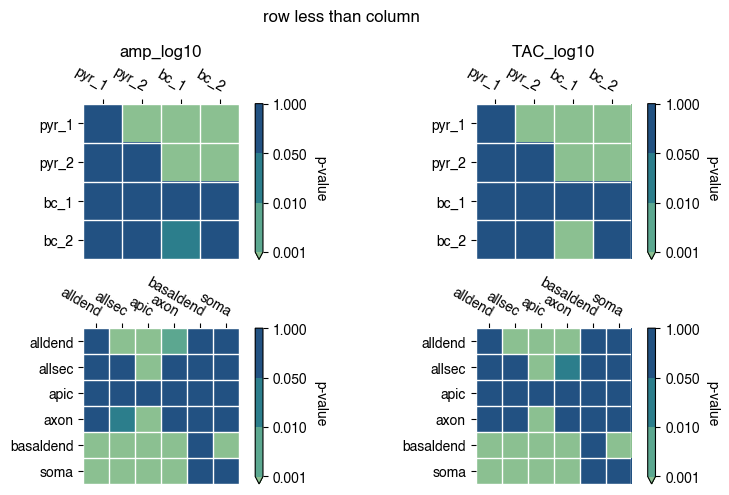

In [13]:
classes_toplot = ['neurontemplate','opsinlocations']
MWU_dict = {}
WSRT_dict = {}
for feat in features:
    MWU_dict[feat] = {'all':{}}
    WSRT_dict[feat] = {'all':{}}
    for pool in classes_toplot:
        ukeys =  unique_values_columns_master[pool]
        mytest_MWU = np.ones((len(ukeys),len(ukeys),2))
        mytest_WSRT = np.ones((len(ukeys),len(ukeys),2))
        for i in range(len(ukeys)):
            for j in range(len(ukeys)):
                x = np.array(statistics_df[feat][statistics_df[pool]==ukeys[i]])
                x = x[~np.isnan(x)]
                y = np.array(statistics_df[feat][statistics_df[pool]==ukeys[j]])
                y = y[~np.isnan(y)]
                if len(y)>0 and len(x)>0:
                    mytest_MWU[i,j,0] = stats.mannwhitneyu(x,y)[0]
                    mytest_MWU[i,j,1] = stats.mannwhitneyu(x,y)[1]

                df1 = statistics_df[statistics_df[pool]==ukeys[i]]
                df2 = statistics_df[statistics_df[pool]==ukeys[j]]
                df1 = df1.set_index([x for x in classes if not (pool in x or x in pool)])[feat]
                df2 = df2.set_index([x for x in classes if not (pool in x or x in pool)])[feat]
                diff_df = pd.merge(df1, df2, left_index=True, right_index = True, suffixes=('_0', '_1'),validate='one_to_many')
                diff_df = diff_df[feat+'_1']-diff_df[feat+'_0']
                xydiff = np.array(diff_df)
                xydiff = xydiff[~np.isnan(xydiff)]
                if  len(xydiff)>0 and i!=j:
                    mytest_WSRT[i,j,0] = stats.wilcoxon(xydiff,alternative='greater')[0]
                    mytest_WSRT[i,j,1] = stats.wilcoxon(xydiff,alternative='greater')[1]
        MWU_dict[feat]['all'][pool] = mytest_MWU
        WSRT_dict[feat]['all'][pool] = mytest_WSRT

print('Wilcoxon signed Rank test not equal')
fig,axs = plt.subplots(len(classes_toplot),2,tight_layout=True,figsize=(8,5))
for pool,ax in zip(classes_toplot,axs):
    ukeys =  unique_values_columns_master[pool]
    for ifeat,feat in enumerate(features):
        #im,_ = heatmap(MWU_dict[feat]['all'][pool][:,:,1], ukeys, ukeys, ax=ax[ifeat*2], norm=boundnorm,cmap=cmap,cbarlabel='p-value')
        im,_ = heatmap(WSRT_dict[feat]['all'][pool][:,:,1], ukeys, ukeys, ax=ax[ifeat], norm=boundnorm,cmap=cmap,cbarlabel='p-value')
        if pool==classes_toplot[0]:
            ax[ifeat].set_title(feat)
fig.suptitle('row less than column')

### Same test split over cells
From results below (see ratio wrt to soma) would have suspected soma vs axon and alldend vs allsec would not be statistically significant!

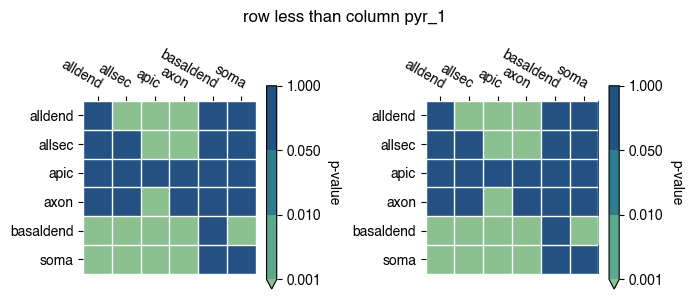

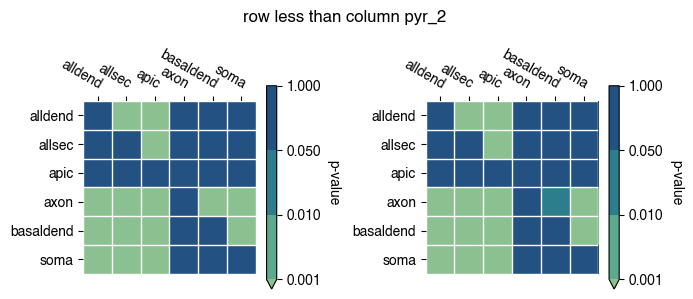

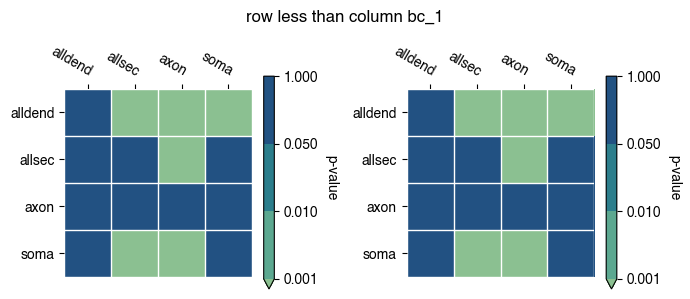

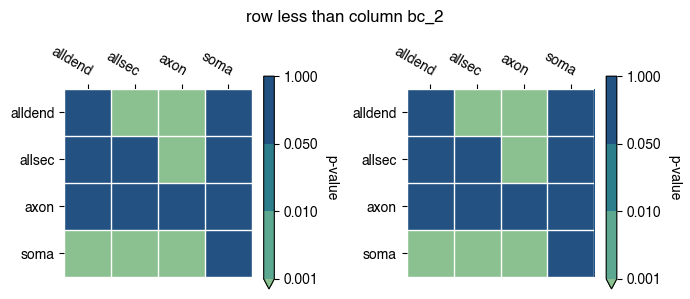

In [14]:

subclasses = ['opsinlocations']
for cell in unique_values_columns_master['neurontemplate'][:]:
    intm_df = statistics_df[statistics_df['neurontemplate']==cell]
    for feat in features:
        WSRT_dict[feat][cell] = {}
        for pool in subclasses:
            if pool == 'opsinlocations':
                ukeys = intm_df[pool].unique()
            else:
                ukeys = unique_values_columns_master[pool]
            mytest_WSR = np.ones((len(ukeys),len(ukeys),2))
            for i in range(len(ukeys)):
                for j in range(len(ukeys)):
                    #WSRT
                    df1 = intm_df[intm_df[pool]==ukeys[i]]
                    df2 = intm_df[intm_df[pool]==ukeys[j]]
                    df1 = df1.set_index([x for x in classes if not (pool in x or x in pool)])[feat]
                    df2 = df2.set_index([x for x in classes if not (pool in x or x in pool)])[feat]
                    diff_df = pd.merge(df1, df2, left_index=True, right_index = True, suffixes=('_0', '_1'),validate='one_to_many')
                    diff_df = diff_df[feat+'_1']-diff_df[feat+'_0']
                    xydiff = np.array(diff_df)
                    xydiff = xydiff[~np.isnan(xydiff)]
                    if  len(xydiff)>0 and i!=j:
                        mytest_WSR[i,j,0] = stats.wilcoxon(xydiff,alternative='greater')[0]
                        mytest_WSR[i,j,1] = stats.wilcoxon(xydiff,alternative='greater')[1]

            WSRT_dict[feat][cell][pool] = mytest_WSR

    fig,axs = plt.subplots(len(subclasses),2,tight_layout=True,figsize=(7,3))
    if len(subclasses)==1:
        axs = [axs]
    for pool,ax in zip(subclasses,axs):
        if pool == 'opsinlocations':
            ukeys = intm_df[pool].unique()
        else:
            ukeys =  unique_values_columns_master[pool]
        for ifeat,feat in enumerate(features):
            im,_ = heatmap(WSRT_dict[feat][cell][pool][:,:,1], ukeys, ukeys, ax=ax[ifeat], norm=boundnorm,cmap=cmap,cbarlabel='p-value')
            if pool==classes[0]:
                ax[ifeat].set_title(feat)
    fig.suptitle(f'row less than column {cell}')

### Wilcoxon signed rank test for all opsin neuron template locations
This identifies most excitable combination

['pyr_1alldend' 'pyr_1allsec' 'pyr_1apic' 'pyr_1axon' 'pyr_1basaldend'
 'pyr_1soma' 'pyr_2alldend' 'pyr_2allsec' 'pyr_2apic' 'pyr_2axon'
 'pyr_2basaldend' 'pyr_2soma' 'bc_1alldend' 'bc_1allsec' 'bc_1axon'
 'bc_1soma' 'bc_2alldend' 'bc_2allsec' 'bc_2axon' 'bc_2soma']


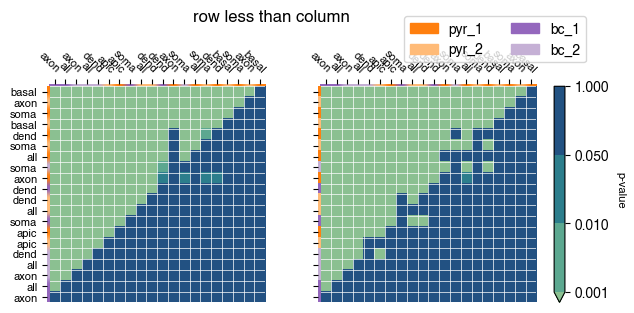

In [15]:
font = {'family': 'helvetica',
        'size': 10}
mpl.rc('font', **font)
colors = np.array(sns.color_palette("crest", n_colors=10))
colors = colors[[0,2,5,8],:]
cmap = LinearSegmentedColormap.from_list('my_cmap', colors, N=colors.shape[0])
boundaries  = [0.001,0.01,0.05,1.0]
boundnorm = mpl.cm.colors.BoundaryNorm(boundaries,len(boundaries),extend='min')
features = ['amp','TAC']
classes = ['neurontemplate','opsinlocations','Gmax','dur']
wsrt_df = statistics_df[features+classes].copy()
wsrt_df['wsrt_keys'] = wsrt_df.apply(lambda x: f"{x['neurontemplate']}{x['opsinlocations']}",axis=1)
print(wsrt_df['wsrt_keys'].unique())

cvrt_label = {'allsec':'all', 'alldend':'dend', 'soma':'soma', 'axon':'axon', 'basaldend':'basal', 'apic':'apic'}


WSRT_dict = {}
ukeys =  wsrt_df['wsrt_keys'].unique()
for feat in features:
    WSRT_dict[feat] = {}
    mytest_WSRT = np.ones((len(ukeys),len(ukeys),2))
    for i in range(len(ukeys)):
        for j in range(len(ukeys)):
            df1 = wsrt_df[wsrt_df['wsrt_keys']==ukeys[i]]
            df2 = wsrt_df[wsrt_df['wsrt_keys']==ukeys[j]]
            df1 = df1.set_index([x for x in ['Gmax','dur']])[feat]
            df2 = df2.set_index([x for x in ['Gmax','dur']])[feat]
            diff_df = pd.merge(df1, df2, left_index=True, right_index = True, suffixes=('_0', '_1'),validate='one_to_many')
            diff_df = diff_df[feat+'_1']-diff_df[feat+'_0']
            xydiff = np.array(diff_df)
            xydiff = xydiff[~(np.isnan(xydiff)|np.isinf(xydiff))]
            if  len(xydiff)>0 and i!=j:
                wstats = stats.wilcoxon(xydiff,alternative='greater')
                mytest_WSRT[i,j,0] = wstats[0]
                mytest_WSRT[i,j,1] = wstats[1]
    WSRT_dict[feat] = mytest_WSRT



# row_colors = np.array(sns.color_palette("tab20"))
# row_colors = row_colors[[2,3,0,1],:]
row_colors_dict = {x:colorkeyval[x] for x in wsrt_df['neurontemplate'].unique()}
# row_colors = np.tile(np.array([[1,0,0,0.99],[0,1,0,0.99]]),(int(len(ukeys)/2),1))[:,None,:]
row_colors_dict

fig,axs = plt.subplots(1,2,tight_layout=True,figsize=(19/2.54,8/2.54))
for ifeat, (feat, ax) in enumerate(zip(features,axs)):
    greatest = np.sum(WSRT_dict[feat][:,:,1]<0.001,axis=1)+0.5*np.sum((WSRT_dict[feat][:,:,1]<0.01) & (WSRT_dict[feat][:,:,1]>=0.001),axis=1)\
    + 0.1*np.sum((WSRT_dict[feat][:,:,1]<0.05) & (WSRT_dict[feat][:,:,1]>=0.01),axis=1)
    if ifeat==0:
        idx_column = np.argsort(greatest)
        idx_row = np.flip(idx_column)
    row_labels = ukeys[idx_row]
    column_labels = ukeys[idx_column]
    row_colors = np.array([i for x in row_labels for k,i in row_colors_dict.items() if k in x])[:,None,:]
    column_colors = np.array([i for x in column_labels for k,i in row_colors_dict.items() if k in x])[None,:,:]
    row_labels = [x.rsplit('_',1)[1][1:] for x in row_labels]
    column_labels = [x.rsplit('_',1)[1][1:] for x in column_labels]
    row_labels = [cvrt_label[x] for x in row_labels]
    if ifeat==1:
        row_labels = ['' for x in row_labels]
    column_labels = [cvrt_label[x] for x in column_labels]

    data_toplot = WSRT_dict[feat][:,idx_column,1]
    im,cbar = heatmap2(data_toplot[idx_row,:], row_labels, column_labels, ax=ax, row_colors=row_colors, column_colors=column_colors, norm=boundnorm,cmap=cmap,cbarlabel='p-value',labelfs = 8, lw_grid=0.5)
    if feat==classes[0]:
        ax[ifeat].set_title(feat)
    if ifeat==0:
        cbar.remove()
fig.suptitle(f'row less than column')
legendpatches = []
for k,v in row_colors_dict.items():
    legendpatches.append(mpl.patches.Patch(color=v, label=k))
fig.legend(handles = legendpatches, bbox_to_anchor = (0.93,0.98), ncol=2)
fig.savefig('wsrt_fixedI.svg')

Gmax lower pvalues when comparison with higher Gmax (see Gmax == 100 vs Gmax == 0.4642)

## ratio Strength duration curves relative to soma SDC

Observation:\
- almost constant over duration / except TAC at high pulse durations
- basal dend best location, apical worst

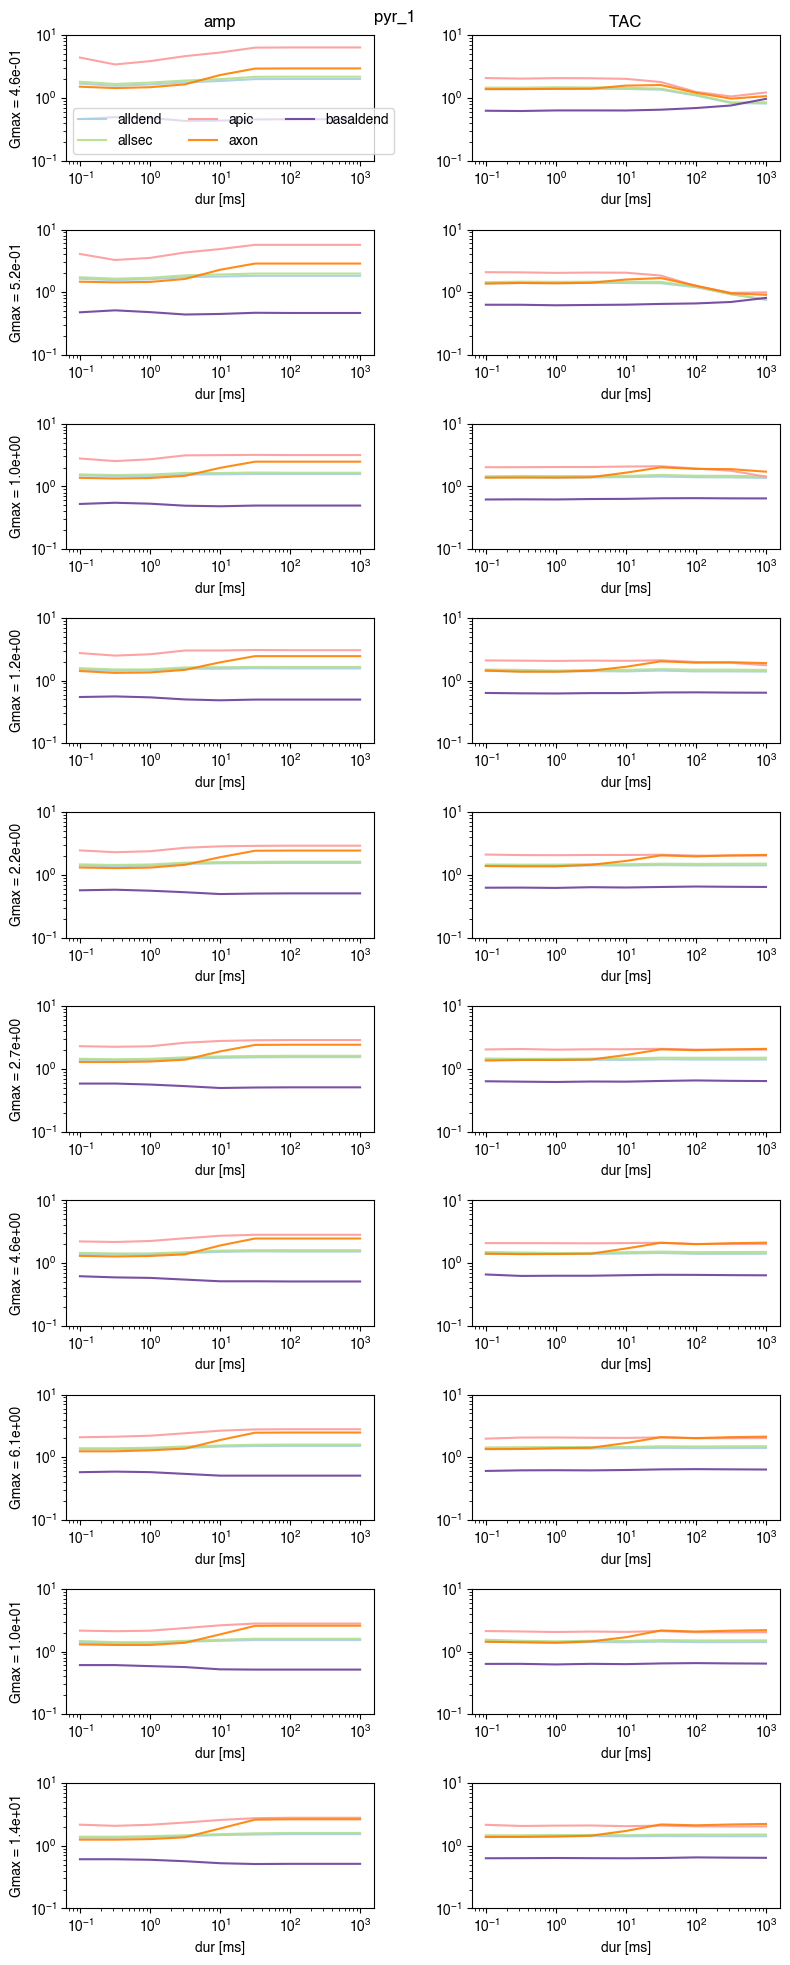

In [16]:
reference = 'soma'
colors = plt.get_cmap('Paired',len(unique_values_columns_master['opsinlocations'])).colors
colorpairs = {x:clr for x,clr in zip(unique_values_columns_master['opsinlocations'],colors)}
linestyle_str = ['solid', 'dotted', 'dashed', 'dashdot']
uGmax = np.sort(master_df['Gmax'].unique())[3:-4]
fig,axs = plt.subplots(len(uGmax),2,tight_layout = True,figsize = (8,2*len(uGmax)))
for neurontemplate,linestyle,alpha in zip(unique_values_columns_master['neurontemplate'][:1],linestyle_str,[0.9,0.7]):
    fig_df = master_df[selection_generator(master_df,unique_values_columns=unique_values_columns_master,neurontemplate=neurontemplate)]


    for i,datalabel in enumerate(['amp','TAC']):
        for uG,ax in zip(uGmax,axs[:,i]):
            logscale = False
            intm_df = fig_df[fig_df['Gmax']==uG]
            uOpsinLocations = [x for x in intm_df['opsinlocations'].unique() if x != reference]
            for oL in uOpsinLocations:
                clr = colorpairs[oL]
                plot_df = intm_df[intm_df['opsinlocations']==oL]
                xdata = plot_df['dur']
                ydata = plot_df[datalabel]
                ref_ydata = intm_df[intm_df['opsinlocations']==reference][datalabel]
                if len(ydata)==len(ref_ydata):
                    ydata = np.array(ydata)/np.array(ref_ydata)
                    ax.plot(xdata,ydata,color=clr,alpha=alpha,linestyle=linestyle,label=oL)
                    if sum(~ np.isnan(ydata))>0:
                        logscale = True
            if logscale:
                ax.set_xscale('log')
                ax.set_yscale('log')
                ax.set_ylim([0.1,10])
            ax.set_xlabel('dur [ms]')
            if i==0:
                ax.set_ylabel(f'Gmax = {uG:0.1e}')
            if uG == uGmax[0]:
                ax.set_title(datalabel)
                if i==0:
                    ax.legend(ncol=3)


    fig.suptitle(f'{neurontemplate}')
    print()

## Curve fit of Gmax
https://www.khanacademy.org/math/ap-statistics/inference-slope-linear-regression/inference-slope/v/confidence-interval-slope
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html

In [5]:
def calcr2(y,yestim,nparams,type='adjusted'):
    idx = ~(np.isnan(y) | np.isinf(y))
    y = y[idx]
    yestim = yestim[idx]
    ssres = np.sum((y-yestim)**2)
    sstot = np.sum((y-np.mean(y))**2)
    r2 = 1-ssres/sstot
    if type=='adjusted':
        r2adj = 1-(1-r2)*(len(y)-1)/(len(y)-nparams)
        return r2adj
    return r2

def durfit(df,typer2='adjusted'):
    Hill_Lap = lambda pd,I0,tau: I0/(1-np.exp(-pd/tau))
    vHill_Lap = np.vectorize(Hill_Lap)
    power_ampTAC = lambda TAC,a,b,c: a*TAC**b+c
    loglog_ampTAC = lambda TAC,slope,intercept: slope*np.log10(TAC)+intercept
    vpower_ampTAC = np.vectorize(power_ampTAC)
    vloglog_ampTAC = np.vectorize(loglog_ampTAC)

    xdata = df['dur'].to_numpy()
    ydata_TAC = df['TAC'].to_numpy()
    ydata_amp = df['amp'].to_numpy()
    ydata_amp_log10= df['amp_log10'].to_numpy()
    idx = ~(np.isnan(xdata) | np.isnan(ydata_TAC) |np.isinf(ydata_TAC) | np.isnan(ydata_amp) | np.isinf(ydata_amp) | np.isnan(ydata_amp_log10) | np.isinf(ydata_amp_log10))
    xdata = xdata[idx]; ydata_TAC = ydata_TAC[idx]; ydata_amp = ydata_amp[idx]; ydata_amp_log10 = ydata_amp_log10[idx]
    popt_TAC_hl, corr_TAC_hl = optimize.curve_fit(Hill_Lap,xdata,ydata_TAC,p0=[np.min(ydata_TAC),1])
    popt_amp_power, _ = optimize.curve_fit(power_ampTAC,vHill_Lap(xdata,*popt_TAC_hl),ydata_amp,p0=[-2,0.6,0],bounds=([-10,-10,0],np.inf))
    popt_amp_hl, _ = optimize.curve_fit(Hill_Lap,xdata,ydata_amp,p0=[np.min(ydata_amp),1])
    #loglog fit amp_log10 vs TAC_log10
    res = stats.linregress(np.log10(vHill_Lap(xdata,*popt_TAC_hl)), ydata_amp_log10)

    popt_amp_loglog = [res.slope, res.intercept]
    TAC_estim = vHill_Lap(xdata,*popt_TAC_hl)
    r2_TAC = calcr2(ydata_TAC,TAC_estim,2,type=typer2)
    r2_amp_power = calcr2(ydata_amp,vpower_ampTAC(vHill_Lap(xdata,*popt_TAC_hl),*popt_amp_power),5,type=typer2)
    r2_amp_loglog = calcr2(ydata_amp_log10,vloglog_ampTAC(vHill_Lap(xdata,*popt_TAC_hl),*popt_amp_loglog),4,type=typer2)
    r2_amp_hl = calcr2(ydata_amp,vHill_Lap(xdata,*popt_amp_hl),2,type=typer2)

    # fig,axs = plt.subplots(2,3)
    # axs[0,0].scatter(np.log10(xdata),np.log10(ydata_TAC))
    # axs[0,0].plot(np.log10(xdata),np.log10(vHill_Lap(xdata,*popt_TAC_hl)))
    # axs[1,0].scatter(np.log10(ydata_TAC),np.log10(vHill_Lap(xdata,*popt_TAC_hl)))

    # axs[0,1].scatter(np.log10(xdata),np.log10(ydata_amp))
    # axs[0,1].plot(np.log10(xdata),np.log10(vpower_ampTAC(vHill_Lap(xdata,*popt_TAC_hl),*popt_amp_power)))
    # axs[0,1].plot(np.log10(xdata),vloglog_ampTAC(vHill_Lap(xdata,*popt_TAC_hl),*popt_amp_loglog))
    # axs[0,1].plot(np.log10(xdata),np.log10(vHill_Lap(xdata,*popt_amp_hl)))
    # axs[1,1].scatter(np.log10(ydata_amp),np.log10(vpower_ampTAC(vHill_Lap(xdata,*popt_TAC_hl),*popt_amp_power)))
    # axs[1,1].scatter(np.log10(ydata_amp),vloglog_ampTAC(vHill_Lap(xdata,*popt_TAC_hl),*popt_amp_loglog))
    # axs[1,1].scatter(np.log10(ydata_amp),np.log10(vHill_Lap(xdata,*popt_amp_hl)))

    # axs[0,2].scatter(np.log10(ydata_TAC),np.log10(ydata_amp))
    # axs[0,2].scatter(np.log10(vHill_Lap(xdata,*popt_TAC_hl)),np.log10(ydata_amp))
    # axs[0,2].plot(np.log10(vHill_Lap(xdata,*popt_TAC_hl)),np.log10(vpower_ampTAC(vHill_Lap(xdata,*popt_TAC_hl),*popt_amp_power)))
    # axs[0,2].plot(np.log10(vHill_Lap(xdata,*popt_TAC_hl)),vloglog_ampTAC(vHill_Lap(xdata,*popt_TAC_hl),*popt_amp_loglog))
    # axs[1,2].scatter(np.log10(ydata_amp),np.log10(vpower_ampTAC(vHill_Lap(xdata,*popt_TAC_hl),*popt_amp_power)))
    # axs[1,2].scatter(np.log10(ydata_amp),vloglog_ampTAC(vHill_Lap(xdata,*popt_TAC_hl),*popt_amp_loglog))

    return popt_TAC_hl, popt_amp_power, popt_amp_hl, popt_amp_loglog, r2_TAC, r2_amp_power, r2_amp_hl, r2_amp_loglog

def Gmaxfitafterdurfit(df,typer2 = 'adjusted',usedur:Literal['loglog', 'power']='power'):
    Hill_Lap = lambda pd,I0,tau: I0/(1-np.exp(-pd/tau))
    vHill_Lap = np.vectorize(Hill_Lap)
    power_ampTAC = lambda TAC,a,b,c: a*TAC**b+c
    vpower_ampTAC = np.vectorize(power_ampTAC)
    # get durfits
    popt_TAC_hl, popt_amp_power, popt_amp_hl, popt_amp_loglog, r2_TAC, r2_amp_power, r2_amp_hl, r2_amp_loglog = durfit(df,typer2=typer2)
    if usedur == 'loglog':
            amp_log10_fdur = lambda dur: popt_amp_loglog[0]*np.log10(vHill_Lap(dur,*popt_TAC_hl))+popt_amp_loglog[1]
            nparams_fdur = 2+2
            #10**(popt_amp_loglog[0]*np.log10(vHill_Lap(df['dur'],*popt_TAC_hl))+popt_amp_loglog[1]))
    elif usedur == 'power':
            nparams_fdur = 2+3
            amp_log10_fdur =lambda dur: np.log10(vpower_ampTAC(vHill_Lap(dur,*popt_TAC_hl),*popt_amp_power))
    else:
        raise ValueError('usedur should be loglog or power')
    vamp_log10_fdur = np.vectorize(amp_log10_fdur)
    df['amp_log10ampfdur_log10'] = df['amp_log10'] - vamp_log10_fdur(df['dur'])

    df['TACdur_log10'] = np.log10(df['TAC']/vHill_Lap(df['dur'],*popt_TAC_hl))
    single_linear_model = smf.ols(formula='amp_log10ampfdur_log10 ~ Gmax_log10', data=df).fit()
    p_Gmax_log10 = single_linear_model.params

    mymodel = lambda dur, Gmax: amp_log10_fdur(dur)+p_Gmax_log10['Gmax_log10']*np.log10(Gmax)+p_Gmax_log10['Intercept']
    vmymodel = np.vectorize(mymodel)
    amp_log10_estim = vmymodel(df['dur'],df['Gmax'])
    r2_tot = calcr2(df['amp_log10'],amp_log10_estim,nparams_fdur+2,type=typer2)
    return vmymodel, r2_tot, single_linear_model, popt_TAC_hl, popt_amp_power, popt_amp_hl, popt_amp_loglog, r2_TAC, r2_amp_power, r2_amp_hl, r2_amp_loglog



0.06724641239460516 -0.001713062098512852 -0.0004190666642618357 0.1773393320712362
[4.88795868e-04 5.30700014e+01]
[ 4.93507571 18.62748931 15.06271446]
[15.06271446 15.06271446 15.06271446 15.06271446 15.06271446 15.06271446
 15.06271446 15.06271446 15.06271446]
exclude bc1 axon
0.4423404060417614 0.04421963773629589 0.04340699395874137 0.1906904293695607
exclude bc1
0.6210482939251873 0.043865060116870525 0.04381256340657591 0.17772138388254655
exclude all axon and bc_1
0.6850358569396124 0.04340148458926618 0.04354358238807754 0.18554954595147644
only pyrs
0.8564651382591557 -0.0025673843242663974 0.04308316979097737 0.17236186590723113


Text(0.5, 0.98, 'only pyrs')

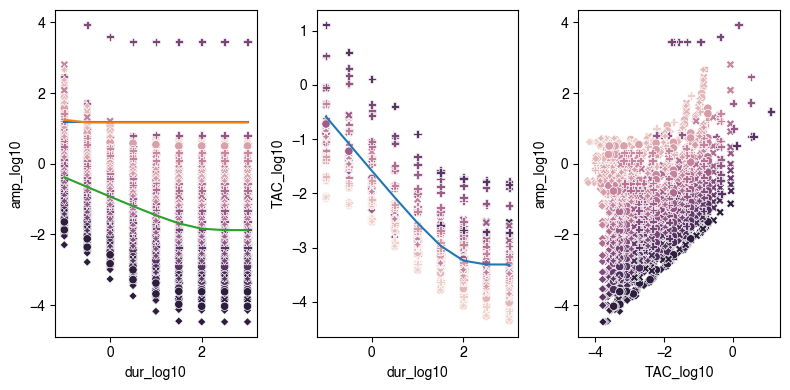

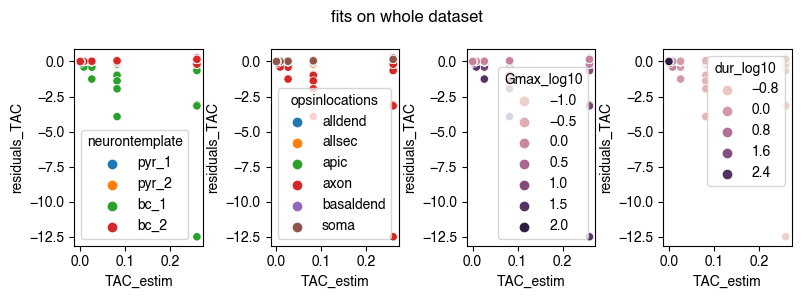

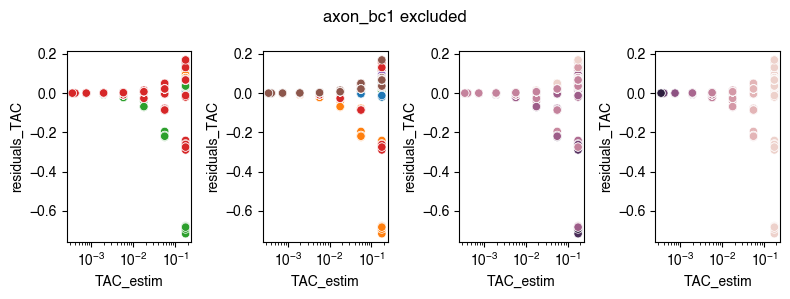

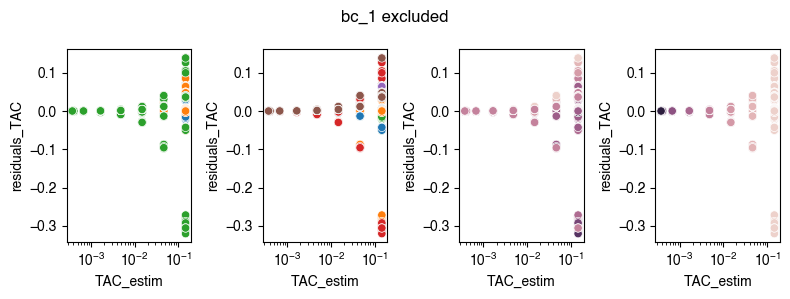

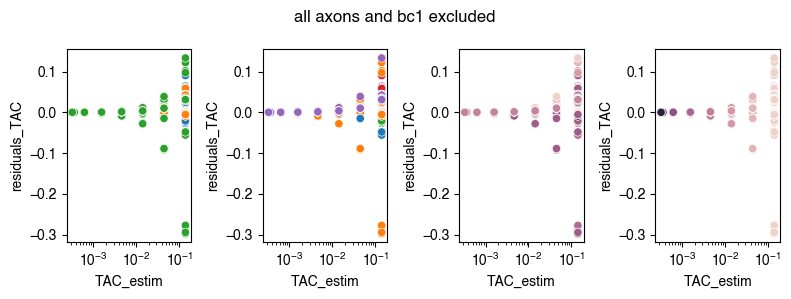

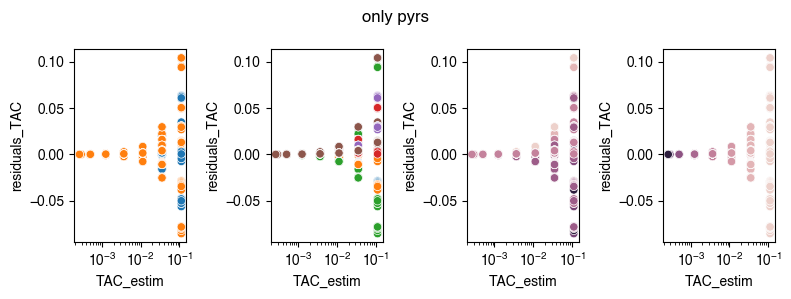

In [18]:
turn_off_legend = True
Hill_Lap = lambda pd,I0,tau: I0/(1-np.exp(-pd/tau))
vHill_Lap = np.vectorize(Hill_Lap)
power_ampTAC = lambda TAC,a,b,c: a*TAC**b+c
vpower_ampTAC = np.vectorize(power_ampTAC)

popt_TAC_hl, popt_amp_power, popt_amp_hl, popt_amp_loglog, r2_TAC, r2_amp_power, r2_amp_hl, r2_amp_loglog = durfit(master_df)
print(r2_TAC, r2_amp_power, r2_amp_hl, r2_amp_loglog)
print(popt_TAC_hl)
print(popt_amp_power)

fig,axs = plt.subplots(1,3,tight_layout = True,figsize=(8,4))
sns.scatterplot(data=master_df,x='dur_log10',y='amp_log10',hue='Gmax_log10',style='opsinlocations', ax=axs[0])
sns.scatterplot(data=master_df,x='dur_log10',y='TAC_log10', ax=axs[1],hue='Gmax_log10',style='opsinlocations')
sns.scatterplot(data=master_df,x='TAC_log10',y='amp_log10', ax=axs[2],hue='Gmax_log10',style='opsinlocations')
xvals = unique_values_columns_master['dur']
yvals = vHill_Lap(xvals,*popt_TAC_hl)
yvals_amp = vpower_ampTAC(yvals,*popt_amp_power)
yvals_amp_hl = vHill_Lap(xvals, *popt_amp_hl)
yvals_amp_loglog = popt_amp_loglog[0]*np.log10(yvals)+popt_amp_loglog[1]
print(yvals_amp)
axs[0].plot(np.log10(xvals),np.log10(yvals_amp))
axs[0].plot(np.log10(xvals),np.log10(yvals_amp_hl))
axs[0].plot(np.log10(xvals),yvals_amp_loglog)
axs[1].plot(np.log10(xvals),np.log10(yvals))
axs[0].get_legend().remove()
axs[1].get_legend().remove()
axs[2].get_legend().remove()

fig, axs = plt.subplots(1,4, figsize=(8,3), tight_layout=True)
TAC_estim = vHill_Lap(master_df['dur'],*popt_TAC_hl)
master_df['TAC_estim'] = TAC_estim
master_df['residuals_TAC'] = master_df['TAC_estim'] - master_df['TAC']
sns.scatterplot(master_df,x='TAC_estim',y='residuals_TAC',hue='neurontemplate',ax=axs[0])
sns.scatterplot(master_df,x='TAC_estim',y='residuals_TAC',hue='opsinlocations',ax=axs[1])
sns.scatterplot(master_df,x='TAC_estim',y='residuals_TAC',hue='Gmax_log10',ax=axs[2])
sns.scatterplot(master_df,x='TAC_estim',y='residuals_TAC',hue='dur_log10',ax=axs[3])
fig.suptitle('fits on whole dataset')

print('exclude bc1 axon')
idx = (master_df['neurontemplate']=='bc_1') & (master_df['opsinlocations']=='axon')
popt_TAC_hl, popt_amp_power, popt_amp_hl, popt_amp_loglog, r2_TAC, r2_amp_power, r2_amp_hl, r2_amp_loglog = durfit(master_df[~idx])
print(r2_TAC, r2_amp_power, r2_amp_hl, r2_amp_loglog)
TAC_estim = vHill_Lap(master_df['dur'],*popt_TAC_hl)
master_df['TAC_estim'] = TAC_estim
master_df['residuals_TAC'] = master_df['TAC_estim'] - master_df['TAC']
fig, axs = plt.subplots(1, 4, figsize=(8,3), tight_layout=True)
sns.scatterplot(master_df[~idx],x='TAC_estim',y='residuals_TAC',hue='neurontemplate',ax=axs[0])
sns.scatterplot(master_df[~idx],x='TAC_estim',y='residuals_TAC',hue='opsinlocations',ax=axs[1])
sns.scatterplot(master_df[~idx],x='TAC_estim',y='residuals_TAC',hue='Gmax_log10',ax=axs[2])
sns.scatterplot(master_df[~idx],x='TAC_estim',y='residuals_TAC',hue='dur_log10',ax=axs[3])
master_df.pop('TAC_estim')
master_df.pop('residuals_TAC')
for ax in axs.ravel():
    ax.set_xscale('log')
    if turn_off_legend:
        ax.get_legend().remove()
fig.suptitle('axon_bc1 excluded')

print('exclude bc1')
idx = (master_df['neurontemplate']=='bc_1')
popt_TAC_hl, popt_amp_power, popt_amp_hl, popt_amp_loglog, r2_TAC, r2_amp_power, r2_amp_hl, r2_amp_loglog = durfit(master_df[~idx])
print(r2_TAC, r2_amp_power, r2_amp_hl, r2_amp_loglog)
TAC_estim = vHill_Lap(master_df['dur'],*popt_TAC_hl)
master_df['TAC_estim'] = TAC_estim
master_df['residuals_TAC'] = master_df['TAC_estim'] - master_df['TAC']
fig, axs = plt.subplots(1, 4, figsize=(8,3), tight_layout=True)
sns.scatterplot(master_df[~idx],x='TAC_estim',y='residuals_TAC',hue='neurontemplate',ax=axs[0])
sns.scatterplot(master_df[~idx],x='TAC_estim',y='residuals_TAC',hue='opsinlocations',ax=axs[1])
sns.scatterplot(master_df[~idx],x='TAC_estim',y='residuals_TAC',hue='Gmax_log10',ax=axs[2])
sns.scatterplot(master_df[~idx],x='TAC_estim',y='residuals_TAC',hue='dur_log10',ax=axs[3])
master_df.pop('TAC_estim')
master_df.pop('residuals_TAC')
for ax in axs.ravel():
    ax.set_xscale('log')
    if turn_off_legend:
        ax.get_legend().remove()
fig.suptitle('bc_1 excluded')

print('exclude all axon and bc_1')
idx = (master_df['opsinlocations']=='axon') | (master_df['neurontemplate']=='bc_1')
popt_TAC_hl, popt_amp_power, popt_amp_hl, popt_amp_loglog, r2_TAC, r2_amp_power, r2_amp_hl, r2_amp_loglog = durfit(master_df[~idx])
print(r2_TAC, r2_amp_power, r2_amp_hl, r2_amp_loglog)
TAC_estim = vHill_Lap(master_df['dur'],*popt_TAC_hl)
master_df['TAC_estim'] = TAC_estim
master_df['residuals_TAC'] = master_df['TAC_estim'] - master_df['TAC']
fig, axs = plt.subplots(1, 4, figsize=(8,3), tight_layout=True)
sns.scatterplot(master_df[~idx],x='TAC_estim',y='residuals_TAC',hue='neurontemplate',ax=axs[0])
sns.scatterplot(master_df[~idx],x='TAC_estim',y='residuals_TAC',hue='opsinlocations',ax=axs[1])
sns.scatterplot(master_df[~idx],x='TAC_estim',y='residuals_TAC',hue='Gmax_log10',ax=axs[2])
sns.scatterplot(master_df[~idx],x='TAC_estim',y='residuals_TAC',hue='dur_log10',ax=axs[3])
master_df.pop('TAC_estim')
master_df.pop('residuals_TAC')
for ax in axs.ravel():
    ax.set_xscale('log')
    if turn_off_legend:
        ax.get_legend().remove()
fig.suptitle('all axons and bc1 excluded')

print('only pyrs')
idx = (master_df['neurontemplate']=='bc_2') | (master_df['neurontemplate']=='bc_1')
popt_TAC_hl, popt_amp_power, popt_amp_hl, popt_amp_loglog, r2_TAC, r2_amp_power, r2_amp_hl, r2_amp_loglog = durfit(master_df[~idx])
print(r2_TAC, r2_amp_power, r2_amp_hl, r2_amp_loglog)
TAC_estim = vHill_Lap(master_df['dur'],*popt_TAC_hl)
master_df['TAC_estim'] = TAC_estim
master_df['residuals_TAC'] = master_df['TAC_estim'] - master_df['TAC']
fig, axs = plt.subplots(1, 4, figsize=(8,3), tight_layout=True)
sns.scatterplot(master_df[~idx],x='TAC_estim',y='residuals_TAC',hue='neurontemplate',ax=axs[0])
sns.scatterplot(master_df[~idx],x='TAC_estim',y='residuals_TAC',hue='opsinlocations',ax=axs[1])
sns.scatterplot(master_df[~idx],x='TAC_estim',y='residuals_TAC',hue='Gmax_log10',ax=axs[2])
sns.scatterplot(master_df[~idx],x='TAC_estim',y='residuals_TAC',hue='dur_log10',ax=axs[3])
master_df.pop('TAC_estim')
master_df.pop('residuals_TAC')
for ax in axs.ravel():
    ax.set_xscale('log')
    if turn_off_legend:
        ax.get_legend().remove()
fig.suptitle('only pyrs')

### Heteroscedasticity (wikipedia)
**consequence**\
One of the assumptions of the classical linear regression model is that there is no heteroscedasticity. Breaking this assumption means that the Gauss–Markov theorem does not apply, meaning that OLS estimators are not the Best Linear Unbiased Estimators (BLUE) and their variance is not the lowest of all other unbiased estimators. Heteroscedasticity does not cause ordinary least squares coefficient estimates to be biased, although it can cause ordinary least squares estimates of the variance (and, thus, standard errors) of the coefficients to be biased, possibly above or below the true of population variance. Thus, regression analysis using heteroscedastic data will still provide an unbiased estimate for the relationship between the predictor variable and the outcome, but standard errors and therefore inferences obtained from data analysis are suspect. **Biased standard errors lead to biased inference, so results of hypothesis tests are possibly wrong. For example, if OLS is performed on a heteroscedastic data set, yielding biased standard error estimation, a researcher might fail to reject a null hypothesis at a given significance level, when that null hypothesis was actually uncharacteristic of the actual population (making a type II error).**

pyr_1_alldend 0.9998139152956034 0.09339008753346112 0.10946214226876749 0.11901700984474206
pyr_1_allsec 0.9997808041405623 0.09968583356343519 0.11708774106889719 0.17399143334118405
pyr_1_apic 0.999715120441369 0.0368443643494335 0.053469632891769425 0.1892616369255672
pyr_1_axon 0.9997802576111913 0.12050571024276091 0.13966741122916926 0.08984908629932553
pyr_1_basaldend 0.999527380828357 -0.027027027027069828 0.06544680301188621 0.13747050648537262
pyr_1_soma 0.9998321081370297 0.15450360933575735 0.17425350987240928 0.16903884612407427
pyr_2_alldend 0.9997800965263506 0.0871734576435137 0.10535747558734665 0.2428403523553907
pyr_2_allsec 0.9998341695234092 0.08472758759135224 0.10313525859032724 0.24139493856333494
pyr_2_apic 0.9998542204686367 0.1264560183527027 0.14503127636957536 0.14292096089752238
pyr_2_axon 0.9999225259899394 -0.03478260869583716 0.07871463325976591 0.17242655927388417
pyr_2_basaldend 0.999763987333767 0.11497563745570294 0.13145622379855615 0.145090613552

C:\Users\rschoete\AppData\Local\Temp\ipykernel_19956\2707688081.py:14: RuntimeWarning: overflow encountered in exp
  Hill_Lap = lambda pd,I0,tau: I0/(1-np.exp(-pd/tau))
c:\Users\rschoete\miniconda\envs\Optogx_analysis\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


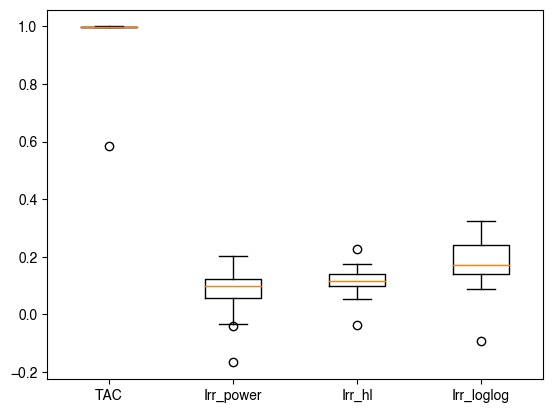

In [19]:
# fit TAC per model and opsinlocation
Hill_Lap = lambda pd,I0,tau: I0/(1-np.exp(-pd/tau))
vHill_Lap = np.vectorize(Hill_Lap)
power_ampTAC = lambda TAC,a,b,c: a*TAC**b+c
vpower_ampTAC = np.vectorize(power_ampTAC)

dur_fits = {}
master_df['nt_ol'] = master_df.apply(lambda row: f"{row['neurontemplate']}_{row['opsinlocations']}", axis= 1)
boxplot_data = np.zeros((len(master_df['nt_ol'].unique()),4))
for i, ntol in enumerate(master_df['nt_ol'].unique()):
    idx = master_df['nt_ol']==ntol
    popt_TAC_hl, popt_amp_power, popt_amp_hl, popt_amp_loglog, r2_TAC, r2_amp_power, r2_amp_hl, r2_amp_loglog = durfit(master_df[idx])
    dur_fits[ntol] = {'TAC': {'p':popt_TAC_hl, 'r2':r2_TAC}, 'amp_power': {'p':popt_amp_power, 'r2':r2_amp_power},
                      'amp_hl': {'p':popt_amp_hl,'r2':r2_amp_hl}, 'amp_loglog': {'p':popt_amp_loglog, 'r2':r2_amp_loglog}}
    master_df.loc[idx,'TAC_estim'] = TAC_estim = vHill_Lap(master_df.loc[idx,'dur'],*popt_TAC_hl)
    print(ntol,  r2_TAC, r2_amp_power, r2_amp_hl, r2_amp_loglog)
    boxplot_data[i,:] = [r2_TAC, r2_amp_power, r2_amp_hl, r2_amp_loglog]
plt.figure()
plt.boxplot(boxplot_data)
ax = plt.gca()
ax.set_xticklabels(['TAC','Irr_power','Irr_hl','Irr_loglog'])
master_df['TAC_estim_log10'] = np.log10(master_df['TAC_estim'])


Very high R2adj for TAC fits: variance due to duration only

In [20]:
#  the intercept in fits below is should now refer to pyr1_soma
master_df['nt_ol'] = master_df['nt_ol'].replace({'pyr_1_soma': 'a_pyr1_soma'})

idx_nan_inf = np.isnan(master_df['amp_log10']) | np.isinf(master_df['amp_log10']) | \
                np.isnan(master_df['TAC_estim_log10']) | np.isinf(master_df['TAC_estim_log10'])
double_linear_model = smf.ols(formula='amp_log10 ~ Gmax_log10 + TAC_estim_log10', data=master_df[~idx_nan_inf]).fit()
summary = double_linear_model.summary2()
print('summary multi linear model')
print(summary)

multi_linear_model = smf.ols(formula='amp_log10 ~ Gmax_log10 + TAC_estim_log10 + C(nt_ol)', data=master_df[~idx_nan_inf]).fit()
summary = multi_linear_model.summary2()
print('summary multi linear model')
print(summary)

md = smf.mixedlm("amp_log10 ~ Gmax_log10 + TAC_estim_log10", data=master_df[~idx_nan_inf], groups="nt_ol")
mdf = md.fit()
print('summary mixded multi linear model')
print(mdf.summary())

summary multi linear model
                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.880    
Dependent Variable: amp_log10        AIC:                2788.8827
Date:               2023-03-03 15:53 BIC:                2806.1564
No. Observations:   2340             Log-Likelihood:     -1391.4  
Df Model:           2                F-statistic:        8564.    
Df Residuals:       2337             Prob (F-statistic): 0.00     
R-squared:          0.880            Scale:              0.19256  
------------------------------------------------------------------
                  Coef.  Std.Err.     t     P>|t|   [0.025  0.975]
------------------------------------------------------------------
Intercept         1.1282   0.0258   43.7390 0.0000  1.0776  1.1788
Gmax_log10       -1.3851   0.0123 -112.4562 0.0000 -1.4093 -1.3609
TAC_estim_log10   0.6494   0.0091   71.3842 0.0000  0.6316  0.6672
-----------------------------------------------------

In [21]:
# extra testing
print('Gmax:nt_ol interaction')
print('-------------------------------------------\n')

multi_linear_model_interaction = smf.ols(formula='amp_log10 ~ Gmax_log10*C(nt_ol) + TAC_estim_log10 + C(nt_ol)', data=master_df[~idx_nan_inf]).fit()
summary = multi_linear_model_interaction.summary2()
print('summary multi linear model')
print(summary)
a_lm = anova_lm(multi_linear_model,multi_linear_model_interaction)
print(a_lm)
md_interaction = smf.mixedlm("amp_log10 ~ Gmax_log10 + TAC_estim_log10", data=master_df[~idx_nan_inf], groups="nt_ol", re_formula='~Gmax_log10')
mdf_interaction = md_interaction.fit()
print('summary mixded multi linear model')
print(mdf_interaction.summary())

print('\n\n\n')

print('Gmax:dur interaction')
print('-------------------------------------------\n')

multi_linear_model_interaction = smf.ols(formula='amp_log10 ~ Gmax_log10 + Gmax_log10:dur_log10 + TAC_estim_log10 + C(nt_ol)', data=master_df[~idx_nan_inf]).fit()
summary = multi_linear_model_interaction.summary2()
print('summary multi linear model')
print(summary)
a_lm = anova_lm(multi_linear_model,multi_linear_model_interaction)
print(a_lm)
md_interaction = smf.mixedlm("amp_log10 ~ Gmax_log10 + Gmax_log10:dur_log10 + TAC_estim_log10", data=master_df[~idx_nan_inf], groups="nt_ol")
mdf_interaction = md_interaction.fit()
print('summary mixded multi linear model')
print(mdf_interaction.summary())

print('\n\n\n')

Gmax:nt_ol interaction
-------------------------------------------

summary multi linear model
                            Results: Ordinary least squares
Model:                     OLS                     Adj. R-squared:            0.950    
Dependent Variable:        amp_log10               AIC:                       769.8080 
Date:                      2023-03-03 15:53        BIC:                       1005.8821
No. Observations:          2340                    Log-Likelihood:            -343.90  
Df Model:                  40                      F-statistic:               1114.    
Df Residuals:              2299                    Prob (F-statistic):        0.00     
R-squared:                 0.951                   Scale:                     0.079957 
---------------------------------------------------------------------------------------
                                        Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-----------------------------------------------------

c:\Users\rschoete\miniconda\envs\Optogx_analysis\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


C:\Users\rschoete\AppData\Local\Temp\ipykernel_6604\2707688081.py:14: RuntimeWarning: overflow encountered in exp
  Hill_Lap = lambda pd,I0,tau: I0/(1-np.exp(-pd/tau))
c:\Users\rschoete\miniconda\envs\Optogx_analysis\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


          r2_tot     r2_TAC      Irheo        Tau     a_Gmax      a_TAC  \
count  20.000000  20.000000  20.000000  20.000000  20.000000  20.000000   
mean    0.916769   0.978964   0.002128  40.437539  -1.485142   0.516198   
std     0.207517   0.093024   0.007344   9.511954   0.067874   0.088658   
min     0.035629   0.583751   0.000111  17.268901  -1.630053   0.204285   
25%     0.958856   0.999704   0.000252  38.937104  -1.517579   0.505775   
50%     0.963879   0.999781   0.000317  42.949133  -1.467726   0.533712   
75%     0.967564   0.999823   0.000436  44.477051  -1.443394   0.554322   
max     0.977540   0.999923   0.033245  55.054233  -1.400644   0.613271   

       intercept  
count  20.000000  
mean    1.001780  
std     0.570568  
min     0.427532  
25%     0.722200  
50%     0.950728  
75%     1.025158  
max     3.112068  
          r2_tot     r2_TAC      Irheo        Tau     a_Gmax      a_TAC  \
count  19.000000  19.000000  19.000000  19.000000  19.000000  19.000000   
mea

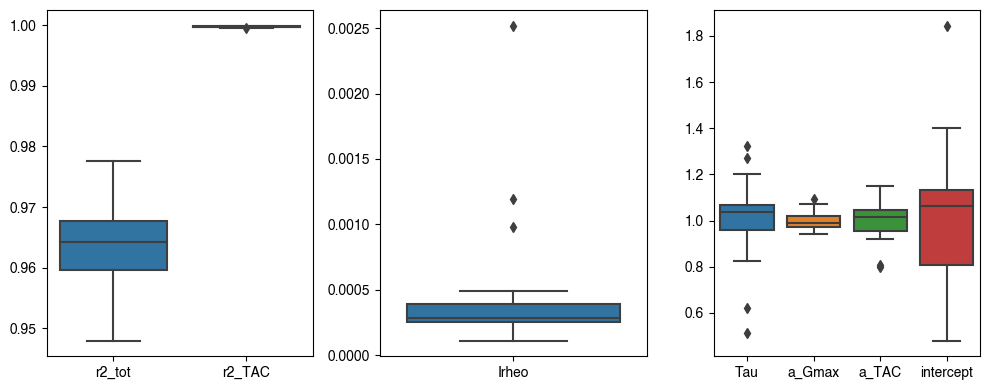

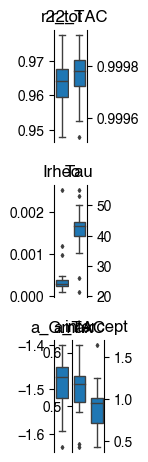

In [9]:
# neurontemplate opsinlocation specific dur and Gmax fit

# fit TAC per model and opsinlocation
Hill_Lap = lambda pd,I0,tau: I0/(1-np.exp(-pd/tau))
vHill_Lap = np.vectorize(Hill_Lap)
power_ampTAC = lambda TAC,a,b,c: a*TAC**b+c
vpower_ampTAC = np.vectorize(power_ampTAC)

fits = {}
master_df['nt_ol'] = master_df.apply(lambda row: f"{row['neurontemplate']}_{row['opsinlocations']}", axis= 1)
untol = master_df['nt_ol'].unique()
boxplot_data = np.zeros((len(untol),4))
for i, ntol in enumerate(untol):
    idx = master_df['nt_ol']==ntol
    intm_df = master_df[idx].copy()
    popt_TAC_hl, popt_amp_power, popt_amp_hl, popt_amp_loglog, r2_TAC, r2_amp_power, r2_amp_hl, r2_amp_loglog = durfit(intm_df)
    intm_df['TAC_estim'] = vHill_Lap(intm_df['dur'],*popt_TAC_hl)
    intm_df['TAC_estim_log10'] = np.log10(intm_df['TAC_estim'])

    r2adj_TAC = r2_TAC
    pIrheo = popt_TAC_hl[0]
    pTau = popt_TAC_hl[1]

    idx_nan_inf = np.isnan(intm_df['amp_log10']) | np.isinf(intm_df['amp_log10']) | \
                np.isnan(intm_df['TAC_estim_log10']) | np.isinf(intm_df['TAC_estim_log10'])
    double_linear_model = smf.ols(formula='amp_log10 ~ Gmax_log10 + TAC_estim_log10', data=intm_df[~idx_nan_inf]).fit()

    r2adj_tot = double_linear_model.rsquared_adj
    pa_Gl10 = double_linear_model.params['Gmax_log10']
    pa_TACl10 = double_linear_model.params['TAC_estim_log10']
    pc = double_linear_model.params['Intercept']

    fits[ntol] = dict(r2_tot=r2adj_tot, r2_TAC=r2adj_TAC, Irheo=pIrheo, Tau=pTau, a_Gmax=pa_Gl10, a_TAC=pa_TACl10, intercept=pc)

    #print(f"{ntol}:\n\tr2_tot:\t{r2adj_tot}\n\tr2_TAC:\t{r2adj_TAC}\n\tIrheo:\t{pIrheo}\n\tTau:\t{pTau}\n\ta_Gmax:\t{pa_Gl10}\n\ta_TAC:\t{pa_TACl10}\nintercept: \t{pc}")

myfit_df = pd.DataFrame(fits)
myfit_df = myfit_df.T
myfit_df.reset_index(inplace=True)
myfit_df = myfit_df.rename(columns={'index':'nt_ol'})
print(myfit_df.describe())
print(myfit_df[myfit_df['nt_ol']!='bc_1_axon'].describe())
fig, axs = plt.subplots(1,3,tight_layout=True,figsize=(10,4))
idx = myfit_df['nt_ol']!='bc_1_axon'
sns.boxplot(myfit_df.loc[idx,['r2_tot','r2_TAC']], ax=axs[0])
sns.boxplot(myfit_df.loc[idx,['Irheo']], ax=axs[1])
intm_df = myfit_df.loc[idx,['Tau','a_Gmax','a_TAC','intercept']].copy()
# intm_df['Irheo']*=1000
# intm_df['Tau']*=1/100
# intm_df['a_Gmax']*=-1
for key in intm_df.columns:
    intm_df[key]*=1/np.mean(intm_df[key])
sns.boxplot(intm_df, ax=axs[2])

fig = plt.figure(tight_layout=True, figsize=(4/2.54,12/2.54))
axs = []
gs0 = mpl.gridspec.GridSpec(3,1,figure=fig)
gs00 = gs0[0].subgridspec(1,3)
gs10 = gs0[1].subgridspec(1,3)
gs20 = gs0[2].subgridspec(1,3)
axs.append(fig.add_subplot(gs00[0]))
axs.append(fig.add_subplot(gs00[1]))
axs.append(fig.add_subplot(gs10[0]))
axs.append(fig.add_subplot(gs10[1]))
axs.append(fig.add_subplot(gs20[0]))
axs.append(fig.add_subplot(gs20[1]))
axs.append(fig.add_subplot(gs20[2]))
cols = [x for x in myfit_df.columns if not 'nt_ol'==x]


for i, (key, ax) in enumerate(zip(cols, axs)):
    print(key)
    sns.boxplot(myfit_df.loc[idx,[key]], ax=ax, fliersize=2,linewidth=1,saturation=1)
    ax.set_title(key)
    ax.set_xticks([])
    if i in [1,3,6]:
        ax.yaxis.tick_right()
        ax.spines[['top','left','bottom']].set_visible(False)
    else:
        ax.spines[['top','right','bottom']].set_visible(False)
fig.savefig('fit_dur_gmax.svg',dpi=300)

0.7747439488577419 0.06724641239460516 -0.001713062098512852 -0.0004190666642618357 0.1773393320712362
[4.88795868e-04 5.30700014e+01] [ 4.93507571 18.62748931 15.06271446] [14.71083791  0.0552735 ] [0.5486966127342381, -0.060834324623076697] Intercept     0.781298
Gmax_log10   -1.326465
dtype: float64
0.617157654713623 0.06724641239460516 -0.001713062098512852 -0.0004190666642618357 0.1773393320712362
[4.88795868e-04 5.30700014e+01] [ 4.93507571 18.62748931 15.06271446] [14.71083791  0.0552735 ] [0.5486966127342381, -0.060834324623076697] Intercept    -1.693837
Gmax_log10   -1.349937
dtype: float64


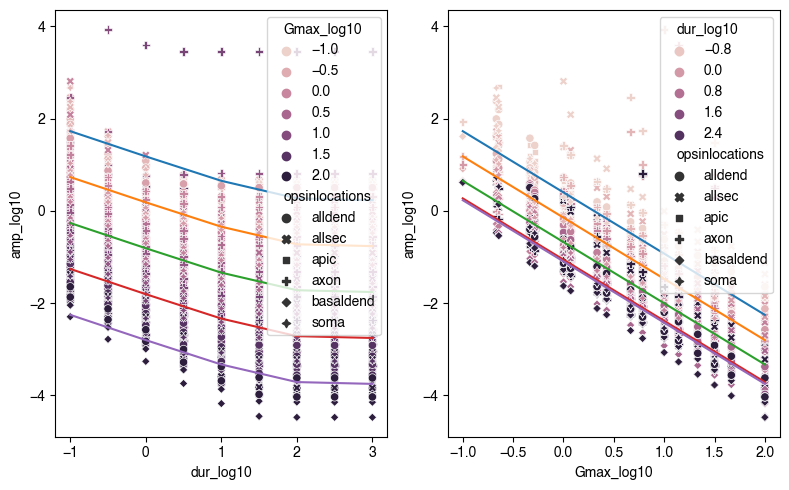

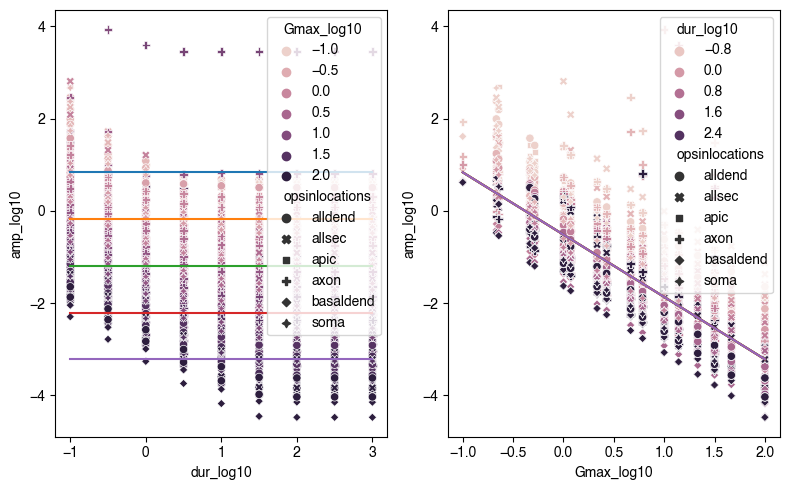

In [22]:
vmymodel, r2_tot, single_linear_model, popt_TAC_hl, popt_amp_power, popt_amp_hl, popt_amp_loglog, r2_TAC, r2_amp_power, r2_amp_hl, r2_amp_loglog = Gmaxfitafterdurfit(master_df,usedur='loglog')
fig,axs = plt.subplots(1,2,tight_layout = True,figsize=(8,5))
sns.scatterplot(data=master_df,x='dur_log10',y='amp_log10',hue='Gmax_log10',style='opsinlocations', ax=axs[0])
xdata_dur= np.logspace(-1,3,5)
xdata_gmax = np.logspace(-1,2,5)
for x in xdata_gmax:
    axs[0].plot(np.log10(xdata_dur), vmymodel(xdata_dur,x))
sns.scatterplot(data=master_df,x='Gmax_log10',y='amp_log10',hue='dur_log10',style='opsinlocations', ax=axs[1])
for x in xdata_dur:
    axs[1].plot(np.log10(xdata_gmax), vmymodel(x,xdata_gmax))
print(r2_tot, r2_TAC, r2_amp_power, r2_amp_hl, r2_amp_loglog)
print(popt_TAC_hl, popt_amp_power, popt_amp_hl, popt_amp_loglog,single_linear_model.params)

vmymodel, r2_tot, single_linear_model, popt_TAC_hl, popt_amp_power, popt_amp_hl, popt_amp_loglog, r2_TAC, r2_amp_power, r2_amp_hl, r2_amp_loglog = Gmaxfitafterdurfit(master_df,usedur='power')
fig,axs = plt.subplots(1,2,tight_layout = True,figsize=(8,5))
sns.scatterplot(data=master_df,x='dur_log10',y='amp_log10',hue='Gmax_log10',style='opsinlocations', ax=axs[0])
xdata_dur= np.logspace(-1,3,5)
xdata_gmax = np.logspace(-1,2,5)
for x in xdata_gmax:
    axs[0].plot(np.log10(xdata_dur), vmymodel(xdata_dur,x))
sns.scatterplot(data=master_df,x='Gmax_log10',y='amp_log10',hue='dur_log10',style='opsinlocations', ax=axs[1])
for x in xdata_dur:
    axs[1].plot(np.log10(xdata_gmax), vmymodel(x,xdata_gmax))
print(r2_tot, r2_TAC, r2_amp_power, r2_amp_hl, r2_amp_loglog)
print(popt_TAC_hl, popt_amp_power, popt_amp_hl, popt_amp_loglog,single_linear_model.params)

## Collect model fits for each neurontemplate and opsin combination

C:\Users\rschoete\AppData\Local\Temp\ipykernel_19956\2707688081.py:14: RuntimeWarning: overflow encountered in exp
  Hill_Lap = lambda pd,I0,tau: I0/(1-np.exp(-pd/tau))
c:\Users\rschoete\miniconda\envs\Optogx_analysis\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Irheo     tchron            pa         pb         pc     rico_g  \
count  20.000000  20.000000     20.000000  20.000000  20.000000  20.000000   
mean    0.002128  40.437539   1989.213539   2.850321   0.779191  -1.478324   
std     0.007344   9.511954   7903.389636   2.978945   1.666070   0.070741   
min     0.000111  17.268901     -0.121662   0.002155   0.010570  -1.630053   
25%     0.000252  38.937104     41.398621   1.503210   0.216040  -1.517579   
50%     0.000317  42.949133    163.319487   1.556358   0.394563  -1.457702   
75%     0.000436  44.477051    321.350464   2.070261   0.633487  -1.436902   
max     0.033245  55.054233  35549.693049  11.247232   7.746527  -1.365614   

               c   slopeamp       camp     r2_tot     r2_TAC  r2_amp_power  \
count  20.000000  20.000000  20.000000  20.000000  20.000000     20.000000   
mean    0.904869   0.558313   0.186264   0.907120   0.978964      0.076631   
std     0.349384   0.107121   0.382826   0.235467   0.093024      0.085582   
min     0.383830   0.291634  -0.128621  -0.092876   0.583751     -0.166660   
25%     0.646096   0.509393  -0.053391   0.954766   0.999704      0.058935   
50%     0.912441   0.556106   0.112249   0.961175   0.999781      0.098902   
75%     1.077211   0.637522   0.233036   0.963746   0.999823      0.121993   
max     1.642329   0.722157   1.617160   0.970020   0.999923      0.202207   

       r2_amp_hl  r2_amp_loglog         pa1e3  
count  20.000000      20.000000  2.000000e+01  
mean    0.116736       0.176996  1.989214e+06  
std     0.054175       0.090988  7.903390e+06  
min    -0.037037      -0.090938 -1.216624e+02  
25%     0.099373       0.141558  4.139862e+04  
50%     0.117191       0.170733  1.633195e+05  
75%     0.141008       0.241756  3.213505e+05  
max     0.228411       0.325156  3.554969e+07

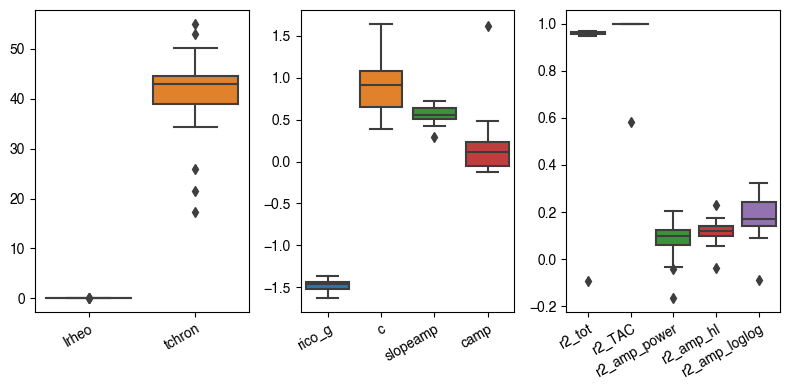

In [23]:
master_df['nt_ol'] = master_df['neurontemplate']+master_df['opsinlocations']
ukeys = master_df['nt_ol'].unique()
myfits_info_dict = {}
mymodels = {}
idx = -1
for nt_ol in ukeys:

    idx+=1
    intm_df = master_df[master_df['nt_ol']==nt_ol].copy()
    try:
        vmymodel, r2_tot, single_linear_model, popt_TAC_hl, popt_amp_power, popt_amp_hl, popt_amp_loglog, r2_TAC, r2_amp_power, r2_amp_hl, r2_amp_loglog = Gmaxfitafterdurfit(intm_df,usedur='loglog')
        data = intm_df[['dur','Gmax','amp']].to_numpy()
        data = data[np.lexsort((data[:, 0], data[:, 1])), :]
        durs = np.log10(np.unique(data[:,0]))
        Gmaxs = np.log10(np.unique(data[:,1]))
        Irr_log10 = np.log10(np.reshape(data[:,2],(len(Gmaxs),len(durs))))
        Irr_log10[np.isnan(Irr_log10)] = 3.5
        interp_model = lambda dur, Gmax: interpn((Gmaxs, durs), Irr_log10, (np.log10(Gmax), np.log10(dur)), method='nearest', bounds_error=False, fill_value=None)
        fit_info = {'Irheo':popt_TAC_hl[0], 'tchron': popt_TAC_hl[1], 'pa':popt_amp_power[0], 'pb':popt_amp_power[1], 'pc':popt_amp_power[2], 'rico_g':single_linear_model.params['Gmax_log10'], 'c':single_linear_model.params['Intercept'], 'slopeamp':popt_amp_loglog[0], 'camp': popt_amp_loglog[1], 'r2_tot':r2_tot,  'r2_TAC':r2_TAC, 'r2_amp_power':r2_amp_power, 'r2_amp_hl':r2_amp_hl,'r2_amp_loglog':r2_amp_loglog, 'neurontemplate':intm_df['neurontemplate'].iloc[0], 'opsinlocation':intm_df['opsinlocations'].iloc[0]}
        myfits_info_dict[idx] = fit_info
        mymodels[nt_ol] ={'model':vmymodel, 'model_interp': interp_model, 'statsmodel':single_linear_model, 'neurontemplate':intm_df['neurontemplate'].iloc[0], 'opsinlocation':intm_df['opsinlocations'].iloc[0]}
    except:
        print(f"error for fit of {nt_ol}")
models_df = pd.DataFrame.from_dict(myfits_info_dict, orient='index')
models_df['pa1e3'] = models_df['pa']*1000
fig,axs = plt.subplots(1,3,tight_layout = True, figsize = (8,4))
sns.boxplot(models_df[['Irheo','tchron']],ax=axs[0])
plt.setp(axs[0].get_xticklabels(), rotation=30, ha="right",
             rotation_mode="anchor")
sns.boxplot(models_df[['rico_g','c','slopeamp','camp']],ax=axs[1])
plt.setp(axs[1].get_xticklabels(), rotation=30, ha="right",
             rotation_mode="anchor")
sns.boxplot(models_df[[x for x in models_df.columns if 'r2' in x ]],ax=axs[2])
plt.setp(axs[2].get_xticklabels(), rotation=30, ha="right",
             rotation_mode="anchor")
models_df[[x for x in models_df.columns if not '_mu' in x]].describe()

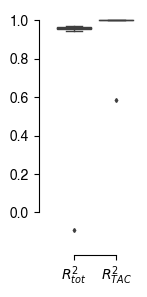

In [24]:
fig,ax = plt.subplots(1,1,tight_layout = True, figsize = (4/2.54,7.8/2.54))
sns.boxplot(models_df[['r2_tot','r2_TAC']],ax=ax,fliersize=2,linewidth=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels(['$R^2_{tot}$','$R^2_{TAC}$'])
sns.despine(offset=10, trim=True,ax=ax)
fig.savefig('r2.svg')

# Impedance

In [25]:
from Model import Cells
from neuron import h
h.nrn_load_dll("./Model/Mods/nrnmech.dll")
print("succes load nrnmech.dll")
neurontemplate = Cells.NeuronTemplates[0]
print(f'Loading cell: {neurontemplate}')
cell = getattr(Cells, neurontemplate)(replace_axon=False)
#cell2 = getattr(Cells, NeuronTemplates[1])(replace_axon=False)
print(f'\t* celltype: {cell.celltype}\n\t* morphology: {cell.morphology}')

# cell.insertOptogenetics(cell.alldend)
cell.rotate_Cell(theta=-np.pi/2)
# cell2.rotate_Cell(theta=-np.pi/2)
#cell2.move_Cell([0, 100, 0])


succes load nrnmech.dll
Loading cell: CA1_PC_cAC_sig5
not replacing axon
	* celltype: SP_PC
	* morphology: mpg141208_B_idA


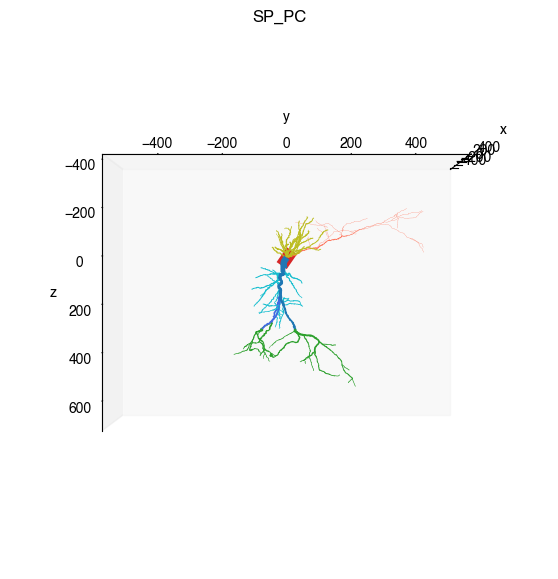

In [26]:

# section Plot
fig = plt.figure(figsize=(7, 7))
ax = plt.subplot(111, projection='3d')
ax = cell.sec_plot(ax)
#ax = cell2.sec_plot(ax)
ax.set_title(cell.celltype)
ax.set_zlim([-400, 700])
ax.set_xlim([-500, 500])
ax.set_ylim([-550, 550])
ax.invert_zaxis()
ax.view_init(elev=0, azim=0)
ax.get_legend().remove()

In [27]:
import Functions.globalFunctions.morphology_v2 as mphv2
%matplotlib inline

In [28]:
imp_df_dict = {}
for k,v in {'pyr_1':'CA1_PC_cAC_sig5','pyr_2':'CA1_PC_cAC_sig6','bc_1':'cNACnoljp1','bc_2':'cNACnoljp2'}.items():
    imp_df_dict[k] = pd.read_csv(f'./Results/impedance_{v}.csv',index_col=0)
    groups = imp_df_dict[k]['seg'].str.split('[',1,expand=True)
    imp_df_dict[k]['group'] = groups[0]
    imp_df_dict[k]['cell']=k
    if k in ['pyr_1', 'pyr_2']:
        imp_df_dict[k]['group'] = imp_df_dict[k]['group'].replace({'dend':'basal'})

labels = np.array(['soma','apic','basal','axon'])
imp_df_dict[k]

imp    f  v0  durinit neurontemplate             seg group  cell
0       49.116835    0 -70      100     cNACnoljp2    soma[0](0.5)  soma  bc_2
1       50.418803    1 -70      100     cNACnoljp2    soma[0](0.5)  soma  bc_2
2       65.696476   10 -70      100     cNACnoljp2    soma[0](0.5)  soma  bc_2
3       20.732937  100 -70      100     cNACnoljp2    soma[0](0.5)  soma  bc_2
4       49.181793    0 -70      100     cNACnoljp2    axon[0](0.5)  axon  bc_2
...           ...  ...  ..      ...            ...             ...   ...   ...
6903   651.068554  100 -70      100     cNACnoljp2  dend[133](0.5)  dend  bc_2
6904  1126.078498    0 -70      100     cNACnoljp2  dend[134](0.5)  dend  bc_2
6905  1128.774359    1 -70      100     cNACnoljp2  dend[134](0.5)  dend  bc_2
6906  1164.900581   10 -70      100     cNACnoljp2  dend[134](0.5)  dend  bc_2
6907  1020.861130  100 -70      100     cNACnoljp2  dend[134](0.5)  dend  bc_2

[6908 rows x 8 columns]

In [29]:
imp_df = imp_df_dict['pyr_1'].copy()
for v in imp_df_dict.values():
    imp_df = pd.concat((imp_df,v))

print(imp_df.describe())
imp_df['imp_log10'] = np.log10(imp_df['imp'])



                imp            f       v0  durinit
count  29852.000000  29852.00000  29852.0  29852.0
mean    1438.041698     27.75000    -70.0    100.0
std     2601.123332     41.89566      0.0      0.0
min       13.755867      0.00000    -70.0    100.0
25%      333.292259      0.75000    -70.0    100.0
50%      590.405354      5.50000    -70.0    100.0
75%     1168.780267     32.50000    -70.0    100.0
max    28086.434481    100.00000    -70.0    100.0


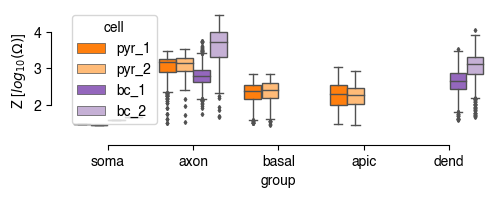

In [30]:
fig,ax = plt.subplots(1,1, figsize=(14/2.54,4/2.54))

sns.boxplot(imp_df[imp_df['f']==0],x='group',y='imp_log10',hue='cell',ax=ax,palette=colorkeyval,dodge=True,fliersize=2,linewidth=1,saturation=1)
ax.set_ylabel('Z [$log_{10}(\Omega)$]')
sns.despine(offset=10, trim=True,ax=ax)
fig.savefig('impedance.svg')

0.25769506068233955
0.5153901213646791
CA1_PC_cAC_sig5[0].soma[0]


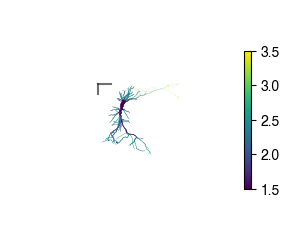

In [31]:
def set_size(w, h, ax=None):
    """ w, h: width, height in inches """
    if not ax:
        ax = plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw/2.54, figh/2.54)
pttocm = 0.0352777778
scale_diams = 4/pttocm/1100*5
scale_diams_list = [scale_diams]*len(cell.allsec)
scale_diams_list[-1] = scale_diams_list[-1]/2
print(scale_diams_list[-1])
print(scale_diams)
print(cell.allsec[0])
fig = plt.figure(figsize=(7/2.54,7/2.54))
ax = plt.subplot(111, projection='3d')
cvals = np.array(imp_df_dict['pyr_1'][imp_df_dict['pyr_1']['f']==0]['imp'])
mphv2.shapeplot(h, ax, sections=cell.allsec[::-1], cvals=cvals[::-1], cvals_type=None,
              clim=[10**1.5,10**3.5], cmap='viridis', cb_flag=True, colorscale='log10', fontSize=12, legend=True, cbax=None,scale_diams=scale_diams_list)
ax.set_zlim([-400, 700])
ax.set_xlim([-550, 550])
ax.set_ylim([-550, 550])
ax.invert_zaxis()
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.plot([-200,-200], [-200,-100], zs=0, zdir='x',color = [0.2,0.2,0.2],alpha = 0.7)
ax.plot([-200,-100],[-200,-200], zs=0, zdir='x',color = [0.2,0.2,0.2],alpha = 0.7)
ax.view_init(elev=0, azim=0)
set_size(7,7,ax)
fig.savefig('cell_imp.svg')


# Estimate VTA surfaces

In [32]:
def estim_surfvta(dur,Gmax,model,intensity,field_axialsymm,dr,dz,):
    target_amp_log10 = model(dur,Gmax)
    target_amp = 10**target_amp_log10

    myfield = intensity*field_axialsymm
    above_target = myfield>=target_amp
    surf = np.sum(above_target.ravel()*dr*dz)

    return surf
#load optic field
fieldFilePath = "Inputs/LightIntensityProfile/Ugent470nIrr_np1e7_res5emin3_gf1_cyl_5x10.txt"
opticField = np.genfromtxt(fieldFilePath, comments='%')
dr = np.diff(np.unique(opticField[:,0])[:2])/1000 #/1000 um->mm
dz = np.diff(np.unique(opticField[:,1])[:2])/1000 #/1000 um->mm
print(dr,dz)
opticField_ds = EcF.prepareDataforInterp(data = opticField, method = 'ninterp', sorted = False)

[0.005] [0.005]


C:\Users\rschoete\AppData\Local\Temp\ipykernel_19956\2496428913.py:31: RuntimeWarning: divide by zero encountered in log10
  axs[0].pcolormesh(rR,zZ,np.log10(IrrField))


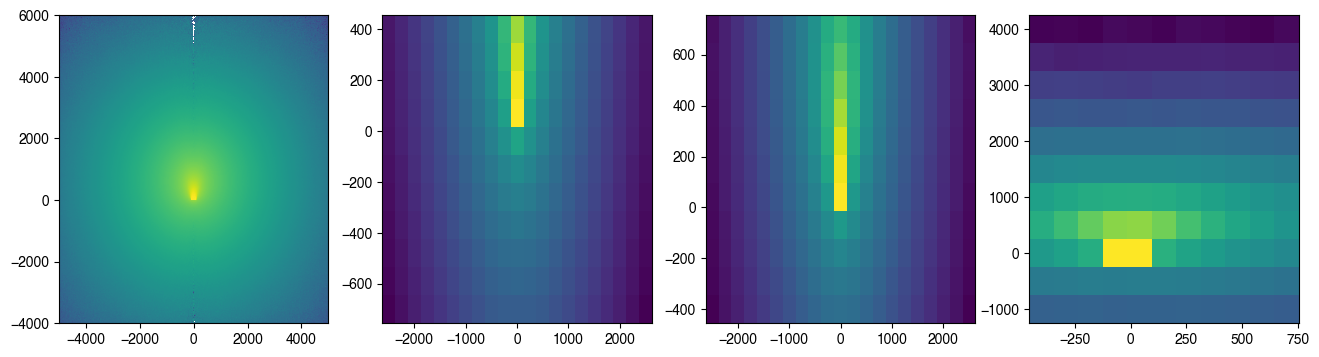

In [33]:
# downsample optic fields
opticField_ds = EcF.prepareDataforInterp(data = opticField, method = 'ninterp', sorted = False)

rpos = opticField_ds[0]
zpos =opticField_ds[1]
IrrField = opticField_ds[2] # IrrField is 'ij'

rpos = np.concatenate((-rpos[-1:0:-1],rpos))
IrrField = np.vstack((IrrField[-1:0:-1,:], IrrField))
rR,zZ = np.meshgrid(rpos, zpos, indexing='ij')

zpos_ds_pos = np.arange(-400,810,110)
rpos_ds_pos = np.arange(-2500,2750,250)
rR_ds_pos, zZ_ds_pos  = np.meshgrid(rpos_ds_pos, zpos_ds_pos)
IrrField_ds_radial_pos = interpn((rpos,zpos),IrrField,(rR_ds_pos.ravel(),zZ_ds_pos.ravel()))
IrrField_ds_radial_pos = np.reshape(IrrField_ds_radial_pos,(11,21))

zpos_ds_neg = np.arange(-700,510,110)
rs_ds_neg = np.arange(-2500,2750,250)
rR_ds_neg, zZ_ds_neg  = np.meshgrid(rs_ds_neg, zpos_ds_neg)
IrrField_ds_radial_neg = interpn((rpos,zpos),IrrField,(rR_ds_neg.ravel(),zZ_ds_neg.ravel()))
IrrField_ds_radial_neg = np.reshape(IrrField_ds_radial_neg,(11,21))

rs_ds_0 = np.arange(-400,810,110)
zpos_ds_0 = np.arange(-1000,4500,500)
rR_ds_0, zZ_ds_0  = np.meshgrid(rs_ds_0, zpos_ds_0)
IrrField_ds_0 = interpn((rpos, zpos),IrrField,(rR_ds_0.ravel(), zZ_ds_0.ravel()))
IrrField_ds_0 = np.reshape(IrrField_ds_0,(11,11))

fig,axs = plt.subplots(1,4, figsize=(16,4))
axs[0].pcolormesh(rR,zZ,np.log10(IrrField))
axs[1].pcolormesh(rR_ds_neg,zZ_ds_neg,np.log10(IrrField_ds_radial_neg))
axs[2].pcolormesh(rR_ds_pos,zZ_ds_pos,np.log10(IrrField_ds_radial_pos))
axs[3].pcolormesh(rR_ds_0,zZ_ds_0,np.log10(IrrField_ds_0))

opticField_ds_radial_neg = np.array([rR_ds_neg.ravel(), zZ_ds_neg.ravel(), IrrField_ds_radial_neg.ravel()]).T
opticField_ds_radial_pos = np.array([rR_ds_pos.ravel(), zZ_ds_pos.ravel(), IrrField_ds_radial_pos.ravel()]).T
opticField_ds_0 = np.array([rR_ds_0.ravel(), zZ_ds_0.ravel(), IrrField_ds_0.ravel()]).T

In [34]:
#load effective vta surfaces
filepath_vta = './Results\SDC\SDC_singlePulse_Ugent470_gray_invivo_multicell'
vta_filename = 'vta_logspace(-1,3,9)3.csv'
vta_df =  pd.read_csv(os.path.join(filepath_vta, vta_filename), index_col=0)
vta_df_original = vta_df.copy()
vta_df.head()
for x in ['Gmax','dur','level','theta_0']:
    vta_df[x] = np.round(vta_df[x],4)

for x in ['vta_low','vta_up','surf_low','surf_up','dur','Gmax','level']:
    vta_df[x+'_log10'] = np.round(np.log10(vta_df[x]),4)
vta_df['neurontemplate'].unique()

vta_df['neurontemplate'] = vta_df['neurontemplate'].replace({'CA1_PC_cAC_sig5':'pyr_1', 'CA1_PC_cAC_sig6':'pyr_2', 'cNACnoljp1':'bc_1', 'cNACnoljp2':'bc_2'})
vta_df[['celltype','number']] = vta_df['neurontemplate'].str.split('_',expand=True)
vta_columns=vta_df.columns


unique_values_columns_vta = {key: vta_df[key].unique() for key in vta_columns}
for x in ['vta_low','vta_up','surf_low','surf_up','dur','Gmax','level']:
    unique_values_columns_vta[x] = np.sort(unique_values_columns_vta[x])
    unique_values_columns_vta[x+'_log10'] = np.sort(unique_values_columns_vta[x+'_log10'])





c:\Users\rschoete\miniconda\envs\Optogx_analysis\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\rschoete\miniconda\envs\Optogx_analysis\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\rschoete\miniconda\envs\Optogx_analysis\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\rschoete\miniconda\envs\Optogx_analysis\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [39]:
estim_surfaces_interp = []
a = np.zeros((len(vta_df)))
a.fill(np.nan)
vta_df['surf_estim'] = a
vta_df['surf_estim_hr'] = a
dr_of = np.diff(np.unique(opticField[:,0])[:2])/1000 #/1000 um->mm
dz_of = np.diff(np.unique(opticField[:,1])[:2])/1000 #/1000 um->mm
for i in range(len(vta_df)):
    if i%3000 ==0:
        print(i)
    pitch = vta_df['theta_0'].iloc[i]
    intensity = vta_df['level'].iloc[i]
    Gmax = vta_df['Gmax'].iloc[i]
    dur = vta_df['dur'].iloc[i]
    nt = vta_df['neurontemplate'].iloc[i]
    ol = vta_df['opsinlocations'].iloc[i]
    nt_ol = nt+ol
    # interp method
    model =  mymodels[nt_ol]['model_interp']
    target_amp = master_df['amp'][selection_generator(master_df, unique_values_columns_master, Gmax=Gmax, dur=dur, neurontemplate=nt, opsinlocations=ol)].to_numpy()[0]


    if pitch <0:
        dr = 0.250
        dz = 0.110

        # downsampled field (same stepsizes as gridsearch of surf_avg)
        myfield = intensity*opticField_ds_radial_neg[:,-1]
        above_target = myfield>=target_amp
        estim_surf = np.sum(above_target.ravel()*dr*dz)

        # high res field
        idx_field = (opticField[:,1]>=-700) & (opticField[:,1]<=400) & (opticField[:,0]<=2500)
        myfield = intensity*opticField[idx_field,-1]
        above_target = myfield>=target_amp
        estim_surf_hr = 2*np.sum(above_target.ravel()*dr_of*dz_of)
    elif pitch > 0:
        dr = 0.250
        dz = 0.110

        # downsampled field (same stepsizes as gridsearch of surf_avg)
        myfield = intensity*opticField_ds_radial_pos[:,-1]
        above_target = myfield>=target_amp
        estim_surf = np.sum(above_target.ravel()*dr*dz)

        # high res field
        idx_field = (opticField[:,1]>=-400) & (opticField[:,1]<=700) & (opticField[:,0]<=2500)
        myfield = intensity*opticField[idx_field,-1]
        above_target = myfield>=target_amp
        estim_surf_hr = 2*np.sum(above_target.ravel()*dr_of*dz_of)
    else:
        dr = 0.110
        dz = 0.500

        # downsampled field (same stepsizes as gridsearch of surf_avg)
        myfield = intensity*opticField_ds_0[:,-1]
        above_target = myfield>=target_amp
        estim_surf = np.sum(above_target.ravel()*dr*dz)

        #high res field
        idx_field = (opticField[:,1]>=-1000) & (opticField[:,1]<=5000) & (opticField[:,0]<=700)
        field = opticField[idx_field,-1]
        idx_field = (opticField[:,1]>=-1000) & (opticField[:,1]<=5000) & (opticField[:,0]<=400)
        field = np.concatenate((field,opticField[idx_field,-1]))
        myfield = intensity*field
        above_target = myfield>=target_amp
        estim_surf_hr = np.sum(above_target.ravel()*dr_of*dz_of)
    vta_df['surf_estim'].iloc[i] = estim_surf
    vta_df['surf_estim_hr'].iloc[i] = estim_surf_hr

0


C:\Users\rschoete\AppData\Local\Temp\ipykernel_19956\2505634572.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vta_df['surf_estim'].iloc[i] = estim_surf
C:\Users\rschoete\AppData\Local\Temp\ipykernel_19956\2505634572.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vta_df['surf_estim_hr'].iloc[i] = estim_surf_hr


3000
6000
9000
12000
15000


In [40]:
# Save
vta_df.to_csv(os.path.join(filepath_vta, 'vta_logspace(-1,3,9)3_westim3.csv'))

(0.9999860921949659, 0.0)
(0.9971619758938706, 0.0)


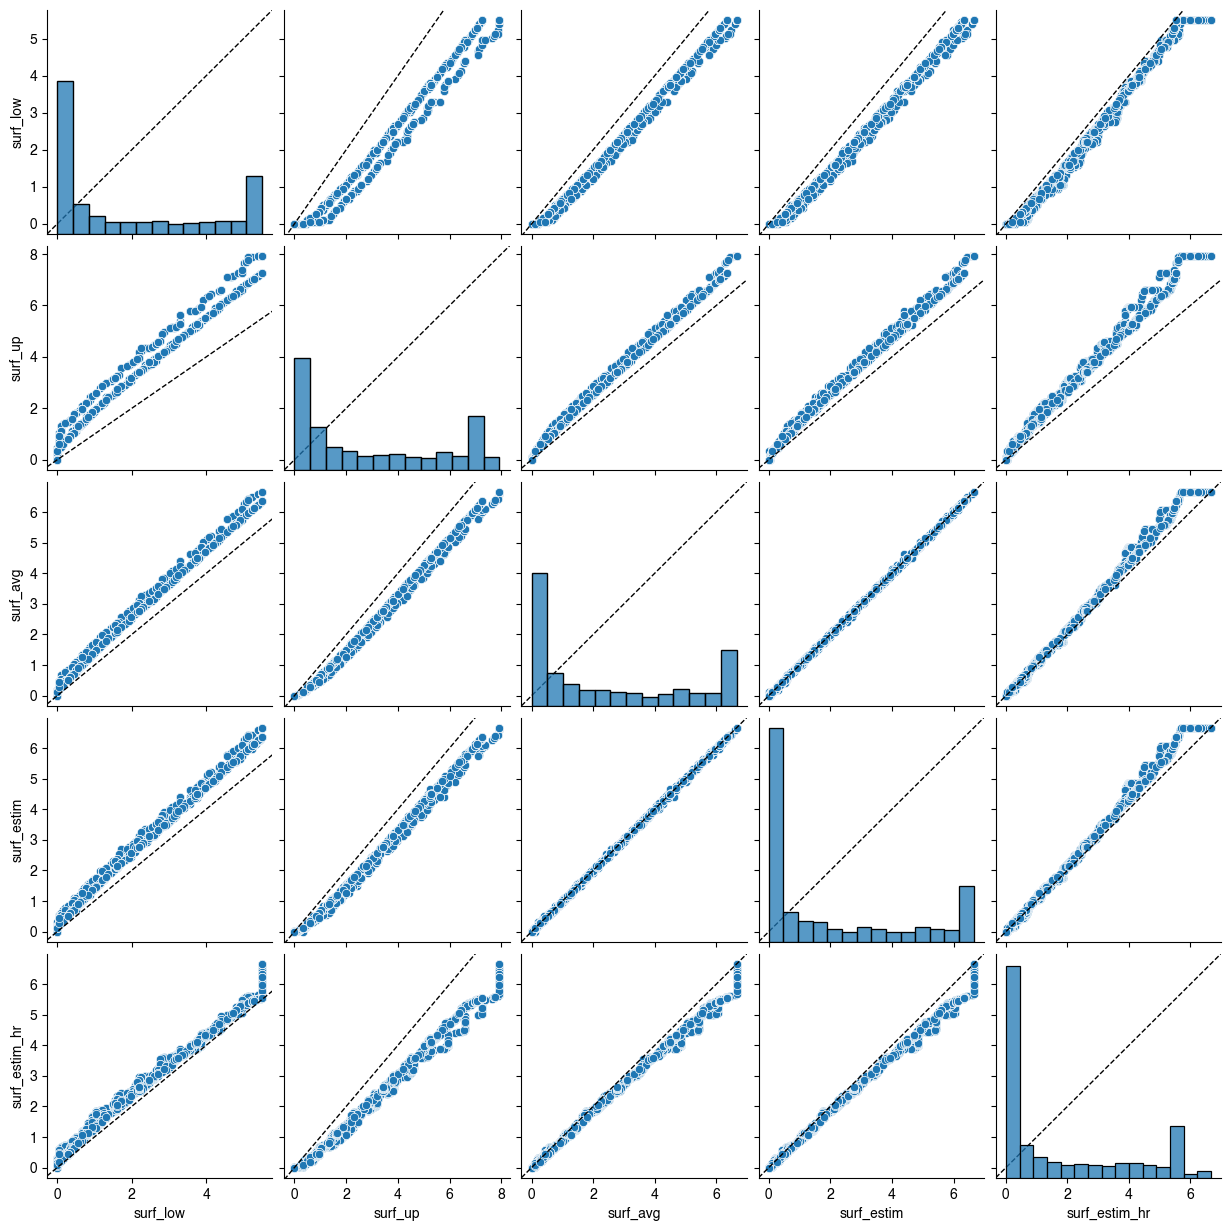

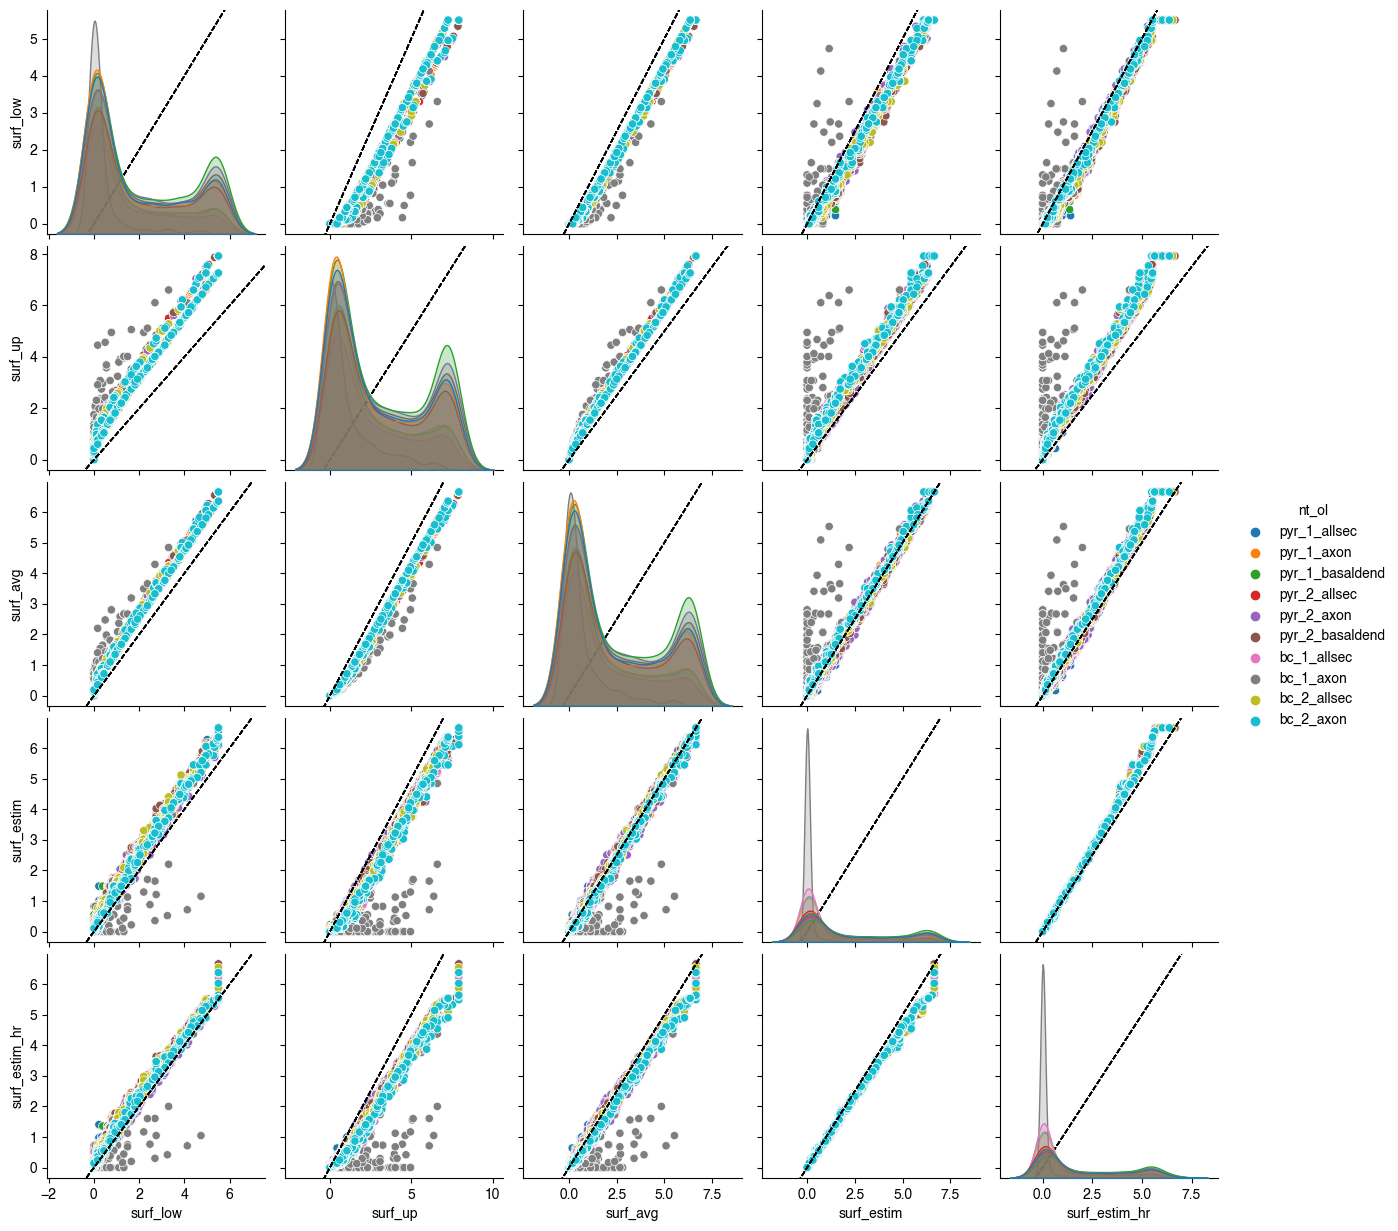

In [41]:
vta_df['nt_ol'] = vta_df.apply(lambda row: f"{row['neurontemplate']}_{row['opsinlocations']}", axis=1)
idx = (vta_df['opsinlocations']=='soma')
g = sns.pairplot(vta_df[['surf_low','surf_up', 'surf_avg', 'surf_estim', 'surf_estim_hr', 'opsinlocations','neurontemplate']][idx])
def modify_plot(*args, **kwargs):
  if "ax" in kwargs:
    ax = kwargs['ax']
  else:
    ax = plt.gca()
  xpoints = ypoints = ax.get_xlim()
  ax.plot(xpoints, ypoints, linestyle='--', color='k', lw=1, scalex=False, scaley=False)
g.map(modify_plot)
x = vta_df.loc[idx,'surf_avg'].to_numpy()
y = vta_df.loc[idx,'surf_estim'].to_numpy()
idx = ~ (np.isnan(x) |  np.isinf(x) | np.isnan(y) | np.isinf(y))
print(stats.pearsonr(x[idx],y[idx]))

idx = vta_df['opsinlocations']!='soma'
g = sns.pairplot(vta_df[['surf_low','surf_up', 'surf_avg', 'surf_estim', 'surf_estim_hr','nt_ol']][idx],hue='nt_ol')
def modify_plot(*args, **kwargs):
  if "ax" in kwargs:
    ax = kwargs['ax']
  else:
    ax = plt.gca()
  xpoints = ypoints = ax.get_xlim()
  ax.plot(xpoints, ypoints, linestyle='--', color='k', lw=1, scalex=False, scaley=False)

g.map(modify_plot)
x = vta_df['surf_avg'].to_numpy()
y = vta_df['surf_estim'].to_numpy()
idx = ~ (np.isnan(x) |  np.isinf(x) | np.isnan(y) | np.isinf(y))
print(stats.pearsonr(x[idx],y[idx]))


# Extra plots

In [38]:

ress_dict['amp_log10']['all'] = ress[0]
ress_dict['TAC_log10']['all'] = ress[1]
for cell in unique_values_columns_master['neurontemplate']:
    intm_df = master_df[master_df['neurontemplate']==cell]
    fig,axs = plt.subplots(1,2,tight_layout = True,figsize=(8,5))
    print('\n\n',cell)
    ress = linearReg(intm_df,['amp_log10','TAC_log10'],axs,filteronthreshold)
    fig.suptitle(cell)
    ress_dict['amp_log10'][cell] = ress[0]
    ress_dict['TAC_log10'][cell] = ress[1]




NameError: name 'ress' is not defined

In [ ]:

plot_flag = False
for clas,label in zip(['opsinlocations','dur'],['oL','dur']):
    if plot_flag:
        fig,axs = plt.subplots(1,2,tight_layout = True,figsize=(8,5))
    filteronthreshold = True
    intm_df = master_df.copy()
    for dur in unique_values_columns_master[clas]:
        for feat in features:
            idx = intm_df[clas]==dur
            intm_df[feat].loc[idx] = (intm_df[feat][idx]-np.mean(intm_df[feat][idx]))/np.std(intm_df[feat][idx])
    ress = linearReg(intm_df,['amp_log10','TAC_log10'],axs,filteronthreshold,plot_flag=plot_flag)
    ress_dict['amp_log10']['all_norm'+label] = ress[0]
    ress_dict['TAC_log10']['all_norm'+label] = ress[1]
    for cell in unique_values_columns_master['neurontemplate']:
        intm2_df = intm_df[intm_df['neurontemplate']==cell]
        if plot_flag:
            fig,axs = plt.subplots(1,2,tight_layout = True,figsize=(8,5))
        print('\n\n',cell)
        ress = linearReg(intm2_df,['amp_log10','TAC_log10'],axs,True,plot_flag=plot_flag)
        fig.suptitle(cell)
        ress_dict['amp_log10'][cell+'_norm'+label] = ress[0]
        ress_dict['TAC_log10'][cell+'_norm'+label] = ress[1]

init_df = True
for mk in ress_dict.keys():
    for k in ress_dict[mk]:
        if init_df:
            index = pd.MultiIndex.from_tuples([(mk,k)], names=["feat", "template"])
            df = pd.DataFrame(ress_dict[mk][k],index=index)
            init_df=False
        else:
            index = pd.MultiIndex.from_tuples([(mk,k)], names=["feat", "template"])
            df = pd.concat((df,pd.DataFrame(ress_dict[mk][k],index=index)),axis=0)

df.sort_index()
df.reset_index()

C:\Users\rschoete\AppData\Local\Temp\ipykernel_11660\1015072895.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intm_df[feat].loc[idx] = (intm_df[feat][idx]-np.mean(intm_df[feat][idx]))/np.std(intm_df[feat][idx])



amp_log10
Rsquared: 0.6392334596602804
slope (95%): -1.002396 +/- 0.054236
intercept (95%): 0.566897 +/- 0.053030

TAC_log10
Rsquared: 0.0014463804607158385
slope (95%): -0.046315 +/- 0.087645
intercept (95%): 0.227573 +/- 0.085696


 pyr_1

amp_log10
Rsquared: 0.6697222970722716
slope (95%): -0.998904 +/- 0.089198
intercept (95%): 0.464669 +/- 0.088582

TAC_log10
Rsquared: 0.00041826411238458835
slope (95%): -0.023483 +/- 0.145972
intercept (95%): 0.096030 +/- 0.144964


 pyr_2

amp_log10
Rsquared: 0.6633110352111644
slope (95%): -1.007107 +/- 0.094261
intercept (95%): 0.650287 +/- 0.094607

TAC_log10
Rsquared: 0.0010138358682208115
slope (95%): -0.038579 +/- 0.159092
intercept (95%): 0.259442 +/- 0.159676


 bc_1

amp_log10
Rsquared: 0.6520747986775535
slope (95%): -1.084775 +/- 0.135385
intercept (95%): 0.611554 +/- 0.127994

TAC_log10
Rsquared: 0.017137372676947576
slope (95%): -0.173753 +/- 0.224824
intercept (95%): 0.360745 +/- 0.212551


 bc_2

amp_log10
Rsquared: 0.55860558859

feat       template     slope  intercept    rvalue         pvalue  \
0   amp_log10            all -1.391537  -5.127653 -0.958390   0.000000e+00   
1   amp_log10          pyr_1 -1.398038  -0.794720 -0.863667   2.347981e-73   
2   amp_log10          pyr_2 -1.426128  -0.532980 -0.866169   1.016009e-69   
3   amp_log10           bc_1 -1.516455  -0.505377 -0.857546   1.653376e-40   
4   amp_log10           bc_2 -1.358017  -0.495092 -0.850387   2.596427e-40   
5   amp_log10     all_normoL -1.002396   0.566897 -0.799521  1.182208e-166   
6   amp_log10   pyr_1_normoL -0.998904   0.464669 -0.818366   1.156285e-59   
7   amp_log10   pyr_2_normoL -1.007107   0.650287 -0.814439   4.234392e-55   
8   amp_log10    bc_1_normoL -1.084775   0.611554 -0.807511   1.615457e-32   
9   amp_log10    bc_2_normoL -0.946466   0.582573 -0.747399   2.807336e-26   
10  amp_log10    all_normdur -1.213985   0.686559 -0.968286   0.000000e+00   
11  amp_log10  pyr_1_normdur -1.202742   0.528743 -0.971854  1.093761e-152   
12  amp_log10  pyr_2_normdur -1.225097   0.753165 -0.977500  4.662560e-154   
13  amp_log10   bc_1_normdur -1.279120   0.756307 -0.985144  2.057424e-104   
14  amp_log10   bc_2_normdur -1.181263   0.803430 -0.964450   1.226081e-81   
15  TAC_log10            all  0.077792  -0.069122  0.352379   3.342473e-23   
16  TAC_log10          pyr_1  0.046280   2.298075  0.039170   5.442344e-01   
17  TAC_log10          pyr_2  0.049505   2.443186  0.039554   5.532580e-01   
18  TAC_log10           bc_1 -0.087302   2.531308 -0.064391   4.564155e-01   
19  TAC_log10           bc_2  0.124105   2.418606  0.094178   2.683814e-01   
20  TAC_log10     all_normoL -0.046315   0.227573 -0.038031   2.998828e-01   
21  TAC_log10   pyr_1_normoL -0.023483   0.096030 -0.020452   7.515952e-01   
22  TAC_log10   pyr_2_normoL -0.038579   0.259442 -0.031841   6.332179e-01   
23  TAC_log10    bc_1_normoL -0.173753   0.360745 -0.130910   1.287345e-01   
24  TAC_log10    bc_2_normoL -0.009043   0.297398 -0.007253   9.322185e-01   
25  TAC_log10    all_normdur  0.157824   0.387240  0.351113   4.892687e-23   
26  TAC_log10  pyr_1_normdur  0.144473   0.190421  0.314350   5.977349e-07   
27  TAC_log10  pyr_2_normdur  0.158921   0.480393  0.389305   1.244336e-09   
28  TAC_log10   bc_1_normdur  0.045738   0.492808  0.288452   6.603623e-04   
29  TAC_log10   bc_2_normdur  0.254259   0.495564  0.561594   5.260164e-13   

      stderr  intercept_stderr       MSE  Rsquared  
0   0.015206          0.014868  0.109291  0.918511  
1   0.052669          0.052305  0.474212  0.745921  
2   0.054855          0.055057  0.429390  0.750248  
3   0.078583          0.074293  0.458032  0.735385  
4   0.071526          0.067134  0.410249  0.723158  
5   0.027627          0.027012  0.360767  0.639233  
6   0.045280          0.044968  0.350502  0.669722  
7   0.047834          0.048010  0.326508  0.663311  
8   0.068451          0.064715  0.347539  0.652075  
9   0.071619          0.067221  0.411312  0.558606  
10  0.011492          0.011236  0.062422  0.937578  
11  0.018820          0.018690  0.060547  0.944500  
12  0.017624          0.017689  0.044324  0.955506  
13  0.019262          0.018211  0.027520  0.970509  
14  0.027553          0.025861  0.060878  0.930163  
15  0.007580          0.007411  0.027155  0.124171  
16  0.076208          0.075682  0.992813  0.001534  
17  0.083374          0.083680  0.991907  0.001565  
18  0.116882          0.110501  1.013290  0.004146  
19  0.111678          0.104821  1.000123  0.008869  
20  0.044645          0.043652  0.942141  0.001446  
21  0.074101          0.073590  0.938686  0.000418  
22  0.080734          0.081031  0.930096  0.001014  
23  0.113672          0.107467  0.958407  0.017137  
24  0.106129          0.099612  0.903202  0.000053  
25  0.015441          0.015097  0.112693  0.123280  
26  0.028163          0.027968  0.135586  0.098816  
27  0.025068          0.025160  0.089668  0.151558  
28  0.013116          0.012400  0.012759  0.083204  


In [ ]:
model_interaction_gdur_gol = smf.ols(formula='amp_log10 ~ dur_log10 + Gmax_log10 + C(opsinlocations) + C(neurontemplate) + Gmax_log10:dur_log10 + Gmax_log10:C(opsinlocations)', data=master_df).fit()
print('\n anova: multi lin model with gMax-dur interaction vs additional Gmax-opsinlocation interaction')
print(anova_lm(model_interaction_gdur,model_interaction_gdur_gol))
#odel_interaction_gdur_gol.summary()
print('From summary investigation only interaction when opsinlocation is soma')
print('\n\n anova: multi lin model with gMax-dur interaction vs additional Gmax-neurontemplate interaction')
model_interaction_gdur_gnt = smf.ols(formula='amp_log10 ~ dur_log10 + Gmax_log10 + C(opsinlocations) + C(neurontemplate) + Gmax_log10:dur_log10 + Gmax_log10:C(neurontemplate)', data=master_df).fit()
print(anova_lm(model_interaction_gdur,model_interaction_gdur_gnt))

print('\n\n anova: multi lin model with gMax-dur interaction vs additional dur-neurontemplate interaction')
model_interaction_gdur_dnt = smf.ols(formula='amp_log10 ~ dur_log10 + Gmax_log10 + C(opsinlocations) + C(neurontemplate) + Gmax_log10:dur_log10 + dur_log10:C(neurontemplate)', data=master_df).fit()
print(anova_lm(model_interaction_gdur,model_interaction_gdur_dnt))

print('\n\n anova: multi lin model with gMax-dur interaction vs additional dur-opsinlocation interaction')
model_interaction_gdur_dol = smf.ols(formula='amp_log10 ~ dur_log10 + Gmax_log10 + C(opsinlocations) + C(neurontemplate) + Gmax_log10:dur_log10 + dur_log10:C(opsinlocations)', data=master_df).fit()
print(anova_lm(model_interaction_gdur,model_interaction_gdur_dnt))

print('\n\n anova: multi lin model with gMax-dur interaction vs additional nt-opsinlocation interaction')
model_interaction_gdur_olnt = smf.ols(formula='amp_log10 ~ dur_log10 + Gmax_log10 + C(opsinlocations) + C(neurontemplate) + Gmax_log10:dur_log10 + C(neurontemplate):C(opsinlocations)', data=master_df).fit()
print(anova_lm(model_interaction_gdur,model_interaction_gdur_olnt))

model_interaction_gdur_olnt.summary()


 anova: multi lin model with gMax-dur interaction vs additional Gmax-opsinlocation interaction
   df_resid        ssr  df_diff    ss_diff          F  Pr(>F)
0     734.0  47.051690      0.0        NaN        NaN     NaN
1     728.0  79.935774      6.0 -32.884084 -49.914266     1.0
From summary investigation only interaction when opsinlocation is soma


 anova: multi lin model with gMax-dur interaction vs additional Gmax-neurontemplate interaction
   df_resid        ssr  df_diff    ss_diff          F  Pr(>F)
0     734.0  47.051690      0.0        NaN        NaN     NaN
1     730.0  81.273027      4.0 -34.221337 -76.844609     1.0


 anova: multi lin model with gMax-dur interaction vs additional dur-neurontemplate interaction
   df_resid       ssr  df_diff   ss_diff          F  Pr(>F)
0     734.0  47.05169      0.0       NaN        NaN     NaN
1     730.0  81.11182      4.0 -34.06013 -76.634622     1.0


 anova: multi lin model with gMax-dur interaction vs additional dur-opsinlocation in

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              amp_log10   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     536.0
Date:                Tue, 21 Feb 2023   Prob (F-statistic):               0.00
Time:                        11:16:49   Log-Likelihood:                -199.69
No. Observations:                 745   AIC:                             445.4
Df Residuals:                     722   BIC:                             551.5
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=============================================================================================================================
                                                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
Intercept                                                    -0.2584      0.052     -4.996      0.000      -0.360      -0.157
C(opsinlocations)[T.allsec]                                   0.0092      0.070      0.131      0.896      -0.128       0.147
C(opsinlocations)[T.apic]                                     0.1605      0.033      4.833      0.000       0.095       0.226
C(opsinlocations)[T.axon]                                     0.2465      0.081      3.026      0.003       0.087       0.406
C(opsinlocations)[T.basaldend]                               -0.2509      0.032     -7.848      0.000      -0.314      -0.188
C(opsinlocations)[T.soma]                                    -0.0304      0.080     -0.382      0.703      -0.187       0.126
C(neurontemplate)[T.bc_2]                                     0.3934      0.071      5.539      0.000       0.254       0.533
C(neurontemplate)[T.pyr_1]                                   -0.0567      0.069     -0.822      0.411      -0.192       0.079
C(neurontemplate)[T.pyr_2]                                    0.1609      0.071      2.281      0.023       0.022       0.299
C(neurontemplate)[T.bc_2]:C(opsinlocations)[T.allsec]        -0.0661      0.100     -0.658      0.510      -0.263       0.131
C(neurontemplate)[T.pyr_1]:C(opsinlocations)[T.allsec]       -0.0203      0.098     -0.209      0.835      -0.212       0.171
C(neurontemplate)[T.pyr_2]:C(opsinlocations)[T.allsec]       -0.0139      0.100     -0.139      0.889      -0.210       0.182
C(neurontemplate)[T.bc_2]:C(opsinlocations)[T.apic]        2.152e-16   3.22e-17      6.690      0.000    1.52e-16    2.78e-16
C(neurontemplate)[T.pyr_1]:C(opsinlocations)[T.apic]          0.1056      0.052      2.029      0.043       0.003       0.208
C(neurontemplate)[T.pyr_2]:C(opsinlocations)[T.apic]          0.0549      0.053      1.036      0.300      -0.049       0.159
C(neurontemplate)[T.bc_2]:C(opsinlocations)[T.axon]          -0.8143      0.112     -7.246      0.000      -1.035      -0.594
C(neurontemplate)[T.pyr_1]:C(opsinlocations)[T.axon]         -0.4868      0.111     -4.384      0.000      -0.705      -0.269
C(neurontemplate)[T.pyr_2]:C(opsinlocations)[T.axon]         -0.4469      0.112     -3.988      0.000      -0.667      -0.227
C(neurontemplate)[T.bc_2]:C(opsinlocations)[T.basaldend]   8.892e-17   4.42e-17      2.010      0.045    2.06e-18    1.76e-16
C(neurontemplate)[T.pyr_1]:C(opsinlocations)[T.basaldend]    -0.1968      0.050     -3.956      0.000      -0.294      -0.099
C(neurontemplate)[T.pyr_2]:C(opsinlocations)[T.basaldend]    -0.0541      0.051     -1.056      0.291      -0.155       0.046
C(neurontemplate)[T.bc_2]:C(opsinlocations)[T.soma]        

## Relative to soma SDC
no clear relationships found -> difficult to extract model or transferfunction from soma behaviour to others

In [ ]:
df1 = master_df[master_df['opsinlocations']=='soma']
df2 = master_df[master_df['opsinlocations']!='soma']
df1 = df1.set_index(['neurontemplate','dur','Gmax'])[['amp','TAC','amp_log10','TAC_log10']]
df2 = df2.set_index(['neurontemplate','dur','Gmax'])[['amp','TAC','amp_log10','TAC_log10','opsinlocations','dur_log10','Gmax_log10']]
rel_df = pd.merge(df1, df2, left_index=True, right_index = True, suffixes=('_0', '_1'),validate='one_to_many')
for key in ['amp','TAC']:
    #df3['diff_'+key] = df3[key+'_1']-df3[key+'_0']
    rel_df['ratio_'+key] = rel_df[key+'_1']/rel_df[key+'_0']
    rel_df['ratio_'+key+'_log10'] = np.round(np.log10(rel_df['ratio_'+key]),4)
    rel_df['log10ratio_'+key] = rel_df[key+'_log10_1']/rel_df[key+'_log10_0']
rel_df.reset_index(inplace=True)
rel_df['amp_log10'] = rel_df['amp_log10_1']
rel_df

neurontemplate     dur     Gmax     amp_0       TAC_0  amp_log10_0  \
0             bc_1     0.1   0.0100       NaN   85.683000          NaN   
1             bc_1     0.1   0.0215       NaN  184.310000          NaN   
2             bc_1     0.1   0.0464       NaN  395.731000          NaN   
3             bc_1     0.1   0.1000       NaN  846.230000          NaN   
4             bc_1     0.1   0.1000       NaN  846.230000          NaN   
..             ...     ...      ...       ...         ...          ...   
615          pyr_2  1000.0  10.0000  0.002168   29.523848       -2.664   
616          pyr_2  1000.0  10.0000  0.002168   29.523848       -2.664   
617          pyr_2  1000.0  10.0000  0.002168   29.523848       -2.664   
618          pyr_2  1000.0  10.0000  0.002168   29.523848       -2.664   
619          pyr_2  1000.0  10.0000  0.002168   29.523848       -2.664   

     TAC_log10_0     amp_1       TAC_1  amp_log10_1  ...  opsinlocations  \
0         1.9329       NaN   86.144000          NaN  ...            axon   
1         2.2655       NaN  184.928000          NaN  ...            axon   
2         2.5974       NaN  395.289000          NaN  ...            axon   
3         2.9275       NaN  845.468000          NaN  ...         alldend   
4         2.9275       NaN  845.734000          NaN  ...          allsec   
..           ...       ...         ...          ...  ...             ...   
615       1.4702  0.003370   43.101008      -2.4724  ...         alldend   
616       1.4702  0.003337   42.832087      -2.4767  ...          allsec   
617       1.4702  0.006043   61.905861      -2.2187  ...            apic   
618       1.4702  0.002505   31.155317      -2.6012  ...            axon   
619       1.4702  0.001691   24.830269      -2.7718  ...       basaldend   

    dur_log10  Gmax_log10  ratio_amp  ratio_amp_log10  log10ratio_amp  \
0        -1.0     -2.0000        NaN              NaN             NaN   
1        -1.0     -1.6676        NaN              NaN             NaN   
2        -1.0     -1.3335        NaN              NaN             NaN   
3        -1.0     -1.0000        NaN              NaN             NaN   
4        -1.0     -1.0000        NaN              NaN             NaN   
..        ...         ...        ...              ...             ...   
615       3.0      1.0000   1.554669           0.1916        0.928078   
616       3.0      1.0000   1.539306           0.1873        0.929692   
617       3.0      1.0000   2.787922           0.4453        0.832845   
618       3.0      1.0000   1.155518           0.0628        0.976426   
619       3.0      1.0000   0.780310          -0.1077        1.040465   

     ratio_TAC  ratio_TAC_log10  log10ratio_TAC  amp_log10  
0     1.005380           0.0023        1.001190        NaN  
1     1.003353           0.0015        1.000662        NaN  
2     0.998883          -0.0005        0.999807        NaN  
3     0.999100          -0.0004        0.999863        NaN  
4     0.999414          -0.0003        0.999898        NaN  
..         ...              ...             ...        ...  
615   1.459871           0.1643        1.111754    -2.4724  
616   1.450762           0.1616        1.109917    -2.4767  
617   2.096809           0.3216        1.218678    -2.2187  
618   1.055259           0.0234        1.015848    -2.6012  
619   0.841024          -0.0752        0.948850    -2.7718  

[620 rows x 21 columns]


ratio_amp
Rsquared: 0.02853919905824361
slope (95%): -0.463358 +/- 0.253006
intercept (95%): 1.844987 +/- 0.148691

ratio_TAC
Rsquared: 0.023940803304318484
slope (95%): 0.117126 +/- 0.069674
intercept (95%): 1.252339 +/- 0.041293


 pyr_1

ratio_amp
Rsquared: 0.028924187885340503
slope (95%): -0.556538 +/- 0.529291
intercept (95%): 1.847389 +/- 0.314814

ratio_TAC
Rsquared: 0.031034667100745796
slope (95%): 0.140794 +/- 0.127354
intercept (95%): 1.266344 +/- 0.077559


 pyr_2

ratio_amp
Rsquared: 0.023477722101288772
slope (95%): -0.322039 +/- 0.353519
intercept (95%): 1.721949 +/- 0.207067

ratio_TAC
Rsquared: 0.03125062045430819
slope (95%): 0.134617 +/- 0.127576
intercept (95%): 1.273193 +/- 0.074725


 bc_1

ratio_amp
Rsquared: 0.024352927927760556
slope (95%): -0.208096 +/- 0.298893
intercept (95%): 1.403499 +/- 0.174018

ratio_TAC
Rsquared: 0.0005235897184830003
slope (95%): 0.002605 +/- 0.025830
intercept (95%): 1.082523 +/- 0.015039


 bc_2

ratio_amp
Rsquared: 0.057327053461

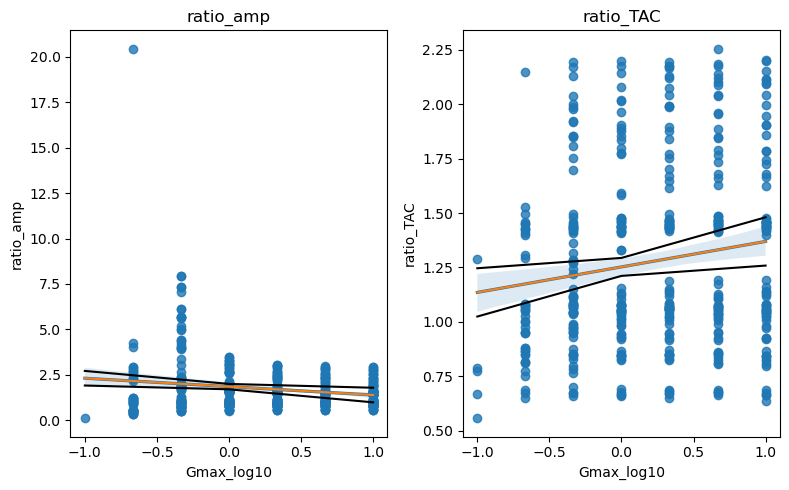

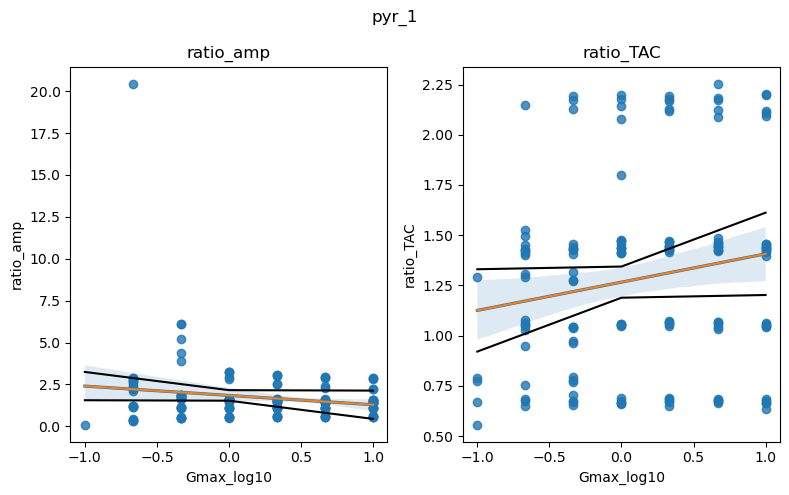

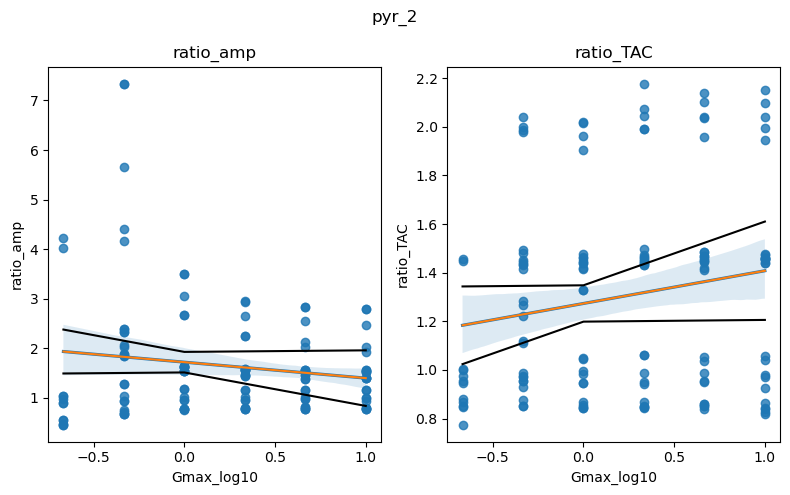

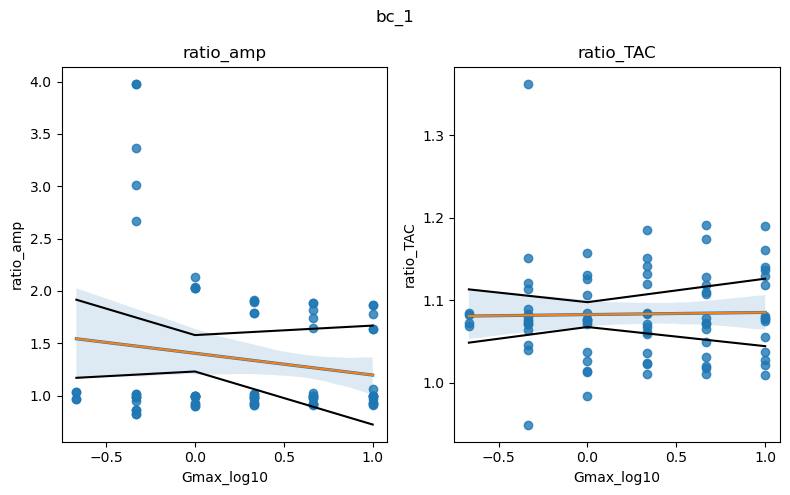

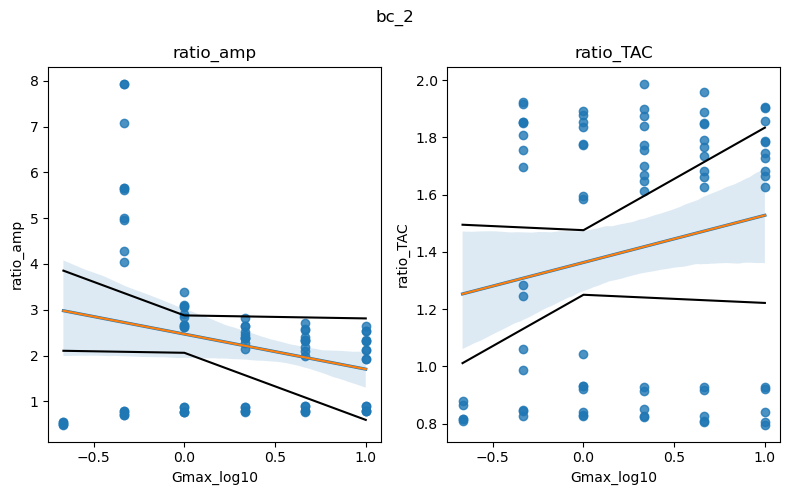

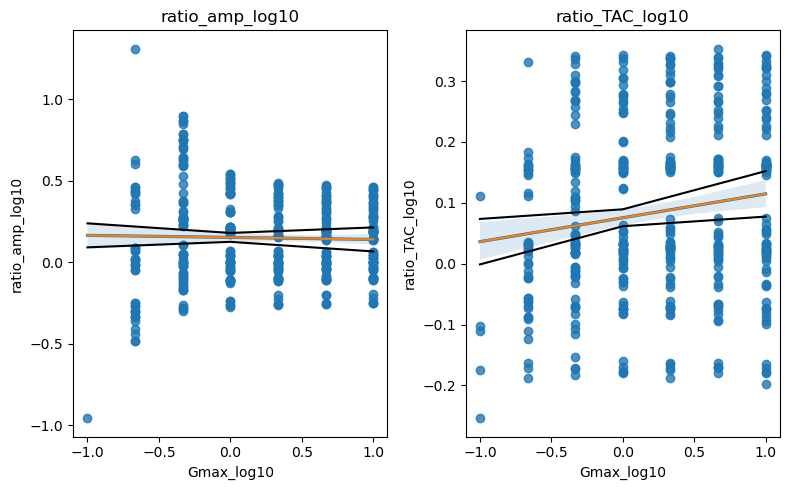

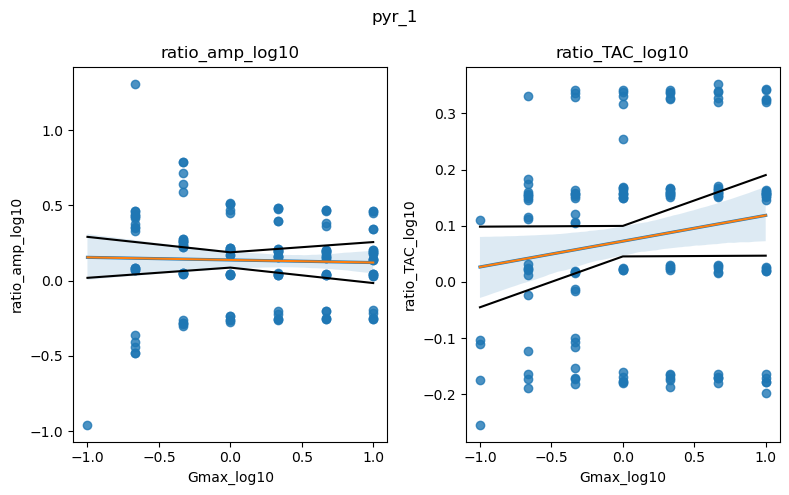

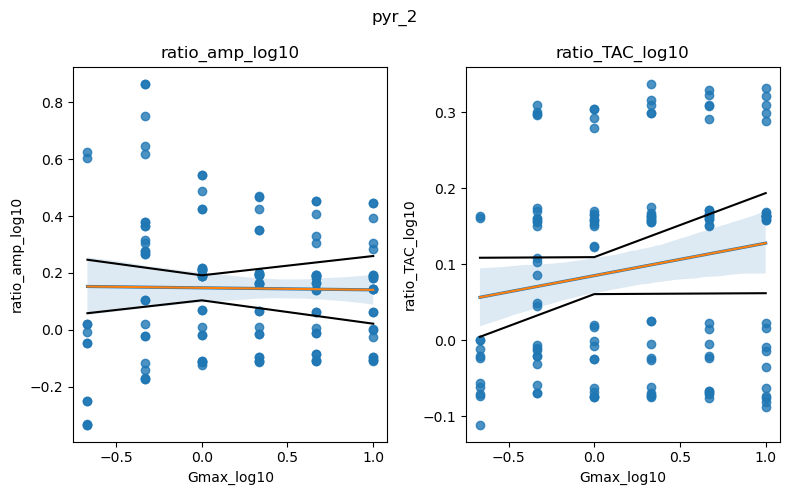

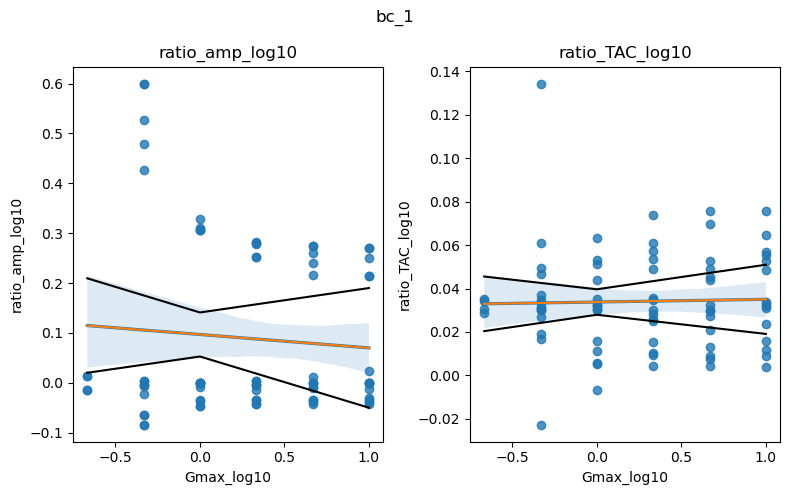

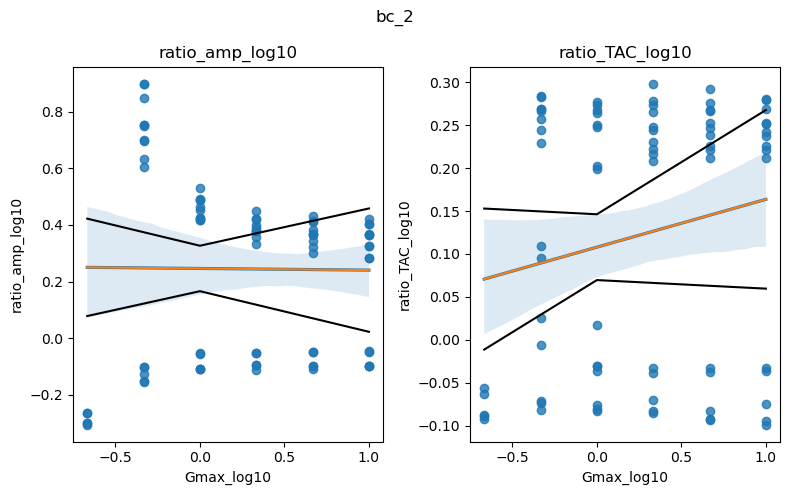

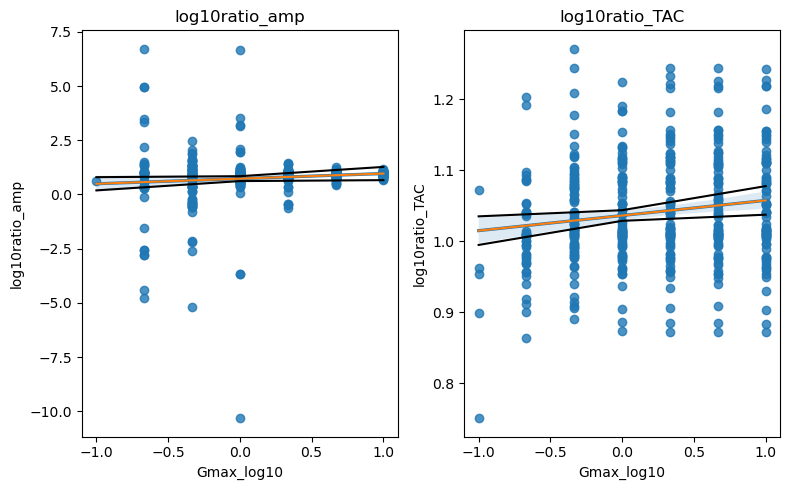

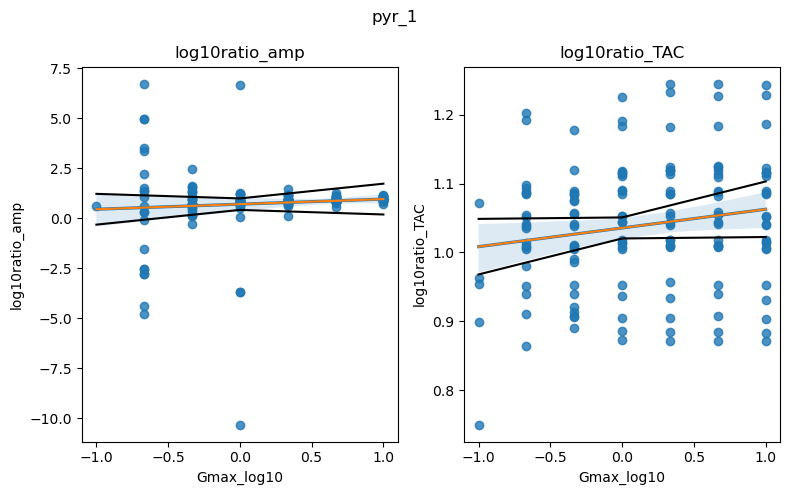

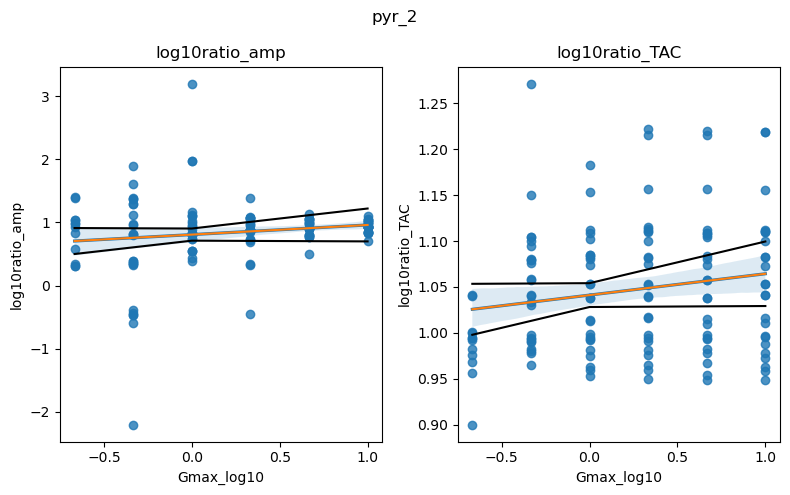

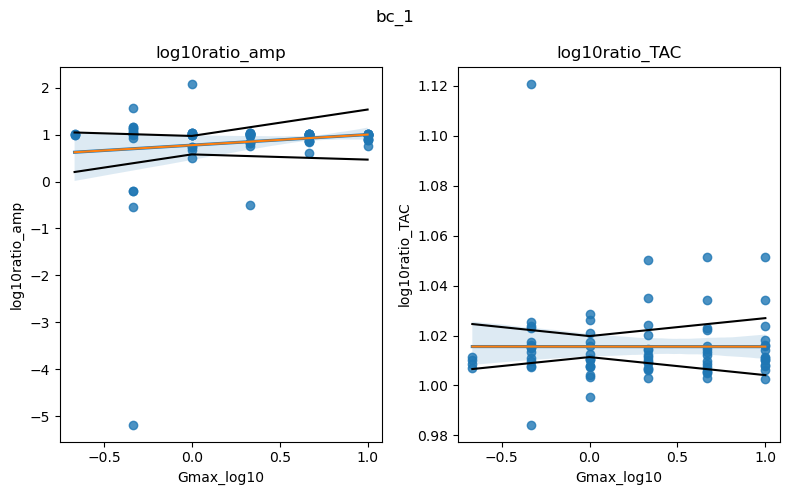

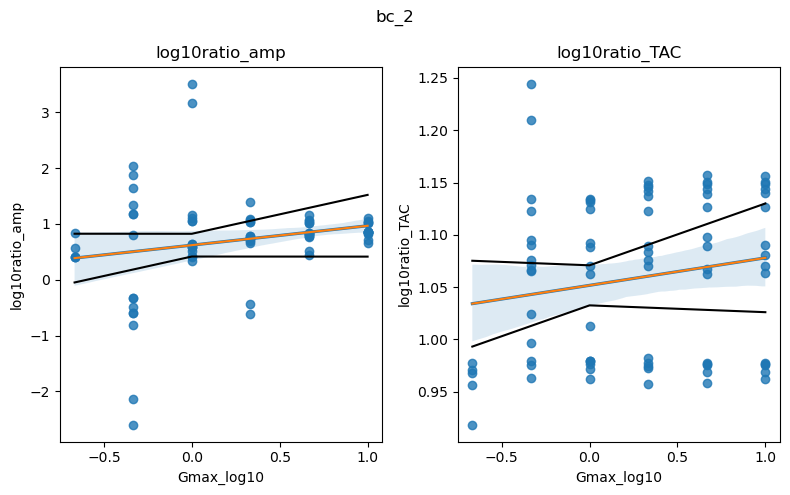

In [ ]:
ress_relSoma_dict = {'ratio_amp':{},'ratio_TAC':{},'ratio_amp_log10':{},'ratio_TAC_log10':{},'log10ratio_amp':{},'log10ratio_TAC':{}}
fig,axs = plt.subplots(1,2,tight_layout = True,figsize=(8,5))
filteronthreshold = True
ress = linearReg(rel_df,['ratio_amp','ratio_TAC'],axs,filteronthreshold,scatterplot=False)
ress_relSoma_dict['ratio_amp']['all'] = ress[0]
ress_relSoma_dict['ratio_TAC']['all'] = ress[1]
for cell in unique_values_columns_master['neurontemplate']:
    intm_df = rel_df[rel_df['neurontemplate']==cell]
    fig,axs = plt.subplots(1,2,tight_layout = True,figsize=(8,5))
    print('\n\n',cell)
    ress = linearReg(intm_df,['ratio_amp','ratio_TAC'],axs,filteronthreshold,scatterplot=False)
    fig.suptitle(cell)
    ress_relSoma_dict['ratio_amp'][cell] = ress[0]
    ress_relSoma_dict['ratio_TAC'][cell] = ress[1]


fig,axs = plt.subplots(1,2,tight_layout = True,figsize=(8,5))
filteronthreshold = True
ress = linearReg(rel_df,['ratio_amp_log10','ratio_TAC_log10'],axs,filteronthreshold,scatterplot=False)
ress_relSoma_dict['ratio_amp_log10']['all'] = ress[0]
ress_relSoma_dict['ratio_TAC_log10']['all'] = ress[1]
for cell in unique_values_columns_master['neurontemplate']:
    intm_df = rel_df[rel_df['neurontemplate']==cell]
    fig,axs = plt.subplots(1,2,tight_layout = True,figsize=(8,5))
    print('\n\n',cell)
    ress = linearReg(intm_df,['ratio_amp_log10','ratio_TAC_log10'],axs,filteronthreshold,scatterplot=False)
    fig.suptitle(cell)
    ress_relSoma_dict['ratio_amp_log10'][cell] = ress[0]
    ress_relSoma_dict['ratio_TAC_log10'][cell] = ress[1]


fig,axs = plt.subplots(1,2,tight_layout = True,figsize=(8,5))
filteronthreshold = True
ress = linearReg(rel_df,['log10ratio_amp','log10ratio_TAC'],axs,filteronthreshold,scatterplot=False)
ress_relSoma_dict['log10ratio_amp']['all'] = ress[0]
ress_relSoma_dict['log10ratio_TAC']['all'] = ress[1]
for cell in unique_values_columns_master['neurontemplate']:
    intm_df = rel_df[rel_df['neurontemplate']==cell]
    fig,axs = plt.subplots(1,2,tight_layout = True,figsize=(8,5))
    print('\n\n',cell)
    ress = linearReg(intm_df,['log10ratio_amp','log10ratio_TAC'],axs,filteronthreshold,scatterplot=False)
    fig.suptitle(cell)
    ress_relSoma_dict['log10ratio_amp'][cell] = ress[0]
    ress_relSoma_dict['log10ratio_TAC'][cell] = ress[1]

## ratio pyramidal sig6 vs pyramidal sig5

pyramidal sig6 more difficult to excite (+- double intensity) than sig 5
- highest ratio for basal dend location
- factor 4 -> 5 (short vs large pd) at low Gmax -> translate to factor 1.5 in TAC
- Higher Gmax ratio drops to 2

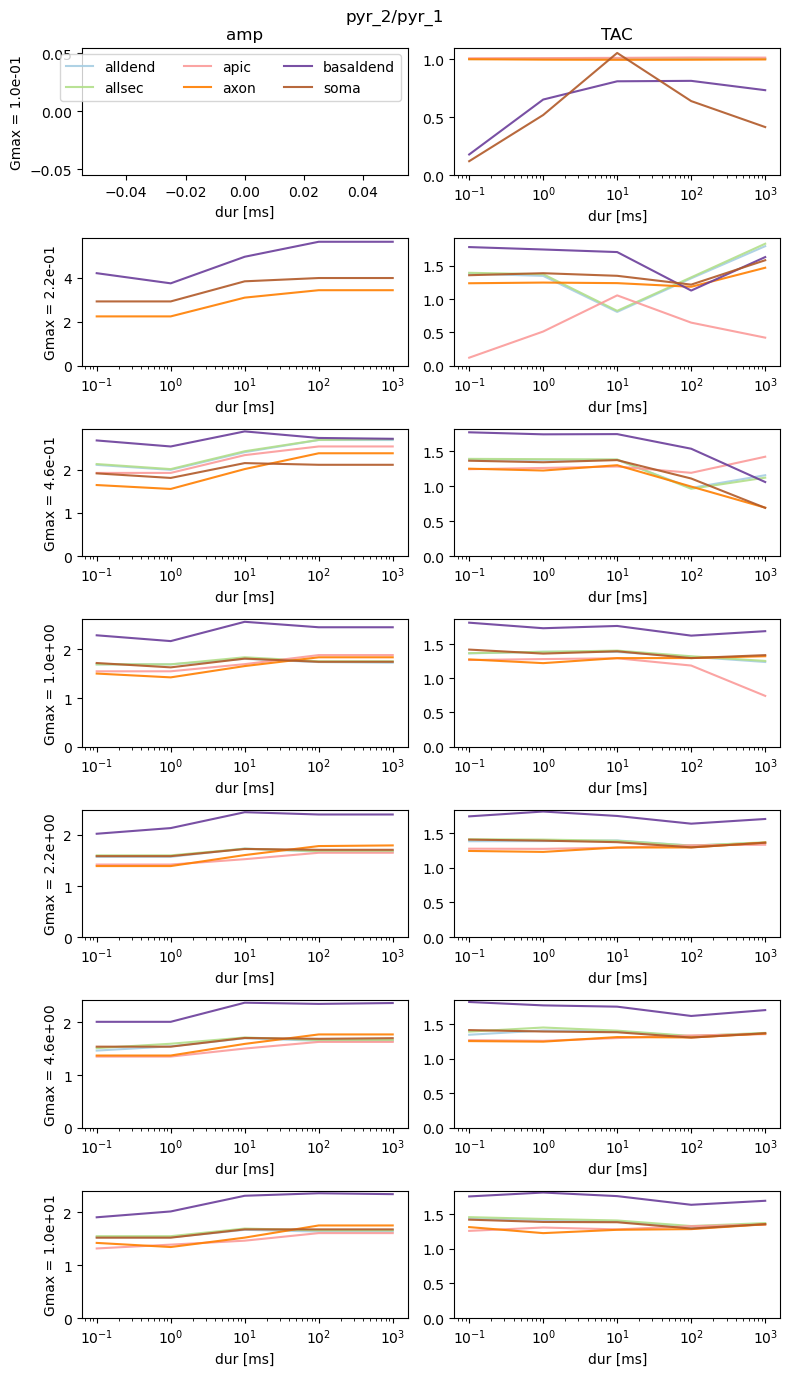

In [ ]:
variables = unique_values_columns_master['neurontemplate'][:2]
colors = plt.get_cmap('Paired',len(unique_values_columns_master['opsinlocations'])).colors
colorpairs = {x:clr for x,clr in zip(unique_values_columns_master['opsinlocations'],colors)}
linestyle_str = ['solid', 'dotted', 'dashed', 'dashdot']
uGmax = np.sort(master_df['Gmax'].unique())[3:-3]
fig,axs = plt.subplots(len(uGmax),2,tight_layout = True,figsize = (8,2*len(uGmax)))


cell_diff_dict = {}
uOpsinLocations = list(master_df[master_df['neurontemplate']==variables[1]]['opsinlocations'].unique())
cell_diff_dict['pyr'] = {key:{'amp':[],'TAC':[],'Gmax':[],'durs':[]} for key in uOpsinLocations}
for i,datalabel in enumerate(['amp','TAC']):
    uOpsinLocations = list(master_df[master_df['neurontemplate']==variables[1]]['opsinlocations'].unique())
    for oL in uOpsinLocations:
        for uG,ax in zip(uGmax,axs[:,i]):
            logscale = False
            intm_df = master_df[master_df['Gmax']==uG]

            clr = colorpairs[oL]
            plot_df = intm_df[intm_df['opsinlocations']==oL]
            xdata = plot_df['dur'][plot_df['neurontemplate']==variables[1]]
            ydata = plot_df[datalabel][plot_df['neurontemplate']==variables[1]]
            ref_ydata = plot_df[datalabel][plot_df['neurontemplate']==variables[0]]
            if len(ydata)==len(ref_ydata):
                ydata = np.array(ydata)/np.array(ref_ydata)
                ax.plot(xdata,ydata,color=clr,alpha=0.9,label=oL)
                if sum(~ np.isnan(ydata))>0:
                    logscale = True
            if logscale:
                ax.set_xscale('log')
                #ax.set_yscale('log')
                if oL==uOpsinLocations[-1]:
                    ax.set_ylim([0,ax.get_ylim()[1]])
            ax.set_xlabel('dur [ms]')
            if i==0:
                ax.set_ylabel(f'Gmax = {uG:0.1e}')
            if uG == uGmax[0]:
                ax.set_title(datalabel)
                if i==0:
                    ax.legend(ncol=3)


    fig.suptitle(f'{variables[1]}/{variables[0]}')
    print()

## statistical violin plots of data above

In [ ]:
# Relative to soma SDC
df1 = master_df[master_df['opsinlocations']=='soma']
df2 = master_df[master_df['opsinlocations']!='soma']
df1 = df1.set_index(['neurontemplate','dur','Gmax'])[['amp','sR','TAC','gchr2']]
df2 = df2.set_index(['neurontemplate','dur','Gmax','opsinlocations'])[['amp','sR','TAC','gchr2']]
rel_df = pd.merge(df1, df2, left_index=True, right_index = True, suffixes=('_0', '_1'),validate='one_to_many')
for key in ['amp','TAC','gchr2']:
    #df3['diff_'+key] = df3[key+'_1']-df3[key+'_0']
    rel_df['ratio_'+key] = rel_df[key+'_1']/rel_df[key+'_0']
rel_df.reset_index(inplace=True)
columns = ['ratio_amp','ratio_TAC','ratio_gchr2']#['diff_amp','ratio_amp','diff_ichr2','ratio_ichr2','diff_gchr2','ratio_gchr2']
grouped = rel_df.groupby('neurontemplate')[columns]
overall_rel_df = pd.merge(grouped.mean(),grouped.std(),left_index=True, right_index=True, suffixes=('_mean', '_std'))
overall_rel_df[[f'ratio_{x}{y}' for x in ['amp','TAC','gchr2'] for y in ['_mean','_std']]]

ratio_amp_mean  ratio_amp_std  ratio_TAC_mean  ratio_TAC_std  \
neurontemplate                                                                 
bc_1                  1.344671       0.683038        1.034806       0.134119   
bc_2                  2.262077       1.662046        1.241788       0.452759   
pyr_1                 1.746437       1.859974        1.200787       0.507117   
pyr_2                 1.642813       1.121579        1.229820       0.384073   

                ratio_gchr2_mean  ratio_gchr2_std  
neurontemplate                                     
bc_1                   38.202636        35.559115  
bc_2                   33.426926        15.564962  
pyr_1                  22.002899        11.689794  
pyr_2                  15.560348        10.771100

In [ ]:
df1 = master_df[master_df['neurontemplate']==unique_values_columns_master['neurontemplate'][0]]
df2 = master_df[master_df['neurontemplate']==unique_values_columns_master['neurontemplate'][1]]
df1 = df1.set_index(['opsinlocations','dur','Gmax'])[['amp','sR','TAC','gchr2']]
df2 = df2.set_index(['opsinlocations','dur','Gmax'])[['amp','sR','TAC','gchr2']]
pyr_df = pd.merge(df1, df2, left_index=True, right_index=True, suffixes=('_0', '_1'))
for key in ['amp','TAC','gchr2']:
    #df3['diff_'+key] = df3[key+'_1']-df3[key+'_0']
    pyr_df['ratio_'+key] = pyr_df[key+'_1']/pyr_df[key+'_0']
pyr_df.reset_index(inplace=True)
columns = ['ratio_amp','ratio_TAC','ratio_gchr2']#['diff_amp','ratio_amp','diff_ichr2','ratio_ichr2','diff_gchr2','ratio_gchr2']
grouped = pyr_df.groupby('opsinlocations')[columns]
overall_pyr_df = pd.merge(grouped.mean(),grouped.std(),left_index=True, right_index=True, suffixes=('_mean', '_std'))
overall_pyr_df



ratio_amp_mean  ratio_TAC_mean  ratio_gchr2_mean  \
opsinlocations                                                     
alldend               1.788940        1.316510          1.451094   
allsec                1.807495        1.327614          1.451646   
apic                  1.600870        1.179573          1.273732   
axon                  1.876362        1.151964          1.497693   
basaldend             2.558635        1.588870          1.667671   
soma                  2.031525        1.155980          2.007117   

                ratio_amp_std  ratio_TAC_std  ratio_gchr2_std  
opsinlocations                                                 
alldend              0.609824       0.162639         1.087553  
allsec               0.607509       0.168911         0.226247  
apic                 0.307034       0.261721         1.018476  
axon                 0.570488       0.161644         0.333351  
basaldend            0.883518       0.357410         0.387169  
soma                 0.727843       0.295897         0.558765

In [ ]:
grouped = pyr_df.groupby(['opsinlocations','dur'])[columns]
dur_pyr_df = pd.merge(grouped.mean(),grouped.std(),left_index=True, right_index=True, suffixes=('_mean', '_std'))
dur_pyr_df

ratio_amp_mean  ratio_TAC_mean  ratio_gchr2_mean  \
opsinlocations dur                                                        
alldend        0.1           1.984720        1.346484          2.065650   
               1.0           1.606383        1.357321          1.173039   
               10.0          1.770386        1.294766          1.255126   
               100.0         1.779414        1.249808          1.366384   
               1000.0        1.779321        1.334171          1.395271   
allsec         0.1           2.007213        1.366135          1.572668   
               1.0           1.619954        1.367630          1.478241   
               10.0          1.789073        1.304950          1.438371   
               100.0         1.797676        1.257820          1.354514   
               1000.0        1.798595        1.341536          1.414434   
apic           0.1           1.438896        1.128674          1.816068   
               1.0           1.438269        1.161599          1.094026   
               10.0          1.609958        1.241910          1.022019   
               100.0         1.757944        1.199611          1.253386   
               1000.0        1.759285        1.166074          1.183162   
axon           0.1           1.594898        1.157835          1.449703   
               1.0           1.553811        1.139151          1.668012   
               10.0          1.913675        1.170712          1.461199   
               100.0         2.158662        1.135445          1.442848   
               1000.0        2.160766        1.156680          1.466703   
basaldend      0.1           2.302982        1.613778          1.699190   
               1.0           2.274260        1.657433          1.763064   
               10.0          2.685205        1.656653          1.745802   
               100.0         2.766353        1.488515          1.554088   
               1000.0        2.764374        1.527972          1.576210   
soma           0.1           1.866366        1.149291          2.035408   
               1.0           1.833915        1.177544          2.043119   
               10.0          2.150463        1.229751          2.127182   
               100.0         2.152442        1.113917          1.938096   
               1000.0        2.154438        1.109397          1.891779   

                       ratio_amp_std  ratio_TAC_std  ratio_gchr2_std  
opsinlocations dur                                                    
alldend        0.1          1.205545       0.124057         2.279221  
               1.0          0.171906       0.127442         0.410259  
               10.0         0.267525       0.210084         0.663045  
               100.0        0.371101       0.136754         0.170373  
               1000.0       0.370528       0.202189         0.219225  
allsec         0.1          1.199172       0.130908         0.248556  
               1.0          0.174699       0.130790         0.225826  
               10.0         0.268623       0.210402         0.229722  
               100.0        0.364222       0.144448         0.166601  
               1000.0       0.371624       0.215246         0.236867  
apic           0.1          0.214527       0.364300         2.134516  
               1.0          0.217869       0.242534         0.278341  
               10.0         0.306981       0.110576         0.617955  
               100.0        0.332342       0.220126         0.257089  
               1000.0       0.331465       0.335423         0.351042  
axon           0.1          0.330051       0.137551         0.228012  
               1.0          0.342648       0.121697         0.555294  
               10.0         0.601623       0.150500         0.209684  
               100.0        0.665937       0.148958         0.227325  
               1000.0       0.664532       0.250495         0.329145  
basaldend      0.1          0.759414       0.505141         

Text(0.5, 0.98, 'opsin in section x/opsin in soma')

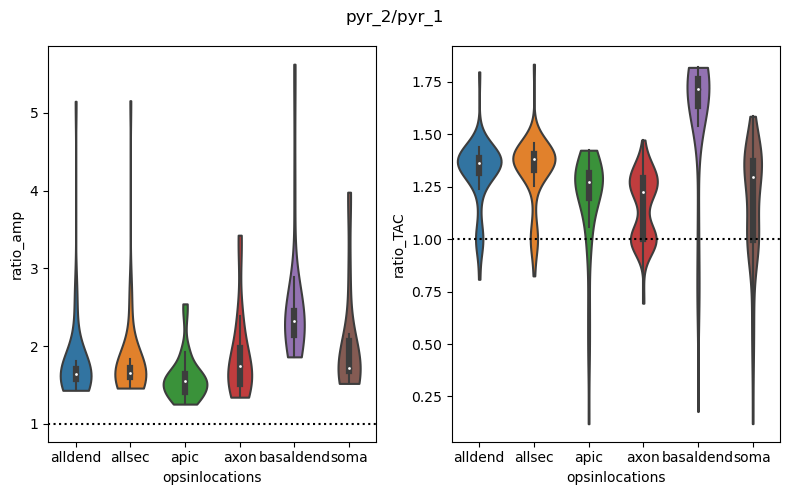

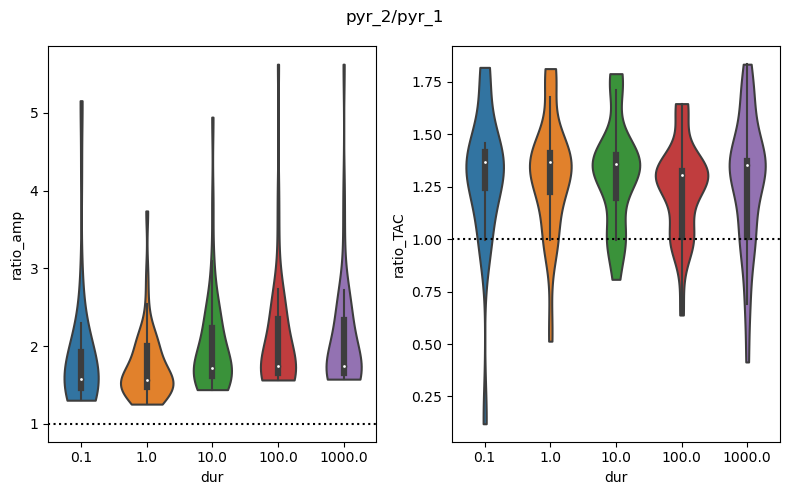

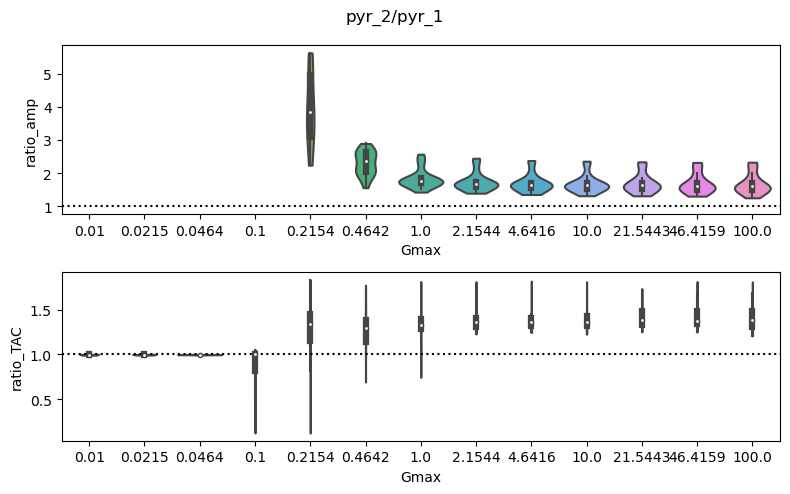

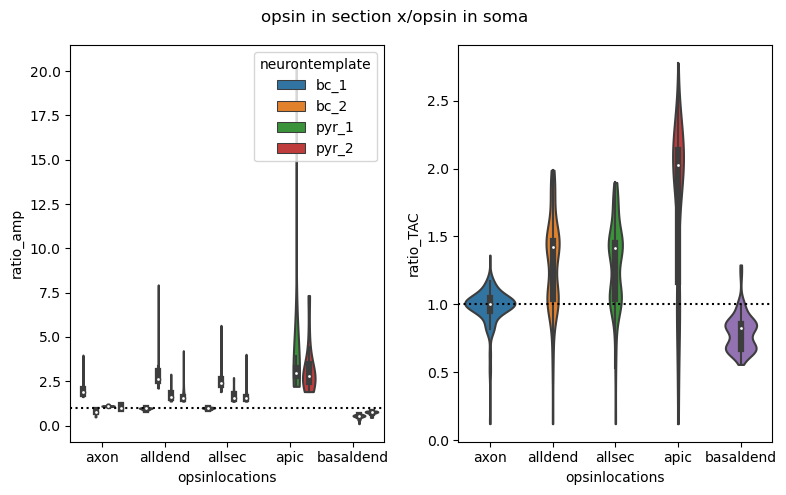

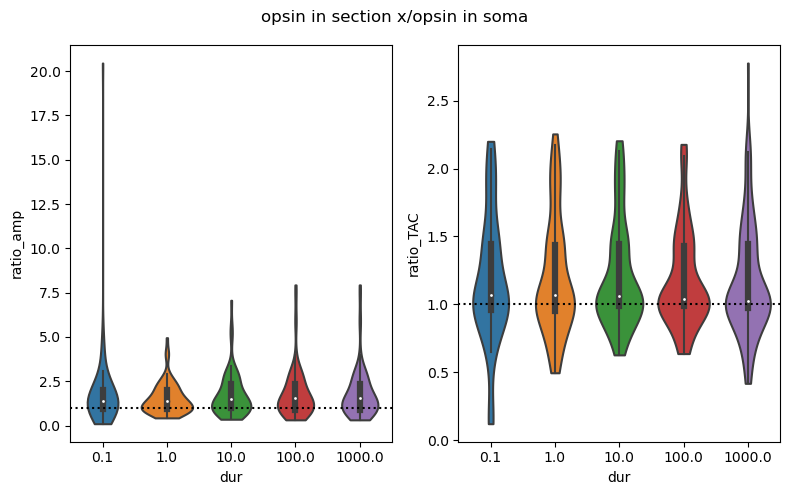

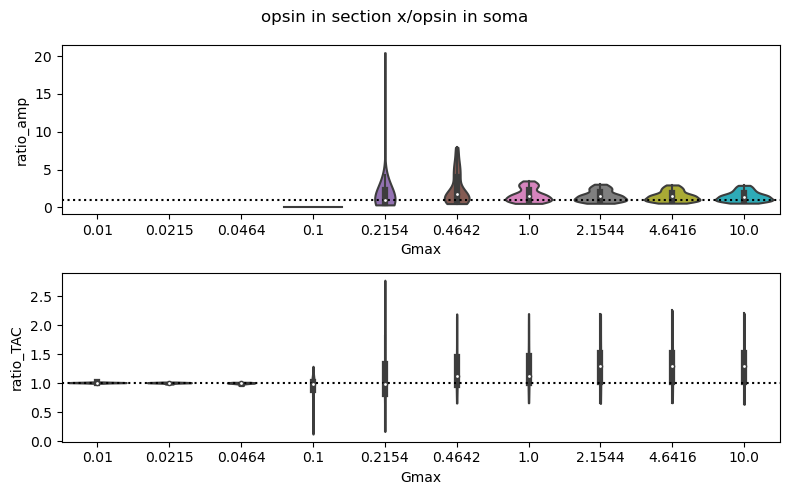

In [ ]:

fig,axs = plt.subplots(1,2,tight_layout = True,figsize=(8,5))

sns.violinplot(data=pyr_df,y='ratio_amp',x='opsinlocations',ax=axs[0],cut=0)
sns.violinplot(data=pyr_df,y='ratio_TAC',x='opsinlocations',ax=axs[1],cut=0)
for ax in axs:
    ax.axhline(1,color='k',linestyle=':')
fig.suptitle(f"{unique_values_columns_master['neurontemplate'][1]}/{unique_values_columns_master['neurontemplate'][0]}")

fig,axs = plt.subplots(1,2,tight_layout = True,figsize=(8,5))
sns.violinplot(data=pyr_df,y='ratio_amp',x='dur',ax=axs[0],cut=0)
sns.violinplot(data=pyr_df,y='ratio_TAC',x='dur',ax=axs[1],cut=0)
for ax in axs:
    ax.axhline(1,color='k',linestyle=':')
fig.suptitle(f"{unique_values_columns_master['neurontemplate'][1]}/{unique_values_columns_master['neurontemplate'][0]}")

fig,axs = plt.subplots(2,1,tight_layout = True,figsize=(8,5))
sns.violinplot(data=pyr_df,y='ratio_amp',x='Gmax',ax=axs[0],cut=0)
sns.violinplot(data=pyr_df,y='ratio_TAC',x='Gmax',ax=axs[1],cut=0)
for ax in axs:
    ax.axhline(1,color='k',linestyle=':')
fig.suptitle(f"{unique_values_columns_master['neurontemplate'][1]}/{unique_values_columns_master['neurontemplate'][0]}")

fig,axs = plt.subplots(1,2,tight_layout = True,figsize=(8,5))
sns.violinplot(data=rel_df,y='ratio_amp',x='opsinlocations',hue='neurontemplate',ax=axs[0],cut=0)
sns.violinplot(data=rel_df,y='ratio_TAC',x='opsinlocations',ax=axs[1],cut=0)
for ax in axs:
    ax.axhline(1,color='k',linestyle=':')
fig.suptitle(f"opsin in section x/opsin in soma")

fig,axs = plt.subplots(1,2,tight_layout = True,figsize=(8,5))
sns.violinplot(data=rel_df,y='ratio_amp',x='dur',ax=axs[0],cut=0)
sns.violinplot(data=rel_df,y='ratio_TAC',x='dur',ax=axs[1],cut=0)
for ax in axs:
    ax.axhline(1,color='k',linestyle=':')
fig.suptitle(f"opsin in section x/opsin in soma")

fig,axs = plt.subplots(2,1,tight_layout = True,figsize=(8,5))
sns.violinplot(data=rel_df,y='ratio_amp',x='Gmax',ax=axs[0],cut=0)
sns.violinplot(data=rel_df,y='ratio_TAC',x='Gmax',ax=axs[1],cut=0)
for ax in axs:
    ax.axhline(1,color='k',linestyle=':')
fig.suptitle(f"opsin in section x/opsin in soma")

ratio_amp_mean  ratio_TAC_mean  ratio_gchr2_mean  \
opsinlocations                                                     
alldend               2.844653        1.397635          1.931265   
allsec                2.376125        1.333592          1.663435   
axon                  0.357354        0.944507          0.164470   
soma                  0.854519        0.937464          0.525020   

                ratio_amp_std  ratio_TAC_std  ratio_gchr2_std  
opsinlocations                                                 
alldend              1.467010       0.372179         0.550224  
allsec               0.907548       0.337094         0.527679  
axon                 0.106021       0.523376         0.075300  
soma                 0.116036       0.048687         0.150461

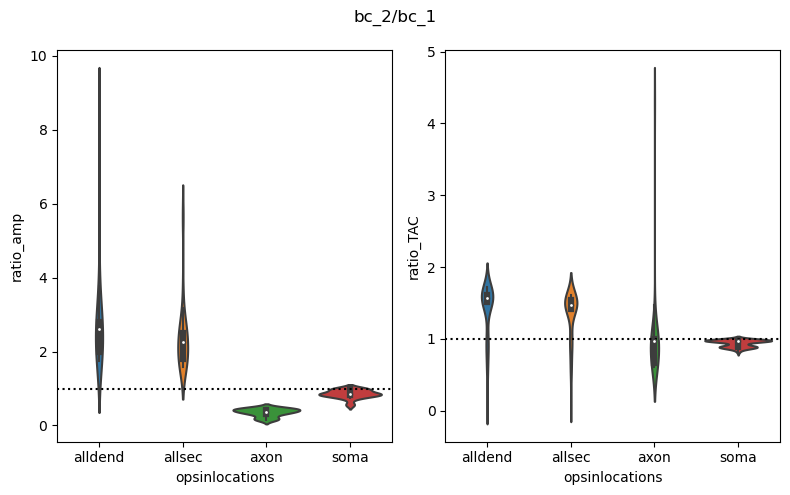

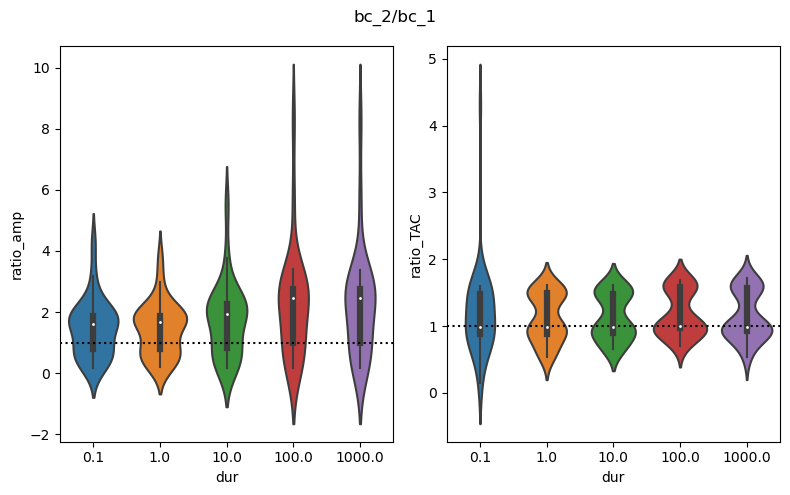

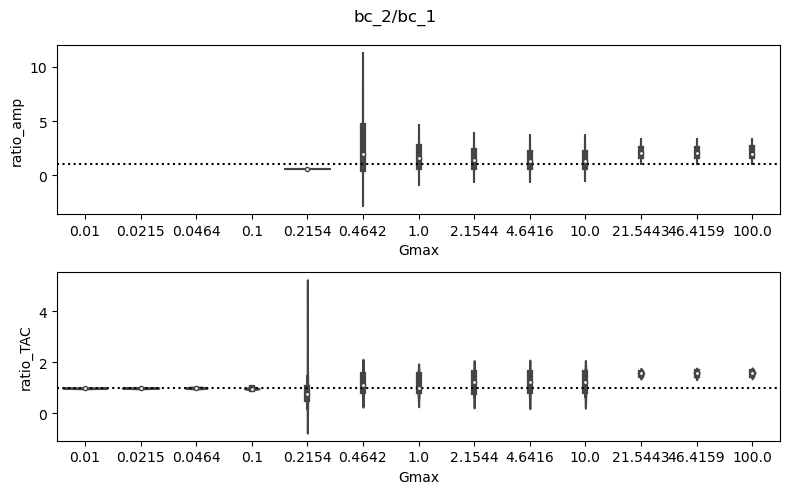

In [ ]:
df1 = master_df[master_df['neurontemplate']==unique_values_columns_master['neurontemplate'][2]]
df2 = master_df[master_df['neurontemplate']==unique_values_columns_master['neurontemplate'][3]]
df1 = df1.set_index(['opsinlocations','dur','Gmax'])[['amp','sR','TAC','gchr2']]
df2 = df2.set_index(['opsinlocations','dur','Gmax'])[['amp','sR','TAC','gchr2']]
int_df = pd.merge(df1, df2, left_index=True, right_index=True, suffixes=('_0', '_1'))
for key in ['amp','TAC','gchr2']:
    #df3['diff_'+key] = df3[key+'_1']-df3[key+'_0']
    int_df['ratio_'+key] = int_df[key+'_1']/int_df[key+'_0']
int_df.reset_index(inplace=True)
columns = ['ratio_amp','ratio_TAC','ratio_gchr2']#['diff_amp','ratio_amp','diff_ichr2','ratio_ichr2','diff_gchr2','ratio_gchr2']
grouped = int_df.groupby('opsinlocations')[columns]
overall_int_df = pd.merge(grouped.mean(),grouped.std(),left_index=True, right_index=True, suffixes=('_mean', '_std'))

fig,axs = plt.subplots(1,2,tight_layout = True,figsize=(8,5))
sns.violinplot(data=int_df,y='ratio_amp',x='opsinlocations',ax=axs[0])
sns.violinplot(data=int_df,y='ratio_TAC',x='opsinlocations',ax=axs[1])
for ax in axs:
    ax.axhline(1,color='k',linestyle=':')
fig.suptitle(f"{unique_values_columns_master['neurontemplate'][3]}/{unique_values_columns_master['neurontemplate'][2]}")

fig,axs = plt.subplots(1,2,tight_layout = True,figsize=(8,5))
sns.violinplot(data=int_df,y='ratio_amp',x='dur',ax=axs[0])
sns.violinplot(data=int_df,y='ratio_TAC',x='dur',ax=axs[1])
for ax in axs:
    ax.axhline(1,color='k',linestyle=':')
fig.suptitle(f"{unique_values_columns_master['neurontemplate'][3]}/{unique_values_columns_master['neurontemplate'][2]}")

fig,axs = plt.subplots(2,1,tight_layout = True,figsize=(8,5))
sns.violinplot(data=int_df,y='ratio_amp',x='Gmax',ax=axs[0])
sns.violinplot(data=int_df,y='ratio_TAC',x='Gmax',ax=axs[1])
for ax in axs:
    ax.axhline(1,color='k',linestyle=':')
fig.suptitle(f"{unique_values_columns_master['neurontemplate'][3]}/{unique_values_columns_master['neurontemplate'][2]}")

overall_int_df

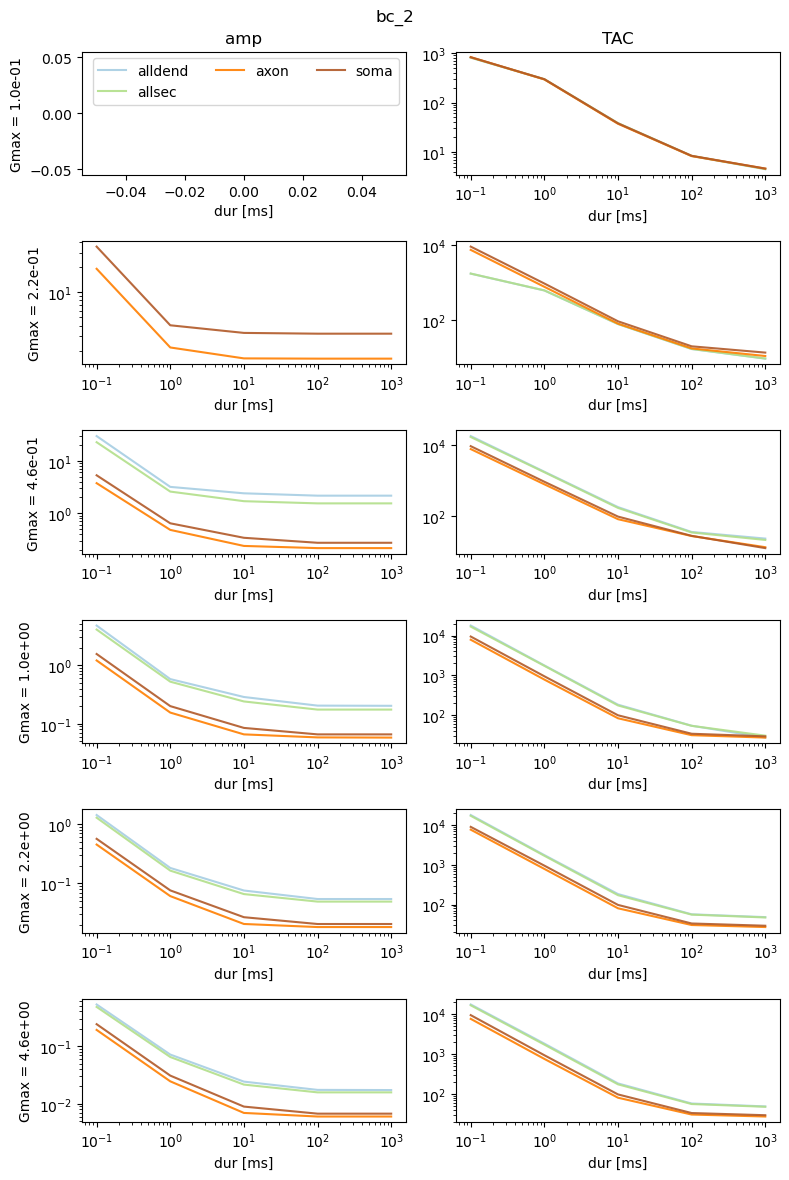

In [ ]:
reference = ''
colors = plt.get_cmap('Paired',len(unique_values_columns_master['opsinlocations'])).colors
colorpairs = {x:clr for x,clr in zip(unique_values_columns_master['opsinlocations'],colors)}
linestyle_str = ['solid', 'dotted', 'dashed', 'dashdot']
uGmax = np.sort(master_df['Gmax'].unique())[3:-4]
fig,axs = plt.subplots(len(uGmax),2,tight_layout = True,figsize = (8,2*len(uGmax)))
for neurontemplate,linestyle in zip(unique_values_columns_master['neurontemplate'][3:],linestyle_str):
    fig_df = master_df[selection_generator(master_df,unique_values_columns=unique_values_columns_master,neurontemplate=neurontemplate)]
    uGmax = np.sort(fig_df['Gmax'].unique())[3:-4]
    for i,datalabel in enumerate(['amp','TAC']):
        for uG,ax in zip(uGmax,axs[:,i]):
            logscale = False
            intm_df = fig_df[fig_df['Gmax']==uG]
            uOpsinLocations = [x for x in intm_df['opsinlocations'].unique() if x != reference]
            for oL in uOpsinLocations:
                clr = colorpairs[oL]
                plot_df = intm_df[intm_df['opsinlocations']==oL]
                xdata = plot_df['dur']
                ydata = plot_df[datalabel]
                ref_ydata = intm_df[intm_df['opsinlocations']==reference][datalabel]
                ax.plot(xdata,ydata,color=clr,alpha=0.9,linestyle=linestyle,label=oL)
                if sum(~ np.isnan(ydata))>0:
                    logscale = True
            if logscale:
                ax.set_xscale('log')
                ax.set_yscale('log')
            ax.set_xlabel('dur [ms]')
            if i==0:
                ax.set_ylabel(f'Gmax = {uG:0.1e}')
            if uG == uGmax[0]:
                ax.set_title(datalabel)
                if i==0:
                    ax.legend(ncol=3)


    fig.suptitle(f'{neurontemplate}')
    print()

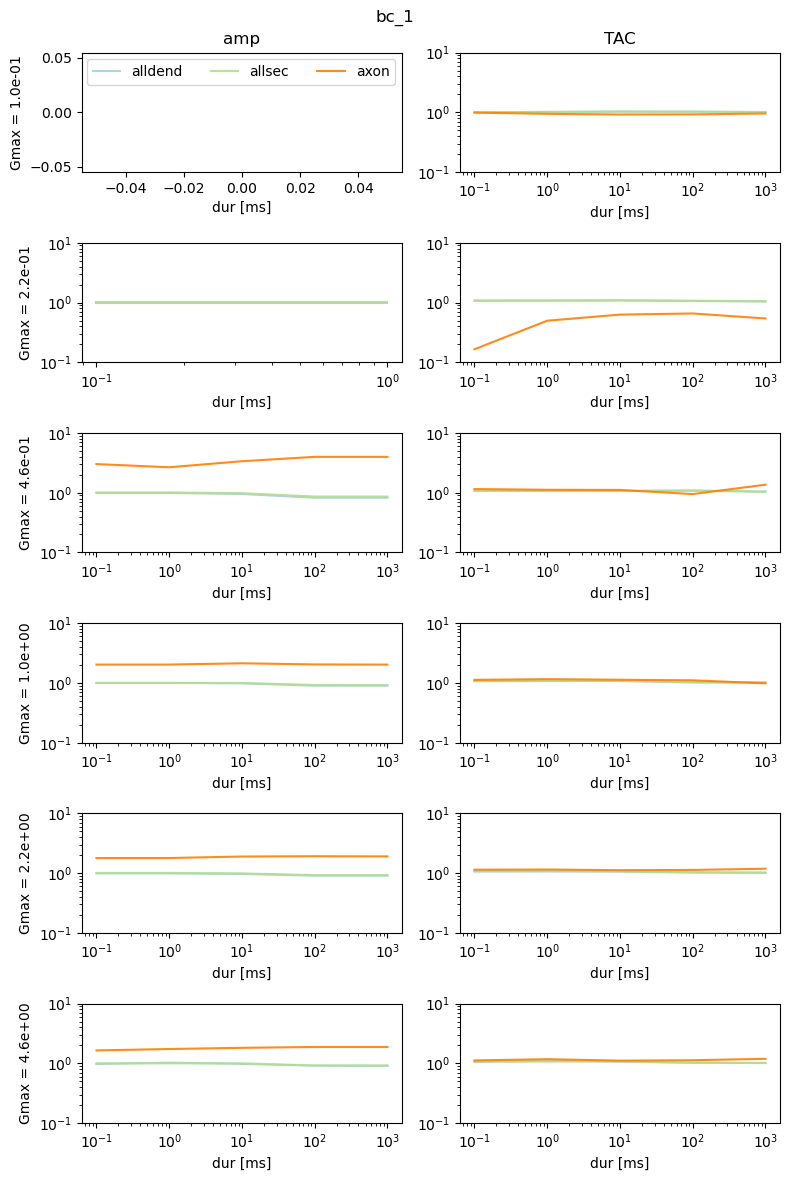

In [ ]:
reference = 'soma'
colors = plt.get_cmap('Paired',len(unique_values_columns_master['opsinlocations'])).colors
colorpairs = {x:clr for x,clr in zip(unique_values_columns_master['opsinlocations'],colors)}
linestyle_str = ['solid', 'dotted', 'dashed', 'dashdot']
uGmax = np.sort(master_df['Gmax'].unique())[3:-4]
fig,axs = plt.subplots(len(uGmax),2,tight_layout = True,figsize = (8,2*len(uGmax)))
for neurontemplate,linestyle,alpha in zip(unique_values_columns_master['neurontemplate'][2:3],linestyle_str,[0.9,0.7]):
    fig_df = master_df[selection_generator(master_df,unique_values_columns=unique_values_columns_master,neurontemplate=neurontemplate)]


    for i,datalabel in enumerate(['amp','TAC']):
        for uG,ax in zip(uGmax,axs[:,i]):
            logscale = False
            intm_df = fig_df[fig_df['Gmax']==uG]
            uOpsinLocations = [x for x in intm_df['opsinlocations'].unique() if x != reference]
            for oL in uOpsinLocations:
                clr = colorpairs[oL]
                plot_df = intm_df[intm_df['opsinlocations']==oL]
                xdata = plot_df['dur']
                ydata = plot_df[datalabel]
                ref_ydata = intm_df[intm_df['opsinlocations']==reference][datalabel]
                if len(ydata)==len(ref_ydata):
                    ydata = np.array(ydata)/np.array(ref_ydata)
                    ax.plot(xdata,ydata,color=clr,alpha=alpha,linestyle=linestyle,label=oL)
                    if sum(~ np.isnan(ydata))>0:
                        logscale = True
            if logscale:
                ax.set_xscale('log')
                ax.set_yscale('log')
                ax.set_ylim([0.1,10])
            ax.set_xlabel('dur [ms]')
            if i==0:
                ax.set_ylabel(f'Gmax = {uG:0.1e}')
            if uG == uGmax[0]:
                ax.set_title(datalabel)
                if i==0:
                    ax.legend(ncol=3)


    fig.suptitle(f'{neurontemplate}')
    print()

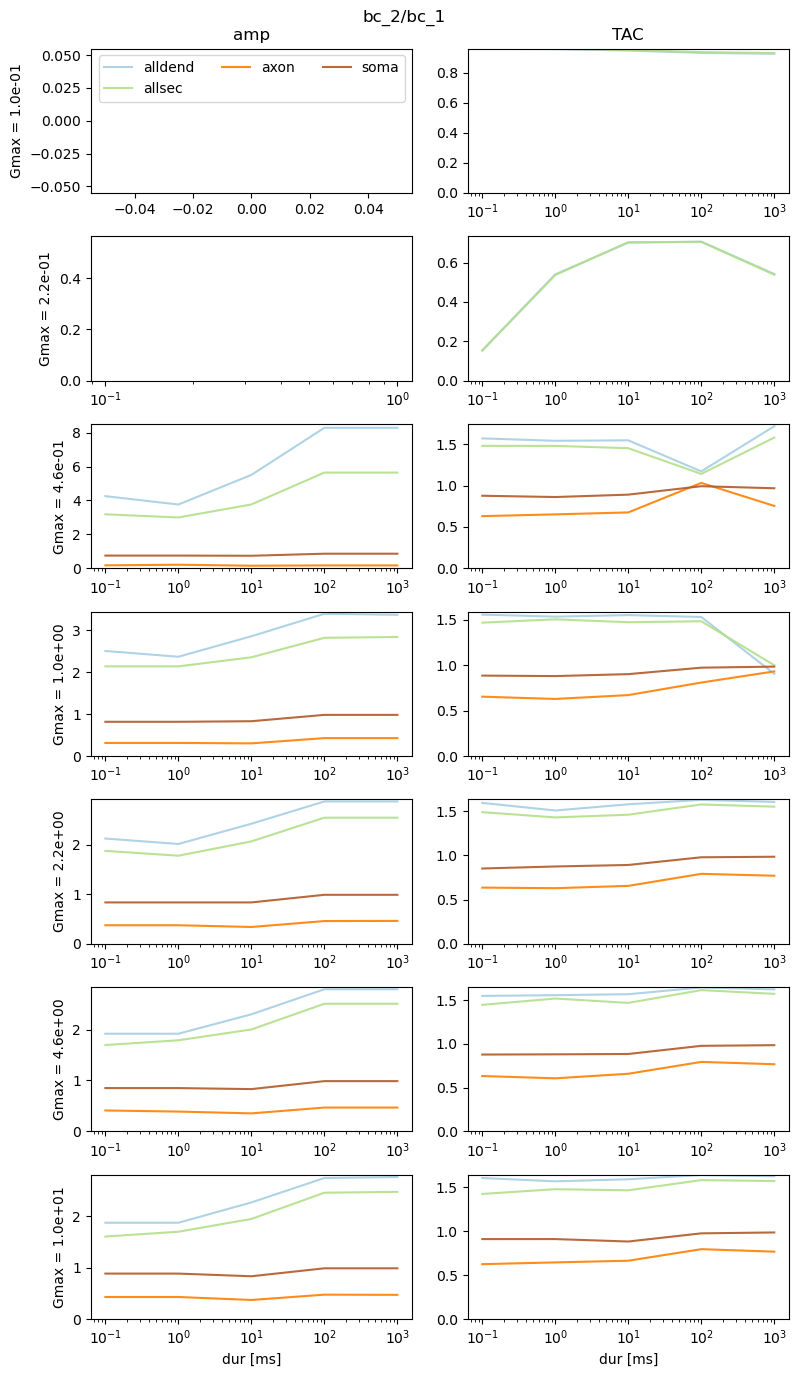

In [ ]:
variables = unique_values_columns_master['neurontemplate'][2:4]
colors = plt.get_cmap('Paired',len(unique_values_columns_master['opsinlocations'])).colors
colorpairs = {x:clr for x,clr in zip(unique_values_columns_master['opsinlocations'],colors)}
linestyle_str = ['solid', 'dotted', 'dashed', 'dashdot']
uGmax = np.sort(master_df['Gmax'].unique())[3:-3]
fig,axs = plt.subplots(len(uGmax),2,tight_layout = True,figsize = (8,2*len(uGmax)))


cell_diff_dict = {}
uOpsinLocations = list(master_df[master_df['neurontemplate']==variables[1]]['opsinlocations'].unique())
cell_diff_dict['pyr'] = {key:{'amp':[],'TAC':[],'Gmax':[],'durs':[]} for key in uOpsinLocations}
for i,datalabel in enumerate(['amp','TAC']):
    uOpsinLocations = list(master_df[master_df['neurontemplate']==variables[1]]['opsinlocations'].unique())
    for oL in uOpsinLocations:
        for uG,ax in zip(uGmax,axs[:,i]):
            logscale = False
            intm_df = master_df[master_df['Gmax']==uG]

            clr = colorpairs[oL]
            plot_df = intm_df[intm_df['opsinlocations']==oL]
            xdata = plot_df['dur'][plot_df['neurontemplate']==variables[1]]
            ydata = plot_df[datalabel][plot_df['neurontemplate']==variables[1]]
            ref_ydata = plot_df[datalabel][plot_df['neurontemplate']==variables[0]]
            if len(ydata)==len(ref_ydata):
                ydata = np.array(ydata)/np.array(ref_ydata)
                ax.plot(xdata,ydata,color=clr,alpha=0.9,label=oL)
                if sum(~ np.isnan(ydata))>0:
                    logscale = True
            if logscale:
                ax.set_xscale('log')
                #ax.set_yscale('log')
                ax.set_ylim([0,ax.get_ylim()[1]])
            if i==0:
                ax.set_ylabel(f'Gmax = {uG:0.1e}')
            if uG == uGmax[0]:
                ax.set_title(datalabel)
                if i==0:
                    ax.legend(ncol=3)
        ax.set_xlabel('dur [ms]')


    fig.suptitle(f'{variables[1]}/{variables[0]}')
    print()

In [ ]:


def amp_log10func(x,a,b,c,d):
    return a*(x-d)+c

popt, pcov = optimize.curve_fit(amp_log10func, xdata, ydata,p0=[1,1,0],bounds=([-np.inf,0,-np.inf],+np.inf))
print(popt)
print(pcov)

TypeError: amp_log10func() missing 1 required positional argument: 'd'